In [68]:
import pandas as pd
import os
from collections import defaultdict

import numpy as np
import statistics 
from scipy import stats

import matplotlib.pyplot as mp
from decimal import Decimal

import statsmodels.tsa.stattools as stattools
#  Use the pacf function of the statsmodels package
from statsmodels.tsa.stattools import pacf,pacf_ols,pacf_yw

import math
import numpy as np
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller  #Dicker-Fuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from Bio import pairwise2
from numpy import linalg as LA
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [69]:
data_dir = 'C:/Users/Qiong/chunting/projects/drug-target/ppis/codes'
import sys
sys.path.append(data_dir)

In [70]:
tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
significant_genes = 'data/GSE28166_significant_genes.txt'

#for PPIN_network in PPIN_network_list:
PPIN_network = 'data/lung/Static_PPIN.txt'
time_points = 6

In [4]:
#static_ppis_in_tissue = pd.read_excel("".join([data_dir, '/data/', 'PPIs_in_tissues_ref.xlsx']), sheet_name = 'PPIs_in_tissues')

#significant_genes = pd.read_excel("".join([data_dir, '/data/', 'GSE28166_significant_genes.xlsx']), sheet_name = 'significant_genes_all_time')

In [3]:
static_ppis_in_tissue = pd.read_excel("".join([data_dir, '/data/', 'PPIs_in_tissues_ref.xlsx']), sheet_name = 'PPIs_in_tissues')

def retrieve_static_ppis_in_tissues(static_ppis_in_tissue):
    #static_ppis_in_tissue = pd.read_excel("".join([data_dir, '/data/', 'PPIs_in_tissues.xlsx']), sheet_name = 'PPIs_in_tissues')
    tissues = []
    list_ppi_gene_a = static_ppis_in_tissue['geneA_symbol']
    list_ppi_gene_b = static_ppis_in_tissue['geneB_symbol']
    for col in static_ppis_in_tissue.columns.str.strip():
        #col = 'adipose_subcutaneous'
        if (not col.startswith('gene')):
            if not os.path.exists("".join([data_dir, '/data/', col])):
                os.makedirs("".join([data_dir, '/data/', col]))
            tissues.append(col)
            ppi_values = static_ppis_in_tissue[col]
            t_ppis = pd.DataFrame(list(zip(list_ppi_gene_a, list_ppi_gene_b, ppi_values)), columns = ['geneA', 'geneB', 'value'])
            valid_t_ppis = t_ppis[t_ppis['value']>0]
            with open("".join([data_dir, '/data/', col, '/Static_PPIN.txt']), 'w') as f:
                for item in valid_t_ppis.values:
                    f.write("".join([str(item[0]), '\t', str(item[1]), '\t', str(item[2]), '\r']))
            f.close()

#retrieve_static_ppis_in_tissues(static_ppis_in_tissue)

# Retrieve static PPINs (direct PPIs, indirect PPIs (shared pathways, shared complexes)

# step 1

In [71]:
def get_common_proteins(gene_expression, PPIN_network, significant_genes):
    expressed_gene_set = set()
    PPIN_gene_set = set()
    significant_genes_set = set()
    
    gene_expression_file = open(gene_expression, 'r')
    for line in gene_expression_file.readlines():
        items = line.strip().split('\t')
        expressed_gene_set.add(str(items[1]))
    gene_expression_file.close()

    significant_genes_file = open(significant_genes, 'r')
    for line in significant_genes_file.readlines():
        items = line.strip().split('\t')
        significant_genes_set.add(str(items[0]))
    significant_genes_file.close()
    
    tmp_common_protein_set = expressed_gene_set.intersection(significant_genes_set)  #PPIN_gene_set)
    common_protein_list = []

    selected_ppis = 0
    PPIN_network_file = open(PPIN_network, 'r')
    for line in PPIN_network_file.readlines():
        items = line.strip().split('\t')
        if str(items[0]) in tmp_common_protein_set and  str(items[1]) in tmp_common_protein_set:
            common_protein_list.append(str(items[0]))
            common_protein_list.append(str(items[1]))  
            selected_ppis += 1
    PPIN_network_file.close()
    common_protein_set = set(common_protein_list)
    
    protein2id = {}
    id2protein = {}
    idx = 0
    for protein in common_protein_set:
        protein2id[protein] = idx
        id2protein[idx] = protein
        idx += 1
    num_proteins = idx

    return common_protein_set, protein2id, id2protein, num_proteins, selected_ppis


tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
significant_genes = 'data/GSE28166_significant_genes.txt'

#for PPIN_network in PPIN_network_list:
PPIN_network = 'data/lung/Static_PPIN.txt'
# - Get common appeared proteins (i.e., genes) from PPI network and GSE3431 gene expression data - #
common_protein_set, protein2id, id2protein, common_num_proteins, selected_ppis = get_common_proteins(gene_expression, PPIN_network, significant_genes)
print('----------------------------------------------------------------------------------------------------')
print('Static PPI network: ' + PPIN_network.split('/')[1])
print('Not every protein has to be active at all time points: ' + str(common_num_proteins))
print('Not every edge has to be active at all time points: ' + str(selected_ppis))

----------------------------------------------------------------------------------------------------
Static PPI network: lung
Not every protein has to be active at all time points: 1161
Not every edge has to be active at all time points: 2527


In [123]:
def count_common_complexes(complexes, gene_i, gene_j, complexes_genes, complexes_genes_syn):
    count = 0
    common_complex_names = []
    for i in range(len(complexes_genes)):
        group = complexes_genes[i] + complexes_genes_syn[i]
        if gene_i in group and gene_i in group:
            count += 1
            common_complex_names.append(complexes['ComplexName'][i])
    return count, list(set(common_complex_names))

def getCommonComplex(complexes, allpairs_num_of_paths, id2protein, PPIN_gene_set, gene2complex):
    allpairs_num_of_complexes = defaultdict(int)
    allpairs_num_of_complexes_names = defaultdict(list)
    for i,j in allpairs_num_of_paths:
        gene_i = id2protein[i]
        gene_j = id2protein[j]
#        count, common_complex_names = count_common_complexes(complexes, gene_i, gene_j, complexes_genes, complexes_genes_syn)
#        allpairs_num_of_complexes[i,j] = count   #/total_complexes
#        allpairs_num_of_complexes_names[i,j] = common_complex_names
#    return allpairs_num_of_complexes, allpairs_num_of_complexes_names, total_complexes
        complex_4_gene_i = list(set(gene2complex[gene_i]))
        complex_4_gene_j = list(set(gene2complex[gene_j]))
        common_complex = [value for value in complex_4_gene_i if value in complex_4_gene_j]
        count = len(common_complex)
        common_complex_names = []
        if (count > 0):
            common_complex_rows = complexes.iloc[common_complex]
            common_complex_names = list(common_complex_rows['ComplexName'])
        if i < j:
            allpairs_num_of_complexes_count[gene_i, gene_j] = count   #/total_complexes
        else:
            allpairs_num_of_complexes_count[gene_j, gene_i] = count   #/total_complexes 
        if i < j:
            allpairs_num_of_complexes_names[gene_i, gene_j] = common_complex_names
        else:
            allpairs_num_of_complexes_names[gene_j, gene_i] = common_complex_names
    return allpairs_num_of_complexes_count, allpairs_num_of_complexes_names

# being used
def allComplexes():
    complexes = pd.read_excel("".join([data_dir, '/data/', 'humanComplexes.xlsx']), sheet_name = 'humanComplexes')
    complexes_idx_list = complexes['ComplexID']
    complexes_genes_strings = complexes['subunits(Gene name)']
    complexes_genes_syn_strings = complexes['subunits(Gene name syn)']
    complexes_genes = [list(filter(None, genes.strip().split(';')))  for genes in complexes_genes_strings]
    complexes_genes_syn = [list(filter(None, genes.strip().split(';')))  for genes in complexes_genes_syn_strings]
    total_complexes = len(complexes_genes_strings)
    gene2complex = defaultdict(list)
    rowidx2complexidx = defaultdict(int)
    complexidx2rowidx = defaultdict(int)
    for row_idx in range(total_complexes):
        rowidx2complexidx[row_idx] = complexes_idx_list[row_idx]
        complexidx2rowidx[complexes_idx_list[row_idx]] = row_idx
        
    for complex_idx in complexes_idx_list:
        for genesymbol in complexes_genes[complexidx2rowidx[complex_idx]]:
            gene2complex[genesymbol].append(complex_idx)
        for complexes_genes_syn in complexes_genes[complexidx2rowidx[complex_idx]]:
            gene2complex[genesymbol].append(complex_idx)
    del complexes
    return total_complexes, gene2complex

# being used
def getCommonComplexes4PPIN(PPIN_gene_set, gene2complex):
    allpairs_num_of_complexes_count = defaultdict(int)
    allpairs_num_of_complexes_ids = defaultdict(list)
    i = 0
    size = len(list(PPIN_gene_set))
    for idx_i in range(size):
        gene_i = list(PPIN_gene_set)[idx_i]
        i += 1
        if (i % 500 == 0): 
            print(i)
        for idx_j in range(idx_i+1, size):
            gene_j = list(PPIN_gene_set)[idx_j]
            complex_4_gene_i = list(set(gene2complex[gene_i]))
            complex_4_gene_j = list(set(gene2complex[gene_j]))
            common_complex = [value for value in complex_4_gene_i if value in complex_4_gene_j]
            count = len(common_complex)
            #if (count > 0):
            #    common_complex_rows = complexes.iloc[common_complex]
            #    common_complex_names = list(common_complex_rows['ComplexName'])
            if (count > 0):
                #print(gene_i, gene_j, count)
                allpairs_num_of_complexes_count[gene_i, gene_j] = count   #/total_complexes
                allpairs_num_of_complexes_ids[gene_i, gene_j] = common_complex  #common_complex_names
    return allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids

#########################################################
# being used
def count_common_pathways(gene_pathways_dict, gene_i, gene_j):
    pathway_i = list(set(gene_pathways_dict[gene_i]))
    pathway_j = list(set(gene_pathways_dict[gene_j]))
    common_pathway_names = [value for value in pathway_i if value in pathway_j]
    return len(common_pathway_names), common_pathway_names

# being used
def allGenePathways():
    gene_pathways = pd.read_excel("".join([data_dir, '/data/', 'CTD_genes_pathways.xlsx']), sheet_name = 'CTD_genes_pathways')
    gene_pathways_dict = defaultdict(list)
    size = len(gene_pathways['GeneSymbol'])
    for i in range(size):
        gene_pathways_dict[gene_pathways['GeneSymbol'][i]].append(gene_pathways['PathwayID'][i])
    total_pathways = len(set(gene_pathways['PathwayID']))
    del gene_pathways
    return total_pathways, gene_pathways_dict

def getCommonPathways(gene_pathways_dict, allpairs_num_of_paths, id2protein):
    allpairs_num_of_pathways_count = defaultdict(int)
    allpairs_num_of_pathways_names = defaultdict(list)
    for i,j in allpairs_num_of_paths:
        gene_i = id2protein[i]
        gene_j = id2protein[j]
        
        count, common_pathways_names = count_common_pathways(gene_pathways_dict, gene_i, gene_j)
        allpairs_num_of_pathways_count[i,j] = count   #/total_pathways
        allpairs_num_of_pathways_names[i,j] = common_pathways_names
    return allpairs_num_of_pathways_count, allpairs_num_of_pathways_names

# being used
def getCommonPathways4PPIN(gene_pathways_dict, PPIN_gene_set):
    allpairs_num_of_pathways_count = defaultdict(int)
    allpairs_num_of_pathways_names = defaultdict(list)
    i = 0
    size = len(list(PPIN_gene_set))
    for idx_i in range(size):
        gene_i = PPIN_gene_set[idx_i]
        i += 1
        if (i % 500 == 0): 
            print(i)
        for idx_j in range(idx_i+1, size):
            gene_j = PPIN_gene_set[idx_j]
            count, common_pathways_names = count_common_pathways(gene_pathways_dict, gene_i, gene_j)
            if count > 0:
                allpairs_num_of_pathways_count[gene_i,gene_j] = count   #/total_pathways
                allpairs_num_of_pathways_names[gene_i,gene_j] = common_pathways_names
    return allpairs_num_of_pathways_count, allpairs_num_of_pathways_names

In [121]:
from decimal import Decimal
def load_static_tPPI(PPIN_network, protein2id):
    PPIN_genes = []
    PPINs = defaultdict(float)
    PPIN_network_file = open(PPIN_network, 'r')
    with open(PPIN_network, 'r') as PPIN_network_file:
        for line in PPIN_network_file.readlines():
            items = line.strip().split('\t')
            if not ((str(items[0]) in protein2id) and (str(items[1]) in protein2id)):   #skip edges for uncommon protein
                continue
            PPIN_genes.append(str(items[0]))
            PPIN_genes.append(str(items[1]))
            idx_i = protein2id[str(items[0])]
            idx_j = protein2id[str(items[1])]
            if (idx_i < idx_j):
                PPINs[str(items[0]), str(items[1])] = float(items[2])
            else:
                PPINs[str(items[1]), str(items[0])] = float(items[2])
    PPIN_network_file.close()  
    PPIN_gene_set = set(PPIN_genes)
    num_of_edges = len(PPINs)
    num_of_nodes = len(set(PPIN_gene_set)) 
    return num_of_nodes, num_of_edges, PPIN_gene_set, PPINs

                                    
# Actions:
PPIN_network_file = "".join([data_dir, '/data/lung/', 'Static_PPIN.txt']) 
num_of_nodes, num_of_edges, PPIN_gene_set, PPINs = load_static_tPPI(PPIN_network_file, protein2id)
print('static PPIN (#(nodes), #(edges)): ', num_of_nodes, num_of_edges)
                                    

static PPIN (#(nodes), #(edges)):  1161 2527


from decimal import Decimal
def num_of_edges_in_static_tPPI(PPINs, num_proteins, selectednodes):
    count = 0
    for i in range(num_proteins):
        gene_i = selectednodes[i]
        for j in range(num_proteins):
            if i < j:
                gene_j = selectednodes[j]
                if (gene_i, gene_j) in PPINs and (gene_j, gene_i) in PPINs:
                    count += 1
    return count

num_of_selected_edges = num_of_edges_in_static_tPPI(PPINs, common_num_proteins, list(common_protein_set))
print(num_of_selected_edges )

def num_of_edges_in_matrix(matrix, num_proteins, selectednodes):
    count = 0
    for i in range(num_proteins):
        for j in range(num_proteins):
            if i < j and matrix[i,j]>0:
                count += 1
    return count
num_of_selected_edges = num_of_edges_in_matrix(asso_matrix, common_num_proteins, list(common_protein_set))
print(num_of_selected_edges )
#asso_matrix,static_ppi_matrix, ppi_in_pathway_matrix, ppi_in_complex_matrix, mock_DPPINs, mock_act_prob_matrix,mock_coe_matrix, mock_mi_matrix, mock_std_matrix,exp_DPPINs, exp_act_prob_matrix,exp_coe_matrix, exp_mi_matrix, exp_std_matrix
num_of_selected_edges = num_of_edges_in_matrix(static_ppi_matrix, common_num_proteins, list(common_protein_set))
print(num_of_selected_edges )
num_of_selected_edges = num_of_edges_in_matrix(ppi_in_pathway_matrix, common_num_proteins, list(common_protein_set))
print(num_of_selected_edges )
num_of_selected_edges = num_of_edges_in_matrix(ppi_in_complex_matrix, common_num_proteins, list(common_protein_set))
print(num_of_selected_edges )
#for t in range(6):

In [78]:
total_pathways, gene_pathways_dict = allGenePathways()
print("total_pathways:", total_pathways)
#allpairs_num_of_pathways_count, allpairs_num_of_pathways_names = getCommonPathways4PPIN(gene_pathways_dict, PPIN_gene_set)
allpairs_num_of_pathways_count, allpairs_num_of_pathways_names = getCommonPathways4PPIN(gene_pathways_dict, list(common_protein_set))
print('Finish') 

total_pathways: 292
500
1000
Finish


In [124]:
total_complexes, gene2complex = allComplexes()
print("total_complexes:", total_complexes)   
#allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids = getCommonComplexes4PPIN(PPIN_gene_set, gene2complex)
allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids = getCommonComplexes4PPIN(common_protein_set, gene2complex)
print('Finish')

total_complexes: 3574
500
1000
Finish


In [125]:
complex2gene = defaultdict(int)
for gene_i,gene_j in allpairs_num_of_complexes_ids:
    for complex_id in allpairs_num_of_complexes_ids[gene_i, gene_j]:
        complex2gene[complex_id] += 1
print(len(complex2gene))

247


In [81]:
pathway2gene = defaultdict(int)
for gene_i,gene_j in allpairs_num_of_pathways_names:
    for pathway_id in allpairs_num_of_pathways_names[gene_i, gene_j]:
        pathway2gene[pathway_id] += 1
print(len(pathway2gene))

193


In [82]:
len(allpairs_num_of_pathways_names)

24867

In [58]:
allpairs_in_pathways = set(allpairs_num_of_pathways_names.keys())
allpairs_in_complex = set(allpairs_num_of_complexes_ids.keys())
allpairs_in_static_graph = set(PPINs.keys())
common_ppis = allpairs_in_pathways.intersection(allpairs_in_complex.intersection(allpairs_in_static_graph))
min_pathways = 194
for (gene_i, gene_j) in allpairs_num_of_pathways_names.keys():
    if min_pathways > allpairs_num_of_pathways_count[gene_i, gene_j]:
        min_pathways = allpairs_num_of_pathways_count[gene_i, gene_j]
print(min_pathways)

max_pathways = 1
for (gene_i, gene_j) in allpairs_num_of_pathways_names.keys():
    if max_pathways < allpairs_num_of_pathways_count[gene_i, gene_j]:
        max_pathways = allpairs_num_of_pathways_count[gene_i, gene_j]
print(max_pathways)

pair_with_max_pathways = []
dist_shared_pathways = []
dist_shared_pathways_dict_ppis = []
shared_pathways_dict_ppis = allpairs_in_pathways.intersection(allpairs_in_static_graph)
for shared_pathways in range(1, max_pathways+1):
    count = 0
    for (gene_i, gene_j) in allpairs_num_of_pathways_names.keys():
        #if (not ((gene_i,gene_j) in allpairs_in_complex)) and allpairs_num_of_pathways_count[gene_i, gene_j] > 20:  #== max_pathways:
        if allpairs_num_of_pathways_count[gene_i, gene_j] == shared_pathways:
            count += 1
        #pair_with_max_pathways.append(allpairs_num_of_pathways_count[gene_i, gene_j])
            #pair_with_max_pathways.append((gene_i, gene_j))
            #pair_with_max_pathways.append(allpairs_num_of_pathways_names[gene_i, gene_j])
    dist_shared_pathways.append(count)
    count = 0
    for (gene_i, gene_j) in shared_pathways_dict_ppis:
        #if (not ((gene_i,gene_j) in allpairs_in_complex)) and allpairs_num_of_pathways_count[gene_i, gene_j] > 20:  #== max_pathways:
        if allpairs_num_of_pathways_count[gene_i, gene_j] == shared_pathways:
            count += 1
        #pair_with_max_pathways.append(allpairs_num_of_pathways_count[gene_i, gene_j])
            #pair_with_max_pathways.append((gene_i, gene_j))
            #pair_with_max_pathways.append(allpairs_num_of_pathways_names[gene_i, gene_j])
    dist_shared_pathways_dict_ppis.append(count)

print(dist_shared_pathways)
print(dist_shared_pathways_dict_ppis)
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = range(1, max_pathways+1)
y1 = dist_shared_pathways
y2 = dist_shared_pathways_dict_ppis
# plot lines
plt.plot(x, y1, linestyle='-', marker='x', color='b', label = "#(protein pairs in k pathways)")
plt.plot(x, y2, linestyle='--', color='r', label = "#(direct PPIs in k pathways)")
plt.xlabel('Number of shared pathways, k')
plt.ylabel('Count of protein pairs')
plt.legend()
plt.show()

NameError: name 'PPINs' is not defined

In [ ]:
allpairs_in_pathways = set(allpairs_num_of_pathways_names.keys())
allpairs_in_complex = set(allpairs_num_of_complexes_ids.keys())
allpairs_in_static_graph = set(PPINs.keys())

def num_of_nodes(pairs):
    nodes = list()
    for (v1, v2) in pairs:
        nodes.append(v1)
        nodes.append(v2)
    return len(set(nodes))

print('nodes of allpairs_in_pathways:', num_of_nodes(allpairs_in_pathways), " edges:", len(allpairs_in_pathways))
print('nodes of allpairs_in_complex:', num_of_nodes(allpairs_in_complex), " edges:", len(allpairs_in_complex))
print('nodes of allpairs_in_static_graph:', num_of_nodes(allpairs_in_static_graph), " edges:", len(allpairs_in_static_graph))

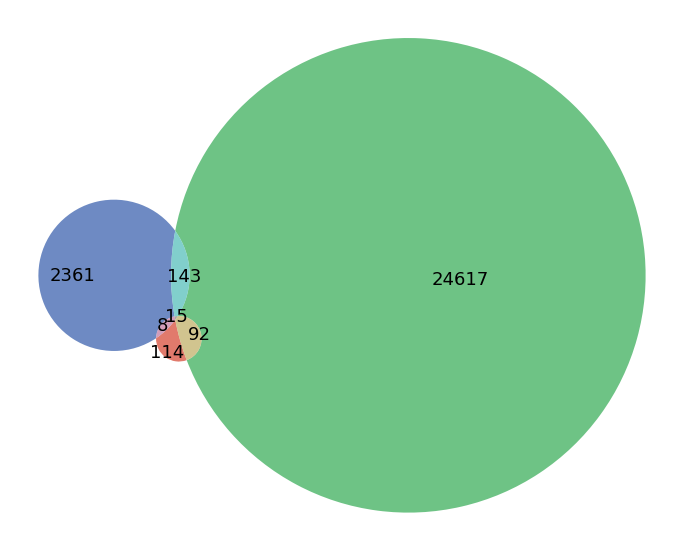

In [14]:
allpairs_in_pathways = set(allpairs_num_of_pathways_count.keys())
allpairs_in_complex = set(allpairs_num_of_complexes_count.keys())
allpairs_in_static_graph = set(PPINs.keys())
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib_venn import venn3_circles
from matplotlib.cbook import flatten

fig, ax = plt.subplots(1, figsize=(12,10))
data = [allpairs_in_static_graph, allpairs_in_pathways, allpairs_in_complex]
out = venn3(data, ('', '', ''), normalize_to=2.0, set_colors=('#3E64AF', '#3EAF5D', '#D74E3B'), alpha=0.75)
#venn3_circles([allpairs_in_static_graph, allpairs_in_pathways, allpairs_in_complex], lw=0.7)
#for text in out.set_labels:
#    text.set_fontsize(20)
for text in out.subset_labels:
    text.set_fontsize(18)

#('', '', '')
#('Y2H: Direct PPIs', 'PPIs in pathways', 'PPIs in complexes')
#for i in list('100, 010, 110, 001, 101, 011, 111'.split(', ')):
#    out.get_label_by_id('%s'%i).set_text('%s'%i)
plt.show()

In [15]:
from decimal import Decimal
def write_static_PPI_info_to_file(filename, PPIN_gene_set, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids ):
    with open(filename, 'w') as f:
        num_proteins = len(list(PPIN_gene_set))
        for idx_i in range(num_proteins):
            gene_i = list(PPIN_gene_set)[idx_i]
            if (idx_i % 500 == 0):
                print(idx_i)
            for idx_j in range(idx_i+1, num_proteins): 
                gene_j = list(PPIN_gene_set)[idx_j]
                exists = False
                ppi_confidence = 0
                if ((gene_i, gene_j) in PPINs) and (PPINs[gene_i,gene_j] > 0):
                    ppi_confidence = PPINs[gene_i,gene_j]
                    exists = True
                ppi_pathways = []
                ppi_pathways_count = 0
                if ((gene_i, gene_j) in allpairs_num_of_pathways_count) and (allpairs_num_of_pathways_count[gene_i,gene_j] > 0):
                    ppi_pathways_count = allpairs_num_of_pathways_count[gene_i,gene_j]
                    ppi_pathways = allpairs_num_of_pathways_names[gene_i,gene_j]
                    exists = True
                ppi_complexes = []
                ppi_complexes_count = 0
                if ((gene_i, gene_j) in allpairs_num_of_complexes_count)  and (allpairs_num_of_complexes_count[gene_i,gene_j] > 0):
                    ppi_complexes_count = allpairs_num_of_complexes_count[gene_i,gene_j]
                    ppi_complexes = allpairs_num_of_complexes_ids[gene_i,gene_j]
                    exists = True
                if exists:
                    f.write('\t'.join([gene_i, gene_j, str(ppi_confidence), str(ppi_pathways_count), str(ppi_complexes_count), ';'.join(ppi_pathways), '\n']))
                                       #, ';'.join(ppi_complexes), '\n']))
    f.close()
    
# Action
filename = "".join([data_dir, '/data/lung/', 'Static_PPIN_pathway_complexes.txt'])
print('Writing to the file, ', filename)
#allpairs_num_of_complexes_count = dict()
#allpairs_num_of_complexes_ids = dict()
#write_static_PPI_info_to_file(filename, PPIN_gene_set, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids)
write_static_PPI_info_to_file(filename, common_protein_set, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids)

print('Finish')

Writing to the file,  C:/Users/Qiong/chunting/projects/drug-target/ppis/codes/data/lung/Static_PPIN_pathway_complexes.txt
0
500
1000
Finish


In [ ]:
allpairs_num_of_pathways_names

plt.annotate('15 direct PPIs participating in a pathway and complex', 
         color='black',
         xy=out.get_label_by_id('111').get_position() - np.array([0, 0.05]), 
         xytext=(200,10),
         ha='center', textcoords='offset points', 
         bbox=dict(boxstyle='round,pad=0.5', fc='#098154', alpha=0.6),
         arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5',color='#098154')
        )


plt.annotate('8 direct PPIs participating in a complex (not in a pathway)', 
         color='black',
         xy=out.get_label_by_id('101').get_position() + np.array([0, 0.05]), 
         xytext=(-40,-150),
         ha='center', textcoords='offset points', 
         bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.6),
         arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=0.5',color='blue')
        )

plt.annotate('143 direct PPIs participating in a pathway (not in a complex)', 
         color='black',
         xy=out.get_label_by_id('110').get_position() + np.array([0, 0.05]), 
         xytext=(-40,100),
         ha='center', textcoords='offset points', 
         bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.6),
         arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.5',color='black')
        )

plt.annotate('92 indirect PPIs participating in a pathway (not in a complex)', 
         color='black',
         xy=out.get_label_by_id('011').get_position() + np.array([0, 0.05]), 
         xytext=(200,-40),
         ha='center', textcoords='offset points', 
         bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.6),
         arrowprops=dict(arrowstyle='-|>', connectionstyle='arc3,rad=-0.5',color='black')
        )

# Step 2

In [11]:
def create_mixed_adjacent_matrix(filename, common_num_proteins, protein2id):
    asso_matrix = np.zeros((common_num_proteins, common_num_proteins), dtype=int)
    i = 0
    with open(filename, 'r') as f:
        for line in f.readlines():
            i += 1
            if (i % 10000 == 0):
                print(i)
            items = line.strip().split('\t')
            gene_i = items[0]
            gene_j = items[1]
            idx_gene_i = protein2id[gene_i]
            idx_gene_j = protein2id[gene_j]
            asso_matrix[idx_gene_i][idx_gene_j] = 1
            asso_matrix[idx_gene_j][idx_gene_i] = 1
    f.close()
    return asso_matrix

#Action:
filename = "".join([data_dir, '/data/lung/', 'Static_PPIN_pathway_complexes.txt'])
asso_matrix = create_mixed_adjacent_matrix(filename, common_num_proteins, protein2id)
print('Done')

10000
20000
Done


In [12]:
def num_of_edges_in_matrix(matrix, num_proteins, selectednodes): 
    count = 0 
    for i in range(num_proteins): 
        for j in range(num_proteins): 
            if i < j and matrix[i,j]>0: 
                count += 1 
    return count 

print('nodes of multigraph:', len(asso_matrix))
num_of_edges_in_multigraph = num_of_edges_in_matrix(asso_matrix, common_num_proteins, list(common_protein_set)) 
print('edges of multigraph:', num_of_edges_in_multigraph )

nodes of multigraph: 1161
edges of multigraph: 27350


# step 3 validation of data + act prob. matrix (read from gene expression data)

In [13]:
from numpy.dual import lstsq
from statsmodels.tools import add_constant
from statsmodels.tsa.tsatools import lagmat
import statsmodels.tsa.stattools as stattools
#  Use the pacf function of the statsmodels package
from statsmodels.tsa.stattools import pacf,pacf_ols,pacf_yw

import math
import numpy as np
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller  #Dicker-Fuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from Bio import pairwise2
from numpy import linalg as LA
from scipy.stats import wilcoxon
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

def cronbach_alpha(df):
    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()  #method ='kendall' 'pearson'
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def perform_adf_test(series1, series2, N):
    for i in range(N):
        serial1 = series1[i,:]
        result = adfuller(serial1)
        print("[Control %i] ADF Statistic: %f" % (i, result[0]))
        print("[Control %i] p-value: %f" % (i, result[1]))
        serial2 = series2[i,:]
        result = adfuller(serial2)
        print("[Exp %i] ADF Statistic: %f" % (i, result[0]))
        print("[Exp %i] p-value: %f" % (i, result[1])) 

def cal_acf(x, nlags):
    """
    Write your own according to the formula acf function
    It is only used to help understand. It is not recommended to use it in other environments
    """
    x = np.array(x)
    mean_x = np.mean(x)
    length_x = x.shape[0]
    c_0 = np.mean((x-mean_x) **2)
    c_k = np.sum((x[:(length_x-nlags)] - mean_x) * (x[nlags:] - mean_x)) / length_x
    r_k = c_k / c_0
    return r_k


#  The function of solving pacf with ols is implemented by myself
def cal_my_pacf_ols(x, nlags=5):
    """
    Self realization pacf，The principle uses ols(least square method)
    :param x:
    :param nlags:
    :return:
    """
    pacf = np.empty(nlags+1) * 0
    pacf[0] = 1.0

    xlags, x0 = lagmat(x, nlags, original="sep")
    xlags = add_constant(xlags)

    for k in range(1, nlags+1):
        params = lstsq(xlags[k:, :(k+1)], x0[k:])[0]  #, rcond=None
        pacf[k] = params[-1]

    return pacf

def cal_my_yule_walker(x, nlags=5):
    """
    Self realization yule_walker theory
    :param x:
    :param nlags:
    :return:
    """
    x = np.array(x, dtype=np.float64)
    x -= x.mean()
    n = x.shape[0]

    r = np.zeros(shape=nlags+1, dtype=np.float64)
    r[0] = (x ** 2).sum()/n

    for k in range(1, nlags+1):
        r[k] = (x[0:-k] * x[k:]).sum() / (n-k*1)

    from scipy.linalg import toeplitz
    R = toeplitz(c=r[:-1])
    result = np.linalg.solve(R, r[1:])
    return result

def cal_my_pacf_yw(x, nlags=5):
    """
    Pass by yourself yule_walker Method pacf Value of
    :param x:
    :param nlags:
    :return:
    """
    pacf = np.empty(nlags+1) * 0
    pacf[0] = 1.0
    for k in range(1, nlags+1):
        pacf[k] = cal_my_yule_walker(x,nlags=k)[-1]

    return pacf

import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.ar_model import AutoReg, ar_select_order
def perform_one_ar(serie, exp_type, gene, time_points, filehandler):
    try:
        df_stationarityTest = adfuller(serie, autolag='AIC')
        print("P-value: ", df_stationarityTest[1])
    except:
        print(gene, 'adfuller() fails')
    
    from statsmodels.graphics.tsaplots import plot_pacf
    pacf = plot_pacf(serie, lags=time_points)
    train_data = serie
    test_data = train_data
    for k in range(1, time_points):
        ar_model = AutoReg(train_data, lags=k).fit()   
        print(ar_model.summary())
        exp_pred = ar_model.predict(start=int(len(train_data)/2), end=(len(train_data)-1), dynamic=False)
        from matplotlib import pyplot
        pyplot.plot(exp_pred)
        pyplot.plot(test_data, color='red')
        filehandler.write('\t'.join([gene,str(k), exp_type, '\t'.join(exp_pred), '\n']))


def analyze_one_acf_pacf(serial, gene, replicate_type, lcolor, filehandler):
    mock_adf = pd.DataFrame({'pacf':pacf(serial,nlags=5, method='ols'),
                  'pacf_ols':pacf_ols(serial,nlags=5),
                  'pacf_yw':pacf_yw(serial,nlags=5),
                  'pacf_ols_bymyself':cal_my_pacf_ols(x=serial),
                  'pacf_yw_bymyself':cal_my_pacf_yw(x=serial)})
    print('mock_adf: ', mock_adf)

    pacf_value,pacf_interval = pacf(serial,nlags=15,alpha=0.05)
    pac_value_str_list = [ str(value) for value in pacf_value]
    filehandler.write('\t'.join([gene, 'm', '\t'.join(pac_value_str_list), '\n']))            
    xlabel = np.arange(start=0, stop=pacf_value.shape[0], dtype='float')
    fig, ax = plt.subplots(nrows=2, figsize=(10,6), sharex=True, dpi=100)
    ax[0].hlines(y=0, xmin=np.min(xlabel)-2, xmax=np.max(xlabel)+2, colors='red', linewidth=0.5)
    ax[0].scatter(x=xlabel, y=pacf_value, c='red')
    ax[0].vlines(x = xlabel, ymin=0, ymax=pacf_value, colors=lcolor, linewidth=0.5)
    xlabel[1] -= 0.5
    xlabel[-1] += 0.5
    ax[0].fill_between(x=xlabel[1:], y1=pacf_interval[1:,0] - pacf_value[1:], y2=pacf_interval[1:, 1]-pacf_value[1:], alpha=0.25, linewidth=0, color='red')
    ax[0].set_title(''.join(['pacf (',replicate_type, ')']))
    plt.show()
    
def perform_acf_pacf(series1, series2, num_proteins, time_points, id2protein, filename):
    with open(filename, 'w') as filehandler:
        labels = [ ''.join(['pacf_v', str(i)]) for i in range(time_points)]
        filehandler.write('\t'.join(['gene', 'type', '\t'.join(labels), '\n']))

        for i in range(num_proteins):
            gene = id2protein[i]
            seria1 = series1[i,:]
            #autocors, conf_int = stattools.acf(serial1) #,nlags=5,qstat=True,alpha=0.05, fft=False)
            #  Comparison of results
            analyze_one_acf_pacf(seria1, gene, 'mock', 'red', filehandler)
            
            seria2 = series2[i,:]
            analyze_one_acf_pacf(seria2, gene, 'mock', 'blue', filehandler)
    filehandler.close()

def perform_one_arima(serie, exp_type, gene, time_points, filehandler, start_id_4_prection,end_id_4_prection):
    #print(gene)
    data = {'exp_value': serie}
    df = pd.DataFrame(data)  
    result = {}
    for d in range(time_points-2):
        for p in range(time_points-2):
            for q in range(time_points-2):
                #print(d, p, q)
                #arma = sm.tsa.ARIMA(serie, order=(p,d,q)) #tsa.arima.model.ARIMA
                try:
                    arma = sm.tsa.ARIMA(serie, order=(p,d,q))   #sm.tsa.statespace.SARIMAX(serie,  trend='c', order=(p,d,q))
                    arma_fit = arma.fit(method_kwargs={"warn_convergence": False}) 
                    #print(arma_fit.summary())
                    result[(p,d, q)] = arma_fit.aic
                except:
                    i = 1
                    #print("Oops!  Error.  ")
    #print('find a model')
    #print(len(serie))
    p,d,q = min(result, key=result.get)
    best_arma = sm.tsa.ARIMA(serie, order=(p,d,q))   #sm.tsa.statespace.SARIMAX(serie, trend='c', order=(p,d,q))  #sm.tsa.ARIMA(y, order=(p,d,q))
    best_arma_fit = best_arma.fit(method_kwargs={"warn_convergence": False})
    #print(best_arma_fit.summary())
    df['forecast']=best_arma_fit.predict(start=start_id_4_prection,end=end_id_4_prection,dynamic=True)  #, typ='level')
    #print(df['exp_value'])
    #print(df['forecast'])
    plt.plot(range(1, 7), df['exp_value'], label=exp_type, linestyle="-.", marker='x', color='red')
    plt.plot(range(1, 7), df['forecast'], label='prediction', linestyle=":", marker='o', color='blue')
    plt.legend()
    plt.show()
    exp_predict = [str(value) for value in df['forecast']]
    #print(exp_predict)
    filehandler.write('\t'.join([gene,str(p), str(d), str(q), exp_type, '\t'.join(exp_predict), '\n']))
    return df['forecast']

def perform_arima(series1, series2, num_proteins, time_points, id2protein, filename, start_id_4_prection,end_id_4_prection, mock_matrix_pred, exp_matrix_pred):
    series1_pred = mock_matrix_pred    #np.zeros((num_proteins, time_points), dtype=np.float32)
    series2_pred = exp_matrix_pred     #np.zeros((num_proteins, time_points), dtype=np.float32)
    with open(filename, 'w') as filehandler:
        labels = [ ''.join(['arima_v', str(i)]) for i in range(start_id_4_prection,end_id_4_prection+1)]
        filehandler.write('\t'.join(['gene', 'p', 'd', 'q', 'type', '\t'.join(labels), '\n']))
        for i in range(num_proteins):
            gene = id2protein[i]
            print(i, gene)
            serie1 = series1[i,:]
            #  Comparison of results # mock replicates
            serie1_prediction = perform_one_arima(serie1, 'm', gene, time_points, filehandler, start_id_4_prection,end_id_4_prection)
            #print(len(serie1_prediction))
            for t_idx in range(time_points):
                series1_pred[i][t_idx] = serie1_prediction[t_idx]
            
            serie2 = series2[i,:]  #exp replicates
            serie2_prediction = perform_one_arima(serie2, 'e', gene, time_points, filehandler, start_id_4_prection,end_id_4_prection)
            #print(len(serie2_prediction))
            for t_idx in range(time_points):
                series2_pred[i][t_idx] = serie2_prediction[t_idx]
    filehandler.close()
    return series1_pred, series2_pred
    
def perform_ar(series1, series2, num_proteins, time_points, id2protein, filename):
    with open(filename, 'w') as filehandler:
        labels = [ ''.join(['arima_v', str(i)]) for i in range(start_id_4_prection,end_id_4_prection+1)]
        filehandler.write('\t'.join(['gene', 'k', 'type', '\t'.join(labels), '\n']))
        for i in range(num_proteins):
            gene = id2protein[i]
            serie1 = series1[i,:]
            #autocors, conf_int = stattools.acf(serial1) #,nlags=5,qstat=True,alpha=0.05, fft=False)
            #  Comparison of results # mock replicates
            perform_one_ar(serie1, 'm', gene, time_points, filehandler)
            
            serie2 = series2[i,:]  #exp replicates
            perform_one_ar(serie2, 'e', gene, time_points, filehandler)
    filehandler.close()
    
def perform_cronbach_alpha(series1, series2, time_points, num_replicates):
    for t in range(time_points):
        np_data = series1[:, t*num_replicates:(t+1)*num_replicates]
        df = pd.DataFrame(np_data, columns = ['replicate 1', 'replicate 2', 'replicate 3'])
        alpha = cronbach_alpha(df)
        print("mock data at time point ", str(t+1), "cronbach's alpha: ", alpha)

    for t in range(time_points):
        np_data = series2[:, t*num_replicates:(t+1)*num_replicates]
        df = pd.DataFrame(np_data, columns = ['replicate 1', 'replicate 2', 'replicate 3'])
        alpha = cronbach_alpha(df)
        print("infected data at time point ", str(t+1), "cronbach's alpha: ", alpha)

#return mock_gene_expression_value, exp_gene_expression_value, mock_gene_expression_avg, exp_gene_expression_avg,mock_matrix_pred, exp_matrix_pred,mock_avg_gene_expression_avg,exp_avg_gene_expression_avg, mock_std_gene_expression_avg, exp_std_gene_expression_avg
def get_temporal_act_dist_info(groups, time_points, num_replicates, num_proteins, protein2id, gene_expression, id2protein, mock_matrix_pred, exp_matrix_pred, filename1, filename2, start_id_4_prection,end_id_4_prection):
    # - lifelong expression value - #
    num_cycles = num_replicates
    mock_gene_expression_value = np.zeros((num_proteins, time_points * num_replicates), dtype=np.float32)
    exp_gene_expression_value = np.zeros((num_proteins, time_points * num_replicates), dtype=np.float32)
    mock_gene_expression_avg = np.zeros((num_proteins, time_points), dtype=np.float32)
    exp_gene_expression_avg = np.zeros((num_proteins, time_points), dtype=np.float32)
    
    gene_expression_file = open(gene_expression, 'r')
    for line in gene_expression_file.readlines():
        items = line.strip().split('\t')
        if items[1] in protein2id.keys():
            for t in range(time_points * num_replicates):
                mock_gene_expression_value[protein2id[items[1]], t] = float(items[t + 2])
                exp_gene_expression_value[protein2id[items[1]], t] = float(items[t + 2 + time_points * num_replicates])
            for t in range(time_points):
                control_sum = 0
                exp_sum = 0
                for j in range(num_replicates):
                    control_sum = control_sum + float(items[t* num_replicates + 2 + j])
                    exp_sum = exp_sum + float(items[t* num_replicates + 2 + j + time_points * num_replicates])
                mock_gene_expression_avg[protein2id[items[1]], t] = control_sum/(num_replicates + 0.0) 
                exp_gene_expression_avg[protein2id[items[1]], t] = exp_sum/(num_replicates + 0.0) 
    gene_expression_file.close()

    # reliability: replicates capture the same information
    #perform_cronbach_alpha(mock_gene_expression_value, exp_gene_expression_value, time_points, num_replicates)    
    # is stationary? on the averages of replicates
    #perform_adf_test(mock_gene_expression_avg, exp_gene_expression_avg, num_proteins)   
    ### ACF & PACF?  on the averages of replicates
    #perform_acf_pacf(mock_gene_expression_avg, exp_gene_expression_avg, num_proteins, time_points,id2protein, filename1)
#tempporary    **
#    perform_arima(mock_gene_expression_avg, exp_gene_expression_avg, num_proteins, time_points, id2protein, filename2, start_id_4_prection,end_id_4_prection, mock_matrix_pred, exp_matrix_pred)
    #perform_ar(mock_gene_expression_avg, exp_gene_expression_avg, num_proteins, time_points, id2protein, filename)
    #perform_arima_deeplearning(mock_gene_expression_avg, mock_matrix_pred, matrix2, exp_matrix_pred, num_proteins, time_points, id2protein)
              
    # - periodical expression value mean and std - #
    mock_avg_gene_expression_avg = np.zeros((num_proteins,), dtype=float)
    mock_std_gene_expression_avg = np.zeros((num_proteins,), dtype=float)
    exp_avg_gene_expression_avg = np.zeros((num_proteins,), dtype=float)
    exp_std_gene_expression_avg = np.zeros((num_proteins,), dtype=float)
    for idx in protein2id.values():
        mock_avg_gene_expression_avg[idx] = np.mean(mock_gene_expression_avg[idx,:])
        mock_std_gene_expression_avg[idx] = np.std(mock_gene_expression_avg[idx, :])
        exp_avg_gene_expression_avg[idx] = np.mean(exp_gene_expression_avg[idx,:])
        exp_std_gene_expression_avg[idx] = np.std(exp_gene_expression_avg[idx, :])
    return mock_gene_expression_value, exp_gene_expression_value, mock_gene_expression_avg, exp_gene_expression_avg,mock_avg_gene_expression_avg,exp_avg_gene_expression_avg, mock_std_gene_expression_avg, exp_std_gene_expression_avg
    

# Actions
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
groups = 2
time_points = 6  # - GSE28166 Calu-3 cells were infected with VN1203 influenza virus and profiled at 0, 3, 7, 12, 18, and 24 hours post infection. There are 3 mock and infected replicates for each time point. #
#num_cycles = 6  # - GSE3431 has 3 consecutive cycles - #
num_replicates = 3
num_proteins = common_num_proteins

#mock_gene_expression_value = []
#fcexp_gene_expression_value = []
start_id_4_prection = 0
end_id_4_prection = 5
filename1 = "".join([data_dir, '/data/lung/', 'GSE28166_acf_pacf.txt'])
filename2 = "".join([data_dir, '/data/lung/', 'GSE28166_arima.txt'])
mock_matrix_pred = np.zeros((common_num_proteins, time_points), dtype=np.float32)
exp_matrix_pred = np.zeros((common_num_proteins, time_points), dtype=np.float32)

print('Collect statistics information of gene expression as well as arima prediction.x..')
mock_gene_expression_value, exp_gene_expression_value, mock_gene_expression_avg, exp_gene_expression_avg,mock_avg_gene_expression_avg,exp_avg_gene_expression_avg, mock_std_gene_expression_avg, exp_std_gene_expression_avg = get_temporal_act_dist_info(groups, time_points, num_replicates, num_proteins, protein2id, gene_expression, id2protein, mock_matrix_pred, exp_matrix_pred, filename1, filename2, start_id_4_prection,end_id_4_prection)
print('done part 1')


C:\Users\Qiong\chunting\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  """Entry point for launching an IPython kernel.


Collect statistics information of gene expression as well as arima prediction.x..
done part 1


In [19]:
def write_exp_avg(matrix, num_proteins, time_points, id2protein, filename):
    with open(filename, 'w') as filehandler:
        for gene_idx in range(num_proteins):
            if gene_idx % 500 == 0:
                print(gene_idx)
            gene_id = id2protein[gene_idx]
            filehandler.write(gene_id)
            filehandler.write('\t')
            for t in range(time_points):
                exp_str = [ str(value) for value in matrix[gene_idx,:]]
                filehandler.write('\t'.join(exp_str))
                if t < time_points-1:
                    filehandler.write('\t')
            filehandler.write('\n')
    filehandler.close()
    
time_points = 6
num_proteins = common_num_proteins
filename1 = "".join([data_dir, '/data/lung/', 'GSE28166_mock_avg_expression.txt'])
write_exp_avg(mock_gene_expression_avg, num_proteins, time_points, id2protein, filename1)

filename2 = "".join([data_dir, '/data/lung/', 'GSE28166_exp_avg_expression.txt'])
write_exp_avg(exp_gene_expression_avg, num_proteins, time_points, id2protein, filename2)
print('done')

0
500
1000
0
500
1000
done


In [ ]:
#Resume here

In [14]:
mock_matrix_pred = np.zeros((common_num_proteins, time_points), dtype=np.float32)
exp_matrix_pred = np.zeros((common_num_proteins, time_points), dtype=np.float32)
#filehandler.write('\t'.join(['gene', 'p', 'd', 'q', 'type', '\t'.join(labels), '\n']))
def read_linear_prediction(filename, time_points, protein2id, mock_matrix_pred, exp_matrix_pred):
    prediction_file = open(filename, 'r')
    count = 0
    for line in prediction_file.readlines():
        if count > 0:
            items = line.strip().split('\t')
            gene_idx = protein2id[items[0]]
            exp_type = items[4]
            if exp_type == 'm':
                for t in range(time_points):
                    mock_matrix_pred[gene_idx][t] = float(items[5+t])
            else:
                for t in range(time_points):
                    exp_matrix_pred[gene_idx][t] = float(items[5+t])
        count += 1
    prediction_file.close()

#Action
filename = "".join([data_dir, '/data/lung/', 'GSE28166_arima.txt'])
read_linear_prediction(filename, time_points, protein2id, mock_matrix_pred, exp_matrix_pred)
print('done')

done


In [31]:
mock_matrix_pred

array([[ 5.170153 ,  5.170153 ,  5.170153 ,  5.170153 ,  5.170153 ,
         5.170153 ],
       [16.139778 , 16.139778 , 16.139778 , 16.139778 , 16.139778 ,
        16.139778 ],
       [ 5.4595685,  5.4595685,  5.4595685,  5.4595685,  5.4595685,
         5.4595685],
       ...,
       [ 2.115188 ,  2.115188 ,  2.115188 ,  2.115188 ,  2.115188 ,
         2.115188 ],
       [ 5.742199 ,  5.742199 ,  5.742199 ,  5.742199 ,  5.742199 ,
         5.742199 ],
       [ 1.3018402,  1.3018402,  1.3018402,  1.3018402,  1.3018402,
         1.3018402]], dtype=float32)

In [15]:
def get_temporal_act_prob(groups, time_points, num_proteins, protein2id, time_point, mock_gene_expression_value, exp_gene_expression_value, mock_gene_expression_avg, exp_gene_expression_avg,mock_avg_gene_expression_avg,exp_avg_gene_expression_avg, mock_std_gene_expression_avg, exp_std_gene_expression_avg):
    # - Get active probability of each protein at each time (total 36 time stamps) - #
    #mock_act_vec_list = []
    #for i in range(time_points):
    mock_act_prob_vec = np.zeros((num_proteins,), dtype=float)
    for idx in protein2id.values():
        if mock_gene_expression_avg[idx, time_point] >= mock_avg_gene_expression_avg[idx] + 3 * mock_std_gene_expression_avg[idx] * (1 - 1/(1 + math.pow(mock_std_gene_expression_avg[idx], 2))):
            mock_act_prob_vec[idx] = 0.99
        elif mock_gene_expression_avg[idx, time_point] >= mock_avg_gene_expression_avg[idx] + 2 * mock_std_gene_expression_avg[idx] * (1 - 1/(1 + math.pow(mock_std_gene_expression_avg[idx], 2))):
            mock_act_prob_vec[idx] = 0.95
        elif mock_gene_expression_avg[idx, time_point] >= mock_avg_gene_expression_avg[idx] + 1 * mock_std_gene_expression_avg[idx] * (1 - 1/(1 + math.pow(mock_std_gene_expression_avg[idx], 2))):
            mock_act_prob_vec[idx] = 0.68
        #mock_act_vec_list.append(mock_act_prob_vec)

    #exp_act_vec_list = []
    #for i in range(time_points):
    exp_act_prob_vec = np.zeros((num_proteins,), dtype=float)
    for idx in protein2id.values():
        if exp_gene_expression_avg[idx, time_point] >= exp_avg_gene_expression_avg[idx] + 3 * exp_std_gene_expression_avg[idx] * (1 - 1/(1 + math.pow(exp_std_gene_expression_avg[idx], 2))):
            exp_act_prob_vec[idx] = 0.99
        elif exp_gene_expression_avg[idx, time_point] >= exp_avg_gene_expression_avg[idx] + 2 * exp_std_gene_expression_avg[idx] * (1 - 1/(1 + math.pow(exp_std_gene_expression_avg[idx], 2))):
            exp_act_prob_vec[idx] = 0.95
        elif exp_gene_expression_avg[idx, time_point] >= exp_avg_gene_expression_avg[idx] + 1 * exp_std_gene_expression_avg[idx] * (1 - 1/(1 + math.pow(exp_std_gene_expression_avg[idx], 2))):
            exp_act_prob_vec[idx] = 0.68
        #exp_act_vec_list.append(exp_act_prob_vec)
    return mock_act_prob_vec, exp_act_prob_vec

#Actions:
mock_act_vec_list = []
exp_act_vec_list = []
for time_point in range(time_points):
    print("Time step: ", time_point)
    # - Get the active prob. of each gene at each time stamp via expression values - #
    # act_vec_list, gene_expression_value #
    
    mock_act_prob_vec, exp_act_prob_vec = get_temporal_act_prob(groups, time_points, common_num_proteins, protein2id, time_point, mock_gene_expression_value, exp_gene_expression_value, mock_gene_expression_avg, exp_gene_expression_avg,mock_avg_gene_expression_avg,exp_avg_gene_expression_avg, mock_std_gene_expression_avg, exp_std_gene_expression_avg)

    mock_act_vec_list.append(mock_act_prob_vec)
    exp_act_vec_list.append(exp_act_prob_vec)
    #mock_gene_expression_value.append(mock_gene_expression_at_t)
    #exp_gene_expression_value.append(exp_gene_expression_at_t)
    
print('done')
#Output: mock_act_vec_list, exp_act_vec_list, mock_gene_expression_value,exp_gene_expression_value, mock_gene_expression_avg, exp_gene_expression_avg, mock_matrix_pred, exp_matrix_pred

Time step:  0
Time step:  1
Time step:  2
Time step:  3
Time step:  4
Time step:  5
done


In [ ]:
#ANN



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#https://www.youtube.com/watch?v=c0k-YLQGKjY
#from keras.preprocessing.sequence import TimeseriesGenerator
#https://www.youtube.com/watch?v=S8tpSG6Q2H0
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, gene_idx, look_back=1):
    dataset_tr = dataset.transpose()
    #print('dataset_tr:', dataset_tr)
    dataX, dataY = [], []
    for i in range(len(dataset_tr)-look_back):
        #print(i)
        if i+look_back >= len(dataset_tr) and i == len(dataset_tr) -1:
            row = dataset_tr[i, gene_idx]   
        else:
            row = dataset_tr[i:(i+look_back), gene_idx]   
        dataX.append(row)
        label = dataset_tr[i + look_back, gene_idx]
        dataY.append(label)
    return np.array(dataX), np.array(dataY)

def plot_arima(matrix, exp_type):
    matrix_tr = matrix_diff.transpose()
    plt.figure(figsize=(8,7))
    plt.plot(matrix_tr)
    plt.xlabel('Time Point')
    plt.ylabel('Expression Value')
    plt.title(''.join(['Gene expression values across all time points (', exp_type, ')']))
    plt.show()
    
    plt.figure(figsize=(5,4))
    plt.boxplot(matrix_tr)
    plt.xlabel('Time Point')
    plt.ylabel('Expression Value')
    plt.title(''.join(['Gene expression values across all time points (', exp_type, ')']))
    plt.show()
    
#def plot_predictio():
    #prediction = np.concatenate((a, b), axis=0)
    # invert predictions
    #trainPredict = scaler.inverse_transform(trainPredict)
    #trainY = scaler.inverse_transform([trainY])
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([testY])
    ## calculate root mean squared error
    #trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))    
    ## shift train predictions for plotting
    #trainPredictPlot = np.empty_like(dataset)
    #trainPredictPlot[:, :] = np.nan
    #trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    #testPredictPlot = np.empty_like(dataset)
    #testPredictPlot[:, :] = np.nan
    #testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    #plt.plot(scaler2.inverse_transform(dataset))
    #plt.plot(trainPredictPlot)
    #plt.plot(testPredictPlot)
    #plt.show()

    #linear_pred_tr= linear_pred.transpose()
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #matrix_dataset = scaler.fit_transform(matrix)
    #linear_pred_tr_dataset = scaler.fit_transform(linear_pred_tr)
    #linear_pred_dataset = scaler.fit_transform(linear_pred)
    #scaler2 = MinMaxScaler(feature_range=(0, 1))
    #dataset = scaler.fit_transform(dataset)
def perform_one_deeplearning(matrix, exp_type, num_proteins, time_points, id2protein):
    dataset = matrix  
    train, test = dataset, dataset
    look_back = 1
    lstm_pred = []
    for gene_idx in range(20):  #num_proteins):  
        #if gene_idx % 100 == 0:
        print(gene_idx, id2protein[gene_idx])
        # split into train and test sets
        trainX, trainY = create_dataset(train, gene_idx, look_back)
        testX, testY = create_dataset(test, gene_idx, look_back)
        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (len(trainX), 1, -1))  # trainX_tr.shape[1]))
        testX = np.reshape(testX, (len(testX),1, -1))

        # create and fit the LSTM network
        model = Sequential()
        timesteps = 1
        model.add(LSTM(4, input_shape=(timesteps, look_back)))
        model.add(Dense(1)) #, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=0)
        # make predictions
        testPredict = model.predict(testX)
        testPredict_tr = testPredict.transpose()
        lstm_test_pred = [matrix[gene_idx][0]]
        for i in range(len(testPredict_tr[0])):
            lstm_test_pred.append(testPredict_tr[0][i])
        lstm_pred.append(lstm_test_pred)
        print(matrix[gene_idx])
        print(lstm_test_pred)
        plt.plot(range(1, 7), matrix[gene_idx], label=exp_type, linestyle="-.", marker='x', color='black')
        plt.plot(range(1, 7), lstm_test_pred, label='LSTM (RNN)', linestyle=":", marker='|', color='blue')
        plt.legend()
        plt.show()

    return lstm_pred


    
# Action
matrix1 = mock_gene_expression_avg
matrix2 = exp_gene_expression_avg
mock_linear_predicton = mock_matrix_pred
exp_linear_predicton = exp_matrix_pred
mock_lstm_prediction = perform_one_deeplearning(mock_gene_expression_avg, 'mock', common_num_proteins, time_points, id2protein)
exp_lstm_prediction = perform_one_deeplearning(exp_gene_expression_avg, 'case', common_num_proteins, time_points, id2protein)


0 MYOG
matrix[gene_idx]: [4.843478  5.4361544 5.207361  5.0683365 5.213746  5.006818 ]
matrix_arima_pred[gene_idx]: [5.170153 5.170153 5.170153 5.170153 5.170153 5.170153]
matrix_lstm_prediction[gene_idx]: [4.843478, 5.1590185, 5.170824, 5.1668663, 5.164114, 5.1669855]
matrix_diff[gene_idx]: [-0.32667494  0.26600122  0.03720808 -0.10181665  0.04359293 -0.16333532]
nonline_test_pred: [0, 0.21335356, -0.10924391, -0.034546778, 0.04130303, -0.037456416]
linear_nonline_test_pred: [4.843478, 5.383507, 5.0609093, 5.1356063, 5.2114563, 5.1326966]
mae:  0.15643819173177084 0.10366710027058919 0.06575632095336914
mse:  0.03630050145632898 0.019327400329833228 0.00743264801000502
rmse:  0.1905269048096068 0.1390230208628529 0.08621280653130961
r2:  -0.048148624696340736 0.44193641239249803 0.7853880944616957


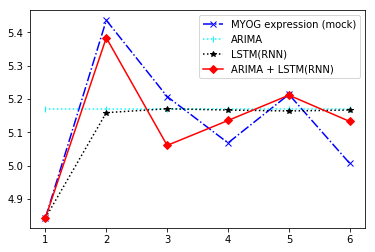

1 CCT2
matrix[gene_idx]: [16.286413 16.11135  16.438822 15.991933 16.062267 15.968493]
matrix_arima_pred[gene_idx]: [16.139778 16.139778 16.139778 16.139778 16.139778 16.139778]
matrix_lstm_prediction[gene_idx]: [16.286413, 6.3619175, 6.361854, 6.3619685, 6.361808, 6.3618355]
matrix_diff[gene_idx]: [ 0.14663506 -0.02842903  0.29904366 -0.14784527 -0.07751083 -0.17128468]
nonline_test_pred: [0, -0.038991142, -0.004079528, -0.09247874, 0.0024893042, 0.00032438617]
linear_nonline_test_pred: [16.286413, 16.100786, 16.135698, 16.0473, 16.142267, 16.140102]
mae:  0.1451247533162435 8.127246856689453 0.10344378153483073
mse:  0.028156957851024345 79.28661600748698 0.021818430087781355
rmse:  0.16780035116478256 8.904303229758462 0.1477106295693758
r2:  -0.0004132496471709324 -2816.043715917337 0.22479386225586595


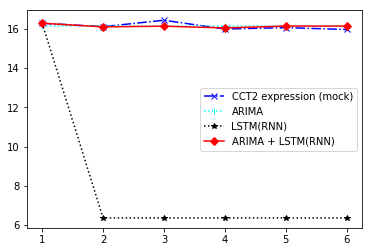

2 KLC1
matrix[gene_idx]: [5.3860283 5.8300967 5.6281824 5.678913  5.461743  5.2544403]
matrix_arima_pred[gene_idx]: [5.4595685 5.4595685 5.4595685 5.4595685 5.4595685 5.4595685]
matrix_lstm_prediction[gene_idx]: [5.3860283, 5.103569, 5.1038737, 5.1037583, 5.1037908, 5.103635]
matrix_diff[gene_idx]: [-0.07354021  0.37052822  0.16861391  0.21934462  0.00217438 -0.2051282 ]
nonline_test_pred: [0, 0.11626749, 0.10557792, 0.10842283, 0.10740226, 0.11327745]
linear_nonline_test_pred: [5.3860283, 5.575836, 5.5651464, 5.5679913, 5.566971, 5.572846]
mae:  0.17322158813476562 0.3891247908274333 0.14197532335917154
mse:  0.04355405660074515 0.21406951857109865 0.03223011262404422
rmse:  0.2086960866924561 0.4626764728955846 0.17952747038836206
r2:  -0.17393295892198735 -4.769916351416867 0.13128662558412962


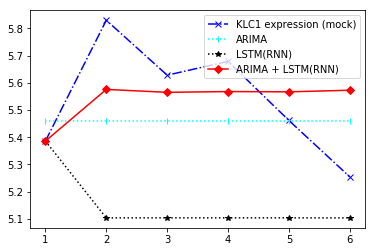

3 DOCK4
matrix[gene_idx]: [2.0491998 2.0166225 1.8045822 2.4182234 1.5114219 1.534948 ]
matrix_arima_pred[gene_idx]: [1.9466559 1.9466559 1.9466559 1.9466559 1.9466559 1.9466559]
matrix_lstm_prediction[gene_idx]: [2.0491998, 1.8724483, 1.866024, 1.8213369, 1.9385287, 1.7495527]
matrix_diff[gene_idx]: [ 0.10254395  0.06996667 -0.14207363  0.4715675  -0.43523395 -0.41170788]
nonline_test_pred: [0, -0.08418332, -0.07083651, -0.0070051327, -0.3054614, 0.02431883]
linear_nonline_test_pred: [2.0491998, 1.8624725, 1.8758193, 1.9396508, 1.6411945, 1.9709747]
mae:  0.27218226591746014 0.2407023310661316 0.21162648995717367
mse:  0.10281723372948666 0.10155169301045437 0.077471480704844
rmse:  0.320651264974094 0.3186717637483032 0.2783369912621102
r2:  -0.03321080092020101 -0.02049337707519938 0.2214887745557964


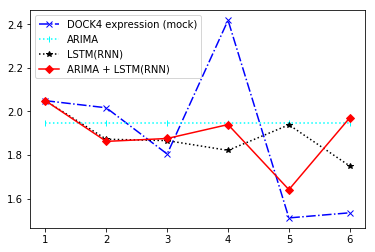

4 SFRP4
matrix[gene_idx]: [2.67827   2.8483293 2.4794686 2.6151497 3.10478   3.9762654]
matrix_arima_pred[gene_idx]: [2.9503722 2.9503722 2.9503722 2.9503722 2.9503722 2.9503722]
matrix_lstm_prediction[gene_idx]: [2.67827, 2.9738805, 3.0697443, 2.8582366, 2.9376004, 3.2096193]
matrix_diff[gene_idx]: [-0.27210212 -0.10204291 -0.47090364 -0.33522248  0.15440774  1.0258932 ]
nonline_test_pred: [0, -0.10933755, 0.17544945, -0.33734846, -0.19425683, 0.7204046]
linear_nonline_test_pred: [2.67827, 2.8410347, 3.1258216, 2.6130238, 2.7561154, 3.6707768]
mae:  0.3934286832809448 0.3154565890630086 0.21832112471262613
mse:  0.249145877858003 0.17316252024223408 0.10545336036307162
rmse:  0.4991451470844958 0.4161280094420875 0.3247358316587063
r2:  6.920030333201765e-07 0.3049758563056132 0.5767407901922907


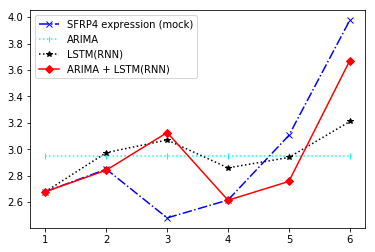

5 YIPF2
matrix[gene_idx]: [5.614777  5.680052  5.54409   5.5073853 5.419738  5.1400065]
matrix_arima_pred[gene_idx]: [4.3931746 4.3931746 4.3931746 4.3931746 4.3931746 4.3931746]
matrix_lstm_prediction[gene_idx]: [5.614777, 5.354286, 5.3547072, 5.3538027, 5.35354, 5.3528786]
matrix_diff[gene_idx]: [1.2216024 1.2868772 1.1509151 1.1142106 1.0265632 0.7468319]
nonline_test_pred: [0, 1.1051985, 1.1457165, 1.060843, 1.0376288, 0.9817397]
linear_nonline_test_pred: [5.614777, 5.498373, 5.5388913, 5.4540176, 5.4308033, 5.374914]
mae:  1.0911667346954346 0.15796677271525064 0.08103632926940918
mse:  1.2210043668746948 0.035878874749566116 0.015197723130161952
rmse:  1.104990663704764 0.18941719760773076 0.12327904578703532
r2:  -39.21796786595756 -0.18179383374216163 0.49941084809625436


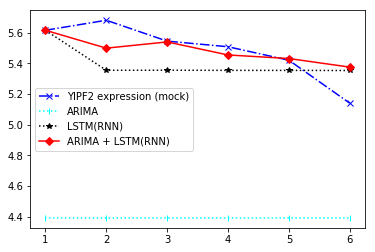

6 NTN4
matrix[gene_idx]: [11.389869 10.873434 11.095303 10.680386 11.34457  12.140218]
matrix_arima_pred[gene_idx]: [11.159024 11.159024 11.159024 11.159024 11.159024 11.159024]
matrix_lstm_prediction[gene_idx]: [11.389869, 2.389634, 2.389634, 2.389634, 2.389634, 2.389634]
matrix_diff[gene_idx]: [ 0.2308445  -0.28559017 -0.06372166 -0.47863865  0.18554592  0.98119354]
nonline_test_pred: [0, 0.16769329, 0.0010002628, 0.054777734, -0.022351563, 0.14760579]
linear_nonline_test_pred: [11.389869, 11.326717, 11.160025, 11.213802, 11.136673, 11.30663]
mae:  0.37092240651448566 7.364289919535319 0.3488178253173828
mse:  0.22752906607153514 65.2941411336263 0.2053796291196098
rmse:  0.4770000692573694 8.08047901634713 0.4531882932287746
r2:  -0.04124749229385194 -297.8073651016262 0.060115582235984344


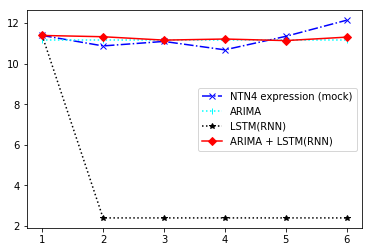

7 RABGEF1
matrix[gene_idx]: [7.343841  7.271766  6.457226  7.0219164 6.4922924 6.3236322]
matrix_arima_pred[gene_idx]: [6.938089 6.938089 6.938089 6.938089 6.938089 6.938089]
matrix_lstm_prediction[gene_idx]: [7.343841, 6.54734, 6.5471296, 6.5437922, 6.546309, 6.543981]
matrix_diff[gene_idx]: [ 0.40575218  0.3336773  -0.4808631   0.0838275  -0.4457965  -0.61445665]
nonline_test_pred: [0, -0.15454945, -0.16598985, -0.30312207, -0.2068251, -0.29707453]
linear_nonline_test_pred: [7.343841, 6.7835393, 6.772099, 6.634967, 6.7312636, 6.6410146]
mae:  0.39406220118204754 0.26113661130269367 0.2910672028859456
mse:  0.18175387204003832 0.1354917063144967 0.10751323215663433
rmse:  0.42632601614262094 0.3680919807799359 0.327892104443877
r2:  -0.08548956952293674 0.19080219689156186 0.3578981796546492


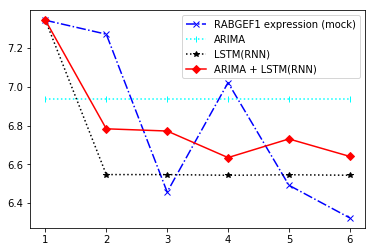

8 KRT31
matrix[gene_idx]: [5.663152  6.2683764 6.065653  5.940145  6.3409314 5.64787  ]
matrix_arima_pred[gene_idx]: [6.0746117 6.0746117 6.0746117 6.0746117 6.0746117 6.0746117]
matrix_lstm_prediction[gene_idx]: [5.663152, 5.327307, 5.328901, 5.328473, 5.3281593, 5.329033]
matrix_diff[gene_idx]: [-0.41145945  0.19376469 -0.00895882 -0.13446665  0.26631975 -0.4267416 ]
nonline_test_pred: [0, 0.26783147, -0.19717164, -0.0021462487, 0.100139275, -0.27416888]
linear_nonline_test_pred: [5.663152, 6.342443, 5.87744, 6.0724654, 6.174751, 5.8004427]
mae:  0.24028515815734863 0.6035170555114746 0.11889219284057617
mse:  0.079673294123495 0.4883202736576398 0.01821884062762062
rmse:  0.2822645817730149 0.698799165467189 0.13497718558193683
r2:  -0.10476699918776844 -5.771153738605273 0.747373644954876


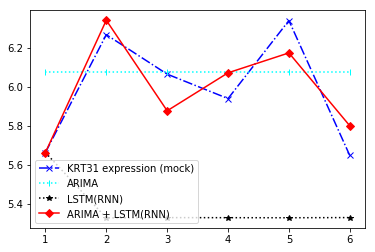

9 RBFOX2
matrix[gene_idx]: [7.7717156 7.61737   7.0379815 7.7228284 7.548638  7.6513243]
matrix_arima_pred[gene_idx]: [7.4894414 7.4894414 7.4894414 7.4894414 7.4894414 7.4894414]
matrix_lstm_prediction[gene_idx]: [7.7717156, 5.820758, 5.8206415, 5.8200192, 5.8207226, 5.8205843]
matrix_diff[gene_idx]: [ 0.28227425  0.12792873 -0.45145988  0.233387    0.05919647  0.16188288]
nonline_test_pred: [0, -0.036059864, -0.014625949, 0.21279536, -0.030894417, -8.122437e-05]
linear_nonline_test_pred: [7.7717156, 7.4533815, 7.4748154, 7.7022367, 7.458547, 7.4893603]
mae:  0.21935486793518066 1.4125694433848064 0.14557814598083496
mse:  0.06400671942780416 2.4446191787719727 0.042081460288803406
rmse:  0.25299549290017825 1.5635277991682694 0.20513766180007856
r2:  -0.08002601659084707 -40.249611561622565 0.28993280183174885


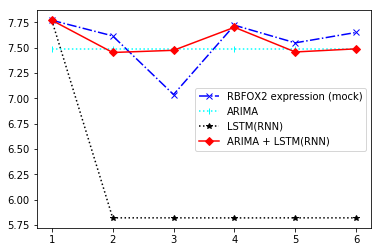

10 KRTAP2-4
matrix[gene_idx]: [12.155077 12.886301 12.22853  12.390555 12.369606 11.847402]
matrix_arima_pred[gene_idx]: [12.355506 12.355506 12.355506 12.355506 12.355506 12.355506]
matrix_lstm_prediction[gene_idx]: [12.155077, 8.428575, 8.429775, 8.428717, 8.429012, 8.428976]
matrix_diff[gene_idx]: [-0.20042896  0.5307951  -0.12697601  0.03504944  0.01410007 -0.5081043 ]
nonline_test_pred: [0, 0.20789383, -0.29079986, 0.11479968, -0.05447308, -0.035371892]
linear_nonline_test_pred: [12.155077, 12.563399, 12.064706, 12.470305, 12.301033, 12.320134]
mae:  0.23590898513793945 3.262889862060547 0.1846302350362142
mse:  0.09960589947877452 12.868656794230143 0.060940372835223876
rmse:  0.3156040232297024 3.5872910105301106 0.24686103952471697
r2:  -0.018550546508447674 -130.59238036283054 0.3768356053149964


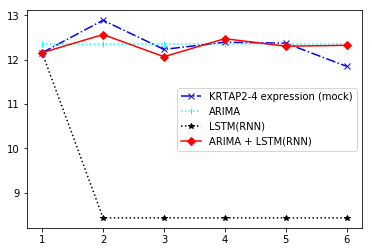

11 PSMD9
matrix[gene_idx]: [6.1115046 5.989136  5.947447  5.410118  4.748293  4.8825045]
matrix_arima_pred[gene_idx]: [5.435251 5.435251 5.435251 5.435251 5.435251 5.435251]
matrix_lstm_prediction[gene_idx]: [6.1115046, 5.5775023, 5.5318785, 5.5162835, 5.3127775, 5.054613]
matrix_diff[gene_idx]: [ 0.6762533   0.553885    0.5121956  -0.02513313 -0.6869583  -0.5527468 ]
nonline_test_pred: [0, 0.5250969, 0.29262453, 0.21277234, -0.5674211, -0.66947544]
linear_nonline_test_pred: [6.1115046, 5.960348, 5.7278757, 5.6480236, 4.8678303, 4.7657757]
mae:  0.5011953512827555 0.2783268292744954 0.1204218069712321
mse:  0.30075397329831804 0.11694581791137655 0.02225900735356845
rmse:  0.548410405899011 0.34197341696596323 0.14919452856444987
r2:  -0.021510804209007084 0.6027935551659811 0.924397286415617


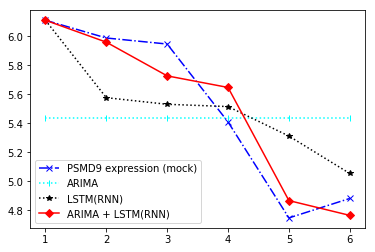

12 CLDN11
matrix[gene_idx]: [1.9485234 1.0977306 3.2568276 1.7273084 2.4397357 3.4297996]
matrix_arima_pred[gene_idx]: [2.1373765 2.1373765 2.1373765 2.1373765 2.1373765 2.1373765]
matrix_lstm_prediction[gene_idx]: [1.9485234, 2.3564677, 2.0319457, 2.515128, 2.2780216, 2.5142252]
matrix_diff[gene_idx]: [-0.18885314 -1.0396459   1.119451   -0.41006815  0.3023591   1.292423  ]
nonline_test_pred: [0, 0.25805533, 0.70723206, -0.02993349, 0.36163968, 0.08252957]
linear_nonline_test_pred: [1.9485234, 2.395432, 2.8446085, 2.107443, 2.4990163, 2.219906]
mae:  0.7254667282104492 0.7247878114382426 0.5598715345064799
mse:  0.716605644673109 0.7616403441255292 0.5776353566131244
rmse:  0.8465256314330412 0.8727200834892762 0.7600232605737303
r2:  -0.0469568090339445 -0.11275225117844001 0.15607799877053474


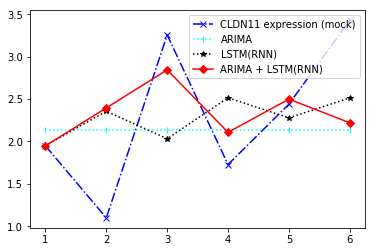

13 RCOR3
matrix[gene_idx]: [7.861074 7.822852 8.466575 7.981876 8.021598 8.311894]
matrix_arima_pred[gene_idx]: [8.101241 8.101241 8.101241 8.101241 8.101241 8.101241]
matrix_lstm_prediction[gene_idx]: [7.861074, 5.8438826, 5.8438826, 5.843884, 5.843883, 5.8438835]
matrix_diff[gene_idx]: [-0.24016714 -0.27838898  0.36533356 -0.11936522 -0.07964325  0.2106533 ]
nonline_test_pred: [0, 0.06695897, 0.07660502, -0.10349421, 0.0351046, 0.024237154]
linear_nonline_test_pred: [7.861074, 8.1682005, 8.177846, 7.997747, 8.136346, 8.125478]
mae:  0.2155919075012207 1.8975632190704346 0.15851879119873047
mse:  0.055602535450210176 4.366560498873393 0.04179998533800244
rmse:  0.23580189874174076 2.089631665838119 0.20445044714551847
r2:  -0.010111909016413234 -78.32578479811018 0.24063421488330472


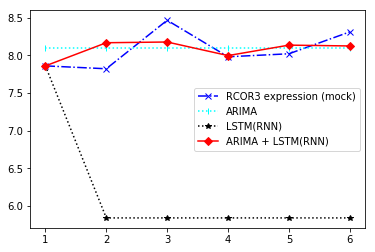

14 CLIC3
matrix[gene_idx]: [6.2876124 6.1250815 6.2933187 6.5594773 6.8738065 7.5614667]
matrix_arima_pred[gene_idx]: [9.873875 9.873875 9.873875 9.873875 9.873875 9.873875]
matrix_lstm_prediction[gene_idx]: [6.2876124, 5.3757515, 5.3750706, 5.375774, 5.376699, 5.377552]
matrix_diff[gene_idx]: [-3.5862622 -3.7487931 -3.580556  -3.3143973 -3.0000682 -2.312408 ]
nonline_test_pred: [0, -3.2869546, -3.3981264, -3.2830448, -3.100044, -2.8818054]
linear_nonline_test_pred: [6.2876124, 6.58692, 6.475748, 6.59083, 6.7738304, 6.9920692]
mae:  3.2570807933807373 1.0887173016866047 0.22416559855143228
mse:  10.84466258684794 1.6361071666081746 0.09696110978256911
rmse:  3.293123530456752 1.2791040483901905 0.31138578930736244
r2:  -44.93489703628837 -5.930083221733875 0.5893003992776953


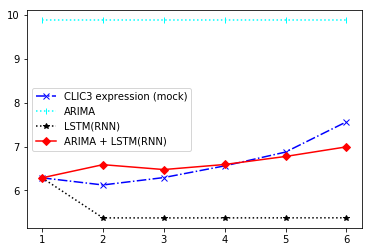

15 TRIM14
matrix[gene_idx]: [7.51602   7.059915  7.516182  7.307054  7.1039376 6.8912663]
matrix_arima_pred[gene_idx]: [7.232391 7.232391 7.232391 7.232391 7.232391 7.232391]
matrix_lstm_prediction[gene_idx]: [7.51602, 7.122377, 7.1201763, 7.1223774, 7.1214576, 7.1204214]
matrix_diff[gene_idx]: [ 0.28362894 -0.17247581  0.28379107  0.07466316 -0.12845325 -0.34112453]
nonline_test_pred: [0, -0.07997908, -0.031669226, -0.07999435, -0.059006114, -0.036675252]
linear_nonline_test_pred: [7.51602, 7.152412, 7.2007217, 7.1523967, 7.1733847, 7.1957154]
mae:  0.2140227953592936 0.1483031908671061 0.15608509381612143
mse:  0.05486190505325794 0.041274399981678776 0.03825030825100839
rmse:  0.23422618353475758 0.2031610198381539 0.1955768602135958
r2:  3.0308482992236208e-06 0.2476696745188447 0.302791394447663


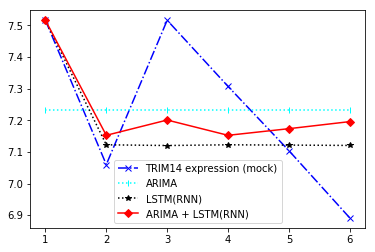

16 NAV1
matrix[gene_idx]: [6.763491  6.398753  7.0044837 7.371407  7.628432  7.6779933]
matrix_arima_pred[gene_idx]: [7.1162333 7.1162333 7.1162333 7.1162333 7.1162333 7.1162333]
matrix_lstm_prediction[gene_idx]: [6.763491, 6.6506524, 6.6485987, 6.65175, 6.653106, 6.653872]
matrix_diff[gene_idx]: [-0.3527422  -0.7174802  -0.11174965  0.25517368  0.51219845  0.56175995]
nonline_test_pred: [0, -0.18309684, -0.35834268, 0.0035599694, 0.3740883, 0.6612473]
linear_nonline_test_pred: [6.763491, 6.9331365, 6.7578907, 7.1197934, 7.4903216, 7.7774806]
mae:  0.4185173511505127 0.5544813474019369 0.2116978963216146
mse:  0.21578799545144042 0.4513496508200963 0.07310919184237719
rmse:  0.4645298649725768 0.6718256104228956 0.2703871147861473
r2:  -0.002794749940303154 -1.0974802573372737 0.6602521210758812


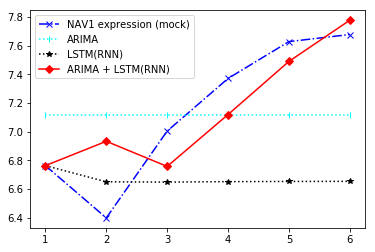

17 SFXN3
matrix[gene_idx]: [8.612884 9.029579 9.469257 9.323017 9.472071 9.387873]
matrix_arima_pred[gene_idx]: [9.066122 9.066122 9.066122 9.066122 9.066122 9.066122]
matrix_lstm_prediction[gene_idx]: [8.612884, 6.344372, 6.3448887, 6.345299, 6.3451757, 6.3453016]
matrix_diff[gene_idx]: [-0.4532385  -0.03654289  0.4031353   0.25689507  0.40594864  0.32175064]
nonline_test_pred: [0, 0.074611545, 0.22868368, 0.36405545, 0.32334426, 0.36479276]
linear_nonline_test_pred: [8.612884, 9.140734, 9.294806, 9.430178, 9.389466, 9.430915]
mae:  0.3129185040791829 2.492793401082357 0.08640225728352864
mse:  0.11726523821319763 7.478922684987386 0.010491380041154722
rmse:  0.3424401235445368 2.734761906453172 0.10242743793122389
r2:  -0.23609003949724094 -77.83514311611599 0.8894106167603215


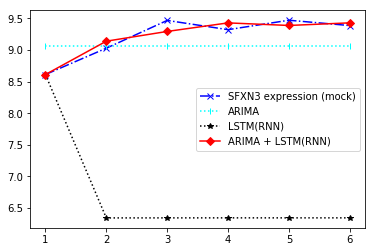

18 HIST1H4J
matrix[gene_idx]: [8.947254 8.838871 8.921991 9.059411 8.799322 9.004597]
matrix_arima_pred[gene_idx]: [8.926242 8.926242 8.926242 8.926242 8.926242 8.926242]
matrix_lstm_prediction[gene_idx]: [8.947254, 7.29912, 7.2989526, 7.299082, 7.2992806, 7.2988887]
matrix_diff[gene_idx]: [ 0.02101231 -0.08737087 -0.00425053  0.13316917 -0.12691975  0.07835484]
nonline_test_pred: [0, -0.020899067, 0.052135278, -0.0025626877, -0.11152501, 0.075085595]
linear_nonline_test_pred: [8.947254, 8.905343, 8.978377, 8.923679, 8.814717, 9.0013275]
mae:  0.0751795768737793 1.354811429977417 0.04620901743570963
mse:  0.00801256408400756 2.2105686267217 0.0043781176961298724
rmse:  0.08951292691007014 1.4867981122942349 0.06616734614694678
r2:  -0.0006586787135212102 -275.0695150801882 0.453233518867483


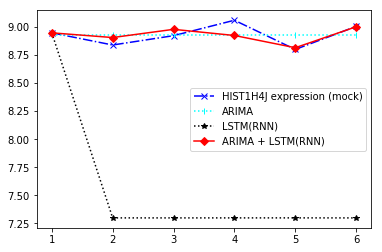

19 MS4A3
matrix[gene_idx]: [1.392404   2.1097987  1.9949     1.2457902  1.5370411  0.91961485]
matrix_arima_pred[gene_idx]: [1.6168218 1.6168218 1.6168218 1.6168218 1.6168218 1.6168218]
matrix_lstm_prediction[gene_idx]: [1.392404, 1.489374, 1.6754974, 1.6482766, 1.4449795, 1.5305967]
matrix_diff[gene_idx]: [-0.2244178   0.4929769   0.37807822 -0.37103152 -0.0797807  -0.6972069 ]
nonline_test_pred: [0, -0.08123807, -0.0037976317, -0.02823719, -0.07537684, -0.08016829]
linear_nonline_test_pred: [1.392404, 1.5355837, 1.6130241, 1.5885845, 1.5414449, 1.5366535]
mae:  0.37391534447669983 0.34089282155036926 0.32005460063616437
mse:  0.1777432597397516 0.1717856894247234 0.1623026691134631
rmse:  0.42159608601094917 0.41447037219169647 0.40286805422304595
r2:  -0.04089187572722919 -0.006003427360375291 0.04953059859256237


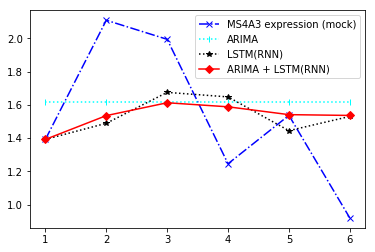

0 MYOG
matrix[gene_idx]: [5.0517397 5.554034  5.423724  5.6839457 7.361013  7.141904 ]
matrix_arima_pred[gene_idx]: [6.4115863 6.4115863 6.4115863 6.4115863 6.4115863 6.4115863]
matrix_lstm_prediction[gene_idx]: [5.0517397, 5.8084316, 5.8100815, 5.8097377, 5.810378, 5.8119974]
matrix_diff[gene_idx]: [-1.3598466  -0.85755205 -0.9878621  -0.7276406   0.94942665  0.7303176 ]
nonline_test_pred: [0, -0.7702533, -0.3330364, -0.45511442, -0.20811445, 0.7446603]
linear_nonline_test_pred: [5.0517397, 5.641333, 6.07855, 5.956472, 6.2034717, 7.1562467]
mae:  0.9354409376780192 0.6078480084737142 0.3644224802652995
mse:  0.9207809070746104 0.7338222355271379 0.3084659755404573
rmse:  0.9595732942691821 0.8566342483972597 0.5553971331763041
r2:  -0.18084994435585267 0.058914081154928466 0.6044096622182593


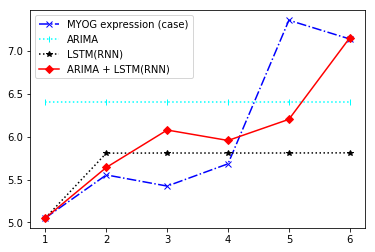

1 CCT2
matrix[gene_idx]: [16.255102  16.190649  15.745695  14.872907  14.424043  14.4390955]
matrix_arima_pred[gene_idx]: [15.322786 15.322786 15.322786 15.322786 15.322786 15.322786]
matrix_lstm_prediction[gene_idx]: [16.255102, 4.5490947, 4.54908, 4.5489616, 4.5486393, 4.5484114]
matrix_diff[gene_idx]: [ 0.9323158   0.8678627   0.42290878 -0.44987965 -0.8987436  -0.88369083]
nonline_test_pred: [0, 0.66908115, 0.53882915, -0.29275626, -0.9609924, -0.9004366]
linear_nonline_test_pred: [16.255102, 15.991867, 15.861615, 15.03003, 14.3617935, 14.42235]
mae:  0.7425669034322103 8.821366945902506 0.09180339177449544
mse:  0.5987152680754662 93.80383682250977 0.013632487006058605
rmse:  0.7737669339506995 9.685238088065248 0.11675824170506598
r2:  -3.6830689462696853e-06 -155.67578114390844 0.9772303498134111


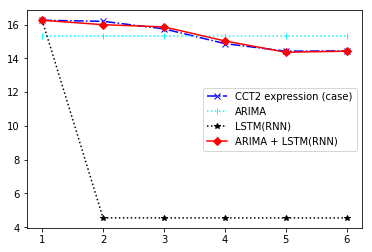

2 KLC1
matrix[gene_idx]: [5.6955624 5.6251426 4.64807   2.555943  3.009479  1.8868963]
matrix_arima_pred[gene_idx]: [4.137087 4.137087 4.137087 4.137087 4.137087 4.137087]
matrix_lstm_prediction[gene_idx]: [5.6955624, 4.328021, 4.289978, 3.7314854, 2.4297595, 2.7220898]
matrix_diff[gene_idx]: [ 1.5584755  1.4880557  0.510983  -1.5811439 -1.1276078 -2.2501907]
nonline_test_pred: [0, 1.0302737, 0.8556422, -1.3134735, -1.6662757, -1.8273758]
linear_nonline_test_pred: [5.6955624, 5.1673603, 4.992729, 2.8236134, 2.4708111, 2.309711]
mae:  1.4194094340006511 0.7076114614804586 0.3385991056760152
mse:  2.289855480194092 0.7043794567386309 0.14482292284568152
rmse:  1.5132268436008172 0.8392731717019382 0.38055607056737584
r2:  -0.024406379293711256 0.6848836901858406 0.9352109653581709


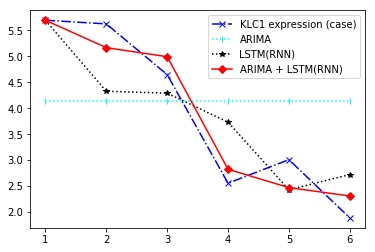

3 DOCK4
matrix[gene_idx]: [1.8697435 2.2010996 2.2231402 1.639287  1.9703754 2.2326665]
matrix_arima_pred[gene_idx]: [2.0013564 2.0013564 2.0013564 2.0013564 2.0013564 2.0013564]
matrix_lstm_prediction[gene_idx]: [1.8697435, 2.0085049, 2.134832, 2.1428645, 1.9124821, 2.0480156]
matrix_diff[gene_idx]: [-0.1316129   0.19974327  0.22178388 -0.36206937 -0.03098094  0.23131013]
nonline_test_pred: [0, 0.092373535, -0.009200105, -0.018181777, 0.12778752, 0.068125166]
linear_nonline_test_pred: [1.8697435, 2.09373, 1.9921563, 1.9831746, 2.129144, 2.0694816]
mae:  0.1962500810623169 0.1711707909901937 0.16736576954523721
mse:  0.04866097460035235 0.05598815813815842 0.03916287608444691
rmse:  0.22059232670324766 0.2366181695013264 0.19789612448061458
r2:  -0.009463464972212954 -0.16146461462669426 0.18757293878374293


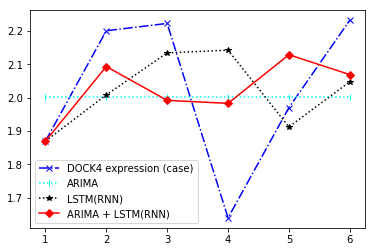

4 SFRP4
matrix[gene_idx]: [2.6862953 2.522355  2.5503526 2.118943  3.0402286 1.8047315]
matrix_arima_pred[gene_idx]: [2.4865289 2.4865289 2.4865289 2.4865289 2.4865289 2.4865289]
matrix_lstm_prediction[gene_idx]: [2.6862953, 2.4109807, 2.3878849, 2.391918, 2.3246977, 2.457271]
matrix_diff[gene_idx]: [ 0.1997664   0.03582621  0.0638237  -0.3675859   0.55369973 -0.6817974 ]
nonline_test_pred: [0, -0.22366862, -0.005941876, -0.043510742, 0.5126499, -0.6447716]
linear_nonline_test_pred: [2.6862953, 2.2628603, 2.480587, 2.4430182, 2.999179, 1.8417573]
mae:  0.317083219687144 0.3191479245821635 0.12190184990564983
mse:  0.15863567955481508 0.17518461775034666 0.03004758576086412
rmse:  0.39829094837168355 0.4185506155178208 0.17334239458616038
r2:  -0.006789942424349604 -0.11181867605993867 0.8093013676175042


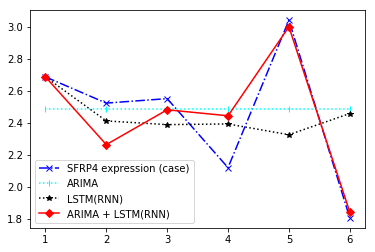

5 YIPF2
matrix[gene_idx]: [5.5648246 5.5335903 5.6882873 5.0611277 3.3467634 3.2079268]
matrix_arima_pred[gene_idx]: [4.3421397 4.3421397 4.3421397 4.3421397 4.3421397 4.3421397]
matrix_lstm_prediction[gene_idx]: [5.5648246, 4.7789073, 4.76551, 4.790413, 4.540629, 3.5491643]
matrix_diff[gene_idx]: [ 1.2226849   1.1914506   1.3461475   0.71898794 -0.99537635 -1.134213  ]
nonline_test_pred: [0, 0.83369267, 0.7727072, 1.07304, -0.11853415, -1.2860104]
linear_nonline_test_pred: [5.5648246, 5.1758323, 5.114847, 5.4151797, 4.2236056, 3.0561295]
mae:  1.1014767090479534 0.5805463393529257 0.38564829031626385
mse:  1.2534637848536174 0.5060181071360906 0.22901199385523796
rmse:  1.1195819687962187 0.71134949717849 0.4785519761271893
r2:  -0.1394060825489376 0.54002651203992 0.7918267269239126


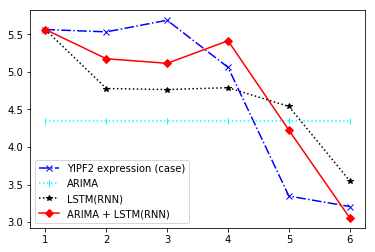

6 NTN4
matrix[gene_idx]: [11.482737 11.239597 11.193647 10.764222 10.398342  9.89022 ]
matrix_arima_pred[gene_idx]: [9.5479965 9.5479965 9.5479965 9.5479965 9.5479965 9.5479965]
matrix_lstm_prediction[gene_idx]: [11.482737, 4.074732, 4.074732, 4.074732, 4.074732, 4.074732]
matrix_diff[gene_idx]: [1.9347401  1.6916008  1.6456509  1.2162256  0.8503456  0.34222317]
nonline_test_pred: [0, 1.6034734, 1.374628, 1.3303881, 0.92260003, 0.6081926]
linear_nonline_test_pred: [11.482737, 11.15147, 10.922625, 10.878385, 10.470596, 10.156189]
mae:  1.2801310221354167 5.518728256225586 0.1352559725443522
mse:  1.9387180817623932 36.76191393534342 0.0283688564474384
rmse:  1.3923785698445639 6.063160391688762 0.16843056862528963
r2:  -5.4627645566993195 -121.54674707618794 0.9054317171293264


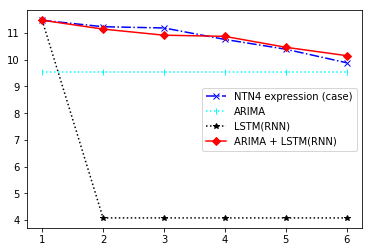

7 RABGEF1
matrix[gene_idx]: [7.251001  7.154338  7.0482354 7.7284756 8.817914  9.146999 ]
matrix_arima_pred[gene_idx]: [8.1462145 8.1462145 8.1462145 8.1462145 8.1462145 8.1462145]
matrix_lstm_prediction[gene_idx]: [7.251001, 4.560313, 4.5603113, 4.560309, 4.5603175, 4.560321]
matrix_diff[gene_idx]: [-0.8952136 -0.9918766 -1.0979791 -0.4177389  0.6716995  1.0007849]
nonline_test_pred: [0, -0.56897527, -0.72337425, -0.8877161, 0.19656104, 1.1360117]
linear_nonline_test_pred: [7.251001, 7.577239, 7.42284, 7.258498, 8.342775, 9.282227]
mae:  0.8458820978800455 2.849065065383911 0.31297485033671063
mse:  0.7696735064188639 10.35345991452535 0.13068265778323016
rmse:  0.8773103820307063 3.217679274652051 0.36150056401509273
r2:  -0.12114535624236278 -14.081373345199312 0.8096410313032864


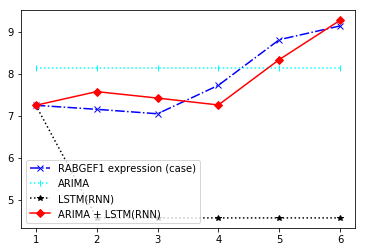

8 KRT31
matrix[gene_idx]: [ 5.839756   6.286569   8.403579  10.606074  10.565483  10.5577135]
matrix_arima_pred[gene_idx]: [8.240433 8.240433 8.240433 8.240433 8.240433 8.240433]
matrix_lstm_prediction[gene_idx]: [5.839756, 7.194512, 7.196087, 7.198767, 7.1991696, 7.199167]
matrix_diff[gene_idx]: [-2.4006767  -1.9538636   0.16314602  2.3656416   2.3250504   2.3172808 ]
nonline_test_pred: [0, -1.2112737, -0.57420844, 2.1365738, 2.363071, 2.3664339]
linear_nonline_test_pred: [5.839756, 7.029159, 7.6662245, 10.377007, 10.603504, 10.606867]
mae:  1.9209431807200115 2.041266997655233 0.2993644078572591
mse:  4.329892961618801 6.084006855885188 0.19191081169992685
rmse:  2.0808394848278904 2.4665779646881605 0.43807626242462266
r2:  -0.05362271417164477 -0.4804633447890294 0.9533010187331366


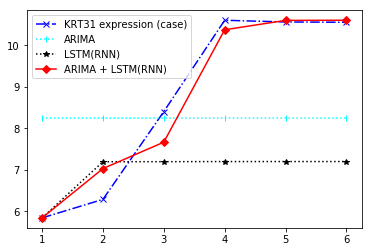

9 RBFOX2
matrix[gene_idx]: [8.001569  7.7370405 7.7389393 7.436462  6.1679134 6.0274186]
matrix_arima_pred[gene_idx]: [6.371633 6.371633 6.371633 6.371633 6.371633 6.371633]
matrix_lstm_prediction[gene_idx]: [8.001569, 6.4604087, 6.4598103, 6.459815, 6.458977, 6.4525733]
matrix_diff[gene_idx]: [ 1.6299357   1.3654075   1.3673062   1.0648289  -0.20371962 -0.34421444]
nonline_test_pred: [0, 1.2111119, 0.9384874, 0.9405104, 0.61210835, -0.396106]
linear_nonline_test_pred: [8.001569, 7.582745, 7.3101206, 7.3121433, 6.9837413, 5.975527]
mae:  0.9959020614624023 0.7081043720245361 0.26252539952596027
mse:  1.2807333798458178 0.7475456334650517 0.1485692550195381
rmse:  1.1316949146505069 0.8646072134010053 0.3854468251517167
r2:  -1.0678803652326065 -0.20699199527683732 0.7601191238030166


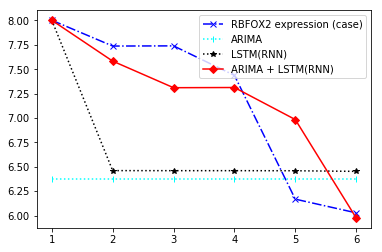

10 KRTAP2-4
matrix[gene_idx]: [12.228719 12.885876 13.056287 13.387801 14.299339 14.581514]
matrix_arima_pred[gene_idx]: [17.209078 17.209078 17.209078 17.209078 17.209078 17.209078]
matrix_lstm_prediction[gene_idx]: [12.228719, 4.417364, 4.4174166, 4.417427, 4.417443, 4.417471]
matrix_diff[gene_idx]: [-4.980359  -4.323202  -4.152791  -3.8212767 -2.9097385 -2.6275635]
nonline_test_pred: [0, -3.897933, -3.6730444, -3.5998442, -3.4539, -3.0214276]
linear_nonline_test_pred: [12.228719, 13.311145, 13.536034, 13.609234, 13.7551775, 14.187651]
mae:  3.8024884859720864 7.687282721201579 0.34407901763916016
mse:  15.11875851949056 71.29550806681316 0.15188065419594446
rmse:  3.8882847785997567 8.44366674299816 0.3897186859722593
r2:  -21.91277088562462 -107.04972110660687 0.7698219316709003


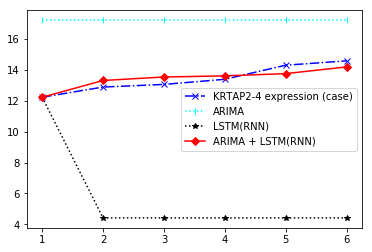

11 PSMD9
matrix[gene_idx]: [5.9434924 6.0991826 5.861625  5.2961245 2.6213214 1.8948743]
matrix_arima_pred[gene_idx]: [4.3747764 4.3747764 4.3747764 4.3747764 4.3747764 4.3747764]
matrix_lstm_prediction[gene_idx]: [5.9434924, 4.826961, 4.8440027, 4.766033, 4.3368983, 2.0583863]
matrix_diff[gene_idx]: [ 1.568716   1.7244062  1.4868488  0.9213481 -1.7534549 -2.479902 ]
nonline_test_pred: [0, 0.95876527, 1.1897255, 0.8198582, -0.24333552, -2.487134]
linear_nonline_test_pred: [5.9434924, 5.333542, 5.564502, 5.1946344, 4.1314406, 1.8876424]
mae:  1.6557793617248535 0.7831707000732422 0.44693422317504883
mse:  2.95309450229009 0.9841733776653806 0.49421674321880954
rmse:  1.7184570120576452 0.9920551283398421 0.7030055072464294
r2:  -0.020689134525226027 0.659836462296401 0.8291820124575444


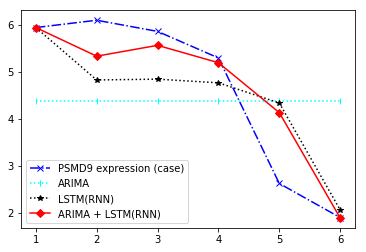

12 CLDN11
matrix[gene_idx]: [2.594087  1.9972739 1.9909699 1.5555061 1.267204  1.7361597]
matrix_arima_pred[gene_idx]: [1.8428051 1.8428051 1.8428051 1.8428051 1.8428051 1.8428051]
matrix_lstm_prediction[gene_idx]: [2.594087, 1.9668128, 1.7589834, 1.7566683, 1.5873091, 1.4615743]
matrix_diff[gene_idx]: [ 0.75128174  0.15446877  0.14816475 -0.28729904 -0.5756011  -0.10664546]
nonline_test_pred: [0, 0.18312116, -0.14149779, -0.14429095, -0.275356, -0.289194]
linear_nonline_test_pred: [2.594087, 2.0259264, 1.7013073, 1.6985142, 1.5674491, 1.5536112]
mae:  0.3372434775034587 0.176383376121521 0.15735278526941934
mse:  0.17257804702967405 0.045512707952487595 0.038107958767795935
rmse:  0.4154251401030925 0.21333707589748105 0.1952125988961674
r2:  -0.0011461132491457082 0.735975279276154 0.7789311244339345


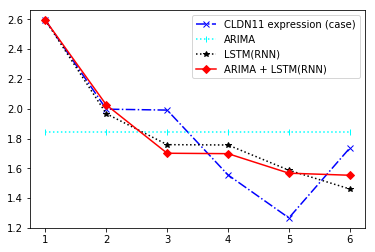

13 RCOR3
matrix[gene_idx]: [7.8899136 7.873799  7.636978  6.9959183 7.5656786 8.9534645]
matrix_arima_pred[gene_idx]: [7.719446 7.719446 7.719446 7.719446 7.719446 7.719446]
matrix_lstm_prediction[gene_idx]: [7.8899136, 4.141522, 4.141509, 4.141307, 4.1405144, 4.141238]
matrix_diff[gene_idx]: [ 0.17046738  0.15435266 -0.08246803 -0.7235279  -0.15376759  1.2340183 ]
nonline_test_pred: [0, 0.09671599, 0.099503115, 0.120822504, -0.016361259, 0.1195755]
linear_nonline_test_pred: [7.8899136, 7.816162, 7.818949, 7.8402686, 7.703085, 7.8390217]
mae:  0.41976698239644367 3.0532913208007812 0.38930122057596844
mse:  0.3549372055567801 11.53104559580485 0.33503771813896793
rmse:  0.5957660661339987 3.3957393297785465 0.5788244277317328
r2:  -0.02889837199793699 -32.42640291075273 0.028786620973319632


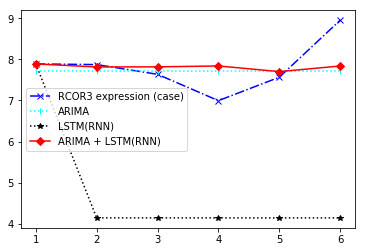

14 CLIC3
matrix[gene_idx]: [6.4725237 6.038771  6.080055  5.984277  4.5631404 3.487478 ]
matrix_arima_pred[gene_idx]: [4.5916724 4.5916724 4.5916724 4.5916724 4.5916724 4.5916724]
matrix_lstm_prediction[gene_idx]: [6.4725237, 5.3946667, 5.277374, 5.297941, 5.249939, 4.392474]
matrix_diff[gene_idx]: [ 1.8808513   1.4470987   1.4883828   1.3926044  -0.02853203 -1.1041944 ]
nonline_test_pred: [0, 1.4123826, 0.9432311, 0.99890137, 0.8688302, -0.6697465]
linear_nonline_test_pred: [6.4725237, 6.004055, 5.5349035, 5.590574, 5.4605026, 3.921926]
mae:  1.2236105998357136 0.6208193699518839 0.38423017660776776
mse:  1.8343976531371784 0.47015582025051117 0.24123361768821874
rmse:  1.354399369882155 0.6856790942201105 0.49115539057229
r2:  -0.6398721117587136 0.5797010443775354 0.7843475860378292


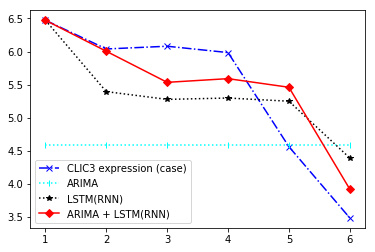

15 TRIM14
matrix[gene_idx]: [7.5064507 7.3254385 7.584729  7.018318  5.349646  3.6088865]
matrix_arima_pred[gene_idx]: [7.8545966 7.8545966 7.8545966 7.8545966 7.8545966 7.8545966]
matrix_lstm_prediction[gene_idx]: [7.5064507, 5.43397, 5.4337945, 5.434029, 5.381168, 5.079869]
matrix_diff[gene_idx]: [-0.34814596 -0.5291581  -0.26986742 -0.83627844 -2.5049505  -4.2457104 ]
nonline_test_pred: [0, -1.0074083, -1.2339925, -0.91525686, -1.6448119, -3.6573567]
linear_nonline_test_pred: [7.5064507, 6.8471885, 6.620604, 6.9393396, 6.2097845, 4.19724]
mae:  1.4556851387023926 1.1881994009017944 0.4949742555618286
mse:  4.24570620059967 2.1464879735334157 0.37508264160715044
rmse:  2.0605111503216067 1.4650897493100605 0.6124399085683022
r2:  -0.9963944880597588 -0.009310714538707021 0.8236305380326021


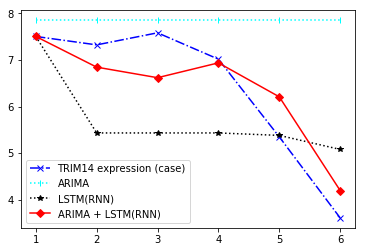

16 NAV1
matrix[gene_idx]: [7.062596  6.436601  6.810388  6.3114095 5.299836  4.0052075]
matrix_arima_pred[gene_idx]: [5.756811 5.756811 5.756811 5.756811 5.756811 5.756811]
matrix_lstm_prediction[gene_idx]: [7.062596, 5.547858, 5.538497, 5.5469427, 5.5266743, 5.4277487]
matrix_diff[gene_idx]: [ 1.3057847   0.67979     1.053577    0.55459833 -0.45697498 -1.7516036 ]
nonline_test_pred: [0, 0.77904284, 0.29228908, 0.6627496, 0.104108065, -1.7505188]
linear_nonline_test_pred: [7.062596, 6.535854, 6.0491004, 6.419561, 5.860919, 4.0062923]
mae:  0.9670547644297282 0.7624133427937826 0.2551432450612386
mse:  1.1436222021778424 0.8445098648468653 0.1526536532647166
rmse:  1.0694027315178518 0.9189721784944664 0.3907091671111859
r2:  -0.04888178613921723 0.22545136517468423 0.8599925428239689


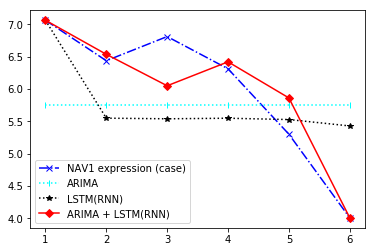

17 SFXN3
matrix[gene_idx]: [8.716321 8.843724 8.702236 8.698815 8.279599 7.823536]
matrix_arima_pred[gene_idx]: [1.718273 1.718273 1.718273 1.718273 1.718273 1.718273]
matrix_lstm_prediction[gene_idx]: [8.716321, 4.280727, 4.280885, 4.2807083, 4.2807035, 4.28006]
matrix_diff[gene_idx]: [6.998048  7.125451  6.983963  6.980542  6.561326  6.1052628]
nonline_test_pred: [0, 5.866099, 5.866488, 5.866053, 5.866042, 5.8643622]
linear_nonline_test_pred: [8.716321, 7.584372, 7.584761, 7.5843263, 7.5843153, 7.5826354]
mae:  6.792432149251302 3.4908045132954917 0.7379167874654134
mse:  46.262277603149414 14.739391167958578 0.7697095243881146
rmse:  6.8016378618057445 3.8391914732087247 0.8773309092857235
r2:  -368.6734895233726 -116.77980784366503 -5.150609536365737


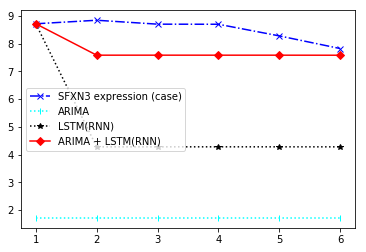

18 HIST1H4J
matrix[gene_idx]: [ 8.923256  8.719039  8.86104  10.022875 10.143035 10.559126]
matrix_arima_pred[gene_idx]: [9.527918 9.527918 9.527918 9.527918 9.527918 9.527918]
matrix_lstm_prediction[gene_idx]: [8.923256, 6.456319, 6.4562836, 6.4563093, 6.456417, 6.456422]
matrix_diff[gene_idx]: [-0.60466194 -0.8088789  -0.66687775  0.49495697  0.6151171   1.031208  ]
nonline_test_pred: [0, -0.2754396, -0.39979452, -0.31738195, 0.7784735, 0.8773404]
linear_nonline_test_pred: [8.923256, 9.252479, 9.128123, 9.210536, 10.306392, 10.405258]
mae:  0.7036167780558268 2.670560677846273 0.32168102264404297
mse:  0.5252280806501707 9.00774614016215 0.1776910542200009
rmse:  0.7247262108204522 3.001290745689619 0.42153416732217674
r2:  -0.00019562157956776183 -16.15351593261678 0.6616216440585225


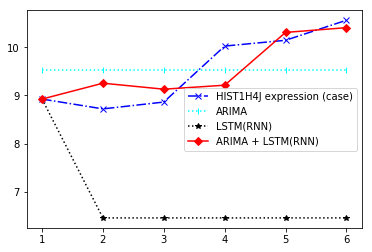

19 MS4A3
matrix[gene_idx]: [1.0058062 1.5675424 1.4357582 1.6418087 1.5499033 2.4962199]
matrix_arima_pred[gene_idx]: [1.6161683 1.6161683 1.6161683 1.6161683 1.6161683 1.6161683]
matrix_lstm_prediction[gene_idx]: [1.0058062, 1.5212947, 1.8008637, 1.738911, 1.8349243, 1.7926861]
matrix_diff[gene_idx]: [-0.61036205 -0.04862583 -0.18041003  0.02564049 -0.06626499  0.8800516 ]
nonline_test_pred: [0, -0.03150177, 0.16640565, 0.13201426, 0.18260473, 0.16222474]
linear_nonline_test_pred: [1.0058062, 1.5846665, 1.7825739, 1.7481825, 1.798773, 1.778393]
mae:  0.3018924991289775 0.24950172503789267 0.23950169483820596
mse:  0.19783223530005975 0.12017775350250304 0.11818354512797669
rmse:  0.44478335771480904 0.34666663165424944 0.3437783371999706
r2:  8.523695876894166e-07 0.3925274569922198 0.402607748870331


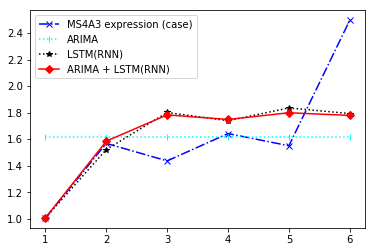

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Mean Absolute Error (MAE)
def calculate_mae(data, prediction):
    size = len(data)
    mae = 0
    for i in range(size):
        mae += np.abs(data[i] - prediction[i])
    return mae/size

# Mean Square Error (MSE)
def calculate_mse(data, prediction):
    size = len(data)
    mse = 0
    for i in range(size):
        mse += (data[i] - prediction[i])*(data[i] - prediction[i])
    return mse/size

#Root Mean Square Error (RMSE)
def calculate_rmse(data, prediction):
    size = len(data)
    rmse = 0
    for i in range(size):
        rmse += (data[i] - prediction[i])*(data[i] - prediction[i]) / size
    return np.sqrt(rmse)

#R² Score
#Root Mean Square Error (RMSE)
def calculate_r2(data, prediction):
    size = len(data)
    data_mean = np.mean(data)
    sqr_err = 0
    sqr_diff = 0
    for i in range(size):
        sqr_err += (data[i] - prediction[i])*(data[i] - prediction[i]) 
        sqr_diff+= (data[i] - data_mean)*(data[i] - data_mean)
    return 1 - sqr_err /(sqr_diff + 0.000001)

#Adjusted R² Score
#def calculate_ar2(data, prediction):
    #https://medium.com/analytics-vidhya/evaluation-metrics-for-regression-algorithms-along-with-their-implementation-in-python-9ec502729dad
    
def regression_performance(exp_data, arima_pred, lstm_pred, arima_lstm_pre):
    arima_mae = calculate_mae(exp_data, arima_pred)
    lstm_mae = calculate_mae(exp_data, lstm_pred)
    larima_lstm_mae = calculate_mae(exp_data, arima_lstm_pre)
    print('mae: ', arima_mae, lstm_mae, larima_lstm_mae)

    arima_mse = calculate_mse(exp_data, arima_pred)
    lstm_mse = calculate_mse(exp_data, lstm_pred)
    larima_lstm_mse = calculate_mse(exp_data, arima_lstm_pre)
    print('mse: ', arima_mse, lstm_mse, larima_lstm_mse)
    
    arima_rmse = calculate_rmse(exp_data, arima_pred)
    lstm_rmse = calculate_rmse(exp_data, lstm_pred)
    larima_lstm_rmse = calculate_rmse(exp_data, arima_lstm_pre)
    print('rmse: ', arima_rmse, lstm_rmse, larima_lstm_rmse)

    arima_r2 = calculate_r2(exp_data, arima_pred)
    lstm_r2 = calculate_r2(exp_data, lstm_pred)
    larima_lstm_r2 = calculate_r2(exp_data, arima_lstm_pre)
    print('r2: ', arima_r2, lstm_r2, larima_lstm_r2)
#https://www.youtube.com/watch?v=c0k-YLQGKjY
#from keras.preprocessing.sequence import TimeseriesGenerator
#https://www.youtube.com/watch?v=S8tpSG6Q2H0
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, gene_idx, look_back=1):
    dataset_tr = dataset.transpose()
    #print('dataset_tr:', dataset_tr)
    dataX, dataY = [], []
    for i in range(len(dataset_tr)-look_back):
        #print(i)
        if i+look_back >= len(dataset_tr) and i == len(dataset_tr) -1:
            row = dataset_tr[i, gene_idx]   
        else:
            row = dataset_tr[i:(i+look_back), gene_idx]   
        dataX.append(row)
        label = dataset_tr[i + look_back, gene_idx]
        dataY.append(label)
    return np.array(dataX), np.array(dataY)

def plot_arima(matrix, exp_type):
    matrix_tr = matrix_diff.transpose()
    plt.figure(figsize=(8,7))
    plt.plot(matrix_tr)
    plt.xlabel('Time Point')
    plt.ylabel('Expression Value')
    plt.title(''.join(['Gene expression values across all time points (', exp_type, ')']))
    plt.show()
    
    plt.figure(figsize=(5,4))
    plt.boxplot(matrix_tr)
    plt.xlabel('Time Point')
    plt.ylabel('Expression Value')
    plt.title(''.join(['Gene expression values across all time points (', exp_type, ')']))
    plt.show()
    
def perform_one_arima_deeplearning_hybrid(matrix, matrix_arima_pred, matrix_lstm_prediction, exp_type, num_proteins, time_points, id2protein):
    matrix_diff = matrix - matrix_arima_pred    #matrix.transpose().as_matrix()
    linear_pred = matrix_arima_pred
    dataset = matrix_diff  
    train, test = dataset, dataset
    look_back = 1
    nonline_pred = []
    linear_nonlinear_pred = []
    for gene_idx in range(20):  #num_proteins):  
        #if gene_idx % 100 == 0:
        gene_id = id2protein[gene_idx]
        print(gene_idx, gene_id)
        # split into train and test sets
        trainX, trainY = create_dataset(train, gene_idx, look_back)
        testX, testY = create_dataset(test, gene_idx, look_back)
        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (len(trainX), 1, -1))  # trainX_tr.shape[1]))
        testX = np.reshape(testX, (len(testX),1, -1))

        # create and fit the LSTM network
        model = Sequential()
        timesteps = 1
        model.add(LSTM(4, input_shape=(timesteps, look_back)))
        model.add(Dense(1)) #, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=0)
        # make predictions
        testPredict = model.predict(testX)
        testPredict_tr = testPredict.transpose()
        nonline_test_pred = [0]
        linear_nonline_test_pred = [matrix[gene_idx][0]]
        for i in range(len(testPredict_tr[0])):
            nonline_test_pred.append(testPredict_tr[0][i])
        for i in range(1,len(matrix_arima_pred[0])):
            linear_nonline_test_pred.append(matrix_arima_pred[gene_idx][i] + nonline_test_pred[i])
        nonline_pred.append(nonline_test_pred)
        linear_nonlinear_pred.append(linear_nonline_test_pred)
        print('matrix[gene_idx]:', matrix[gene_idx])
        print('matrix_arima_pred[gene_idx]:', matrix_arima_pred[gene_idx])
        print('matrix_lstm_prediction[gene_idx]:', matrix_lstm_prediction[gene_idx])
        print('matrix_diff[gene_idx]:', matrix_diff[gene_idx])
        print('nonline_test_pred:', nonline_test_pred)
        print('linear_nonline_test_pred:', linear_nonline_test_pred)
        regression_performance(matrix[gene_idx], matrix_arima_pred[gene_idx], matrix_lstm_prediction[gene_idx], linear_nonline_test_pred)
        if exp_type == 'mock':
            exp_label = ''.join([gene_id, ' expression (mock)'])
        else:
            exp_label = ''.join([gene_id, ' expression (case)'])
        plt.plot(range(1, 7), matrix[gene_idx], label=exp_label, linestyle="-.", marker='x', color='blue')
        plt.plot(range(1, 7), matrix_arima_pred[gene_idx], label='ARIMA', linestyle="dotted", marker='|', color='cyan')
        plt.plot(range(1, 7), matrix_lstm_prediction[gene_idx], label='LSTM(RNN)', linestyle=":", marker='*', color='black')
        plt.plot(range(1, 7), linear_nonline_test_pred, label='ARIMA + LSTM(RNN)', linestyle="solid", marker='D', color='red')
        plt.legend()
        plt.show()

    #prediction = linear_pred_dataset[] + nonline_pred
    return nonline_pred, linear_nonlinear_pred

# Action
matrix1 = mock_gene_expression_avg
matrix2 = exp_gene_expression_avg
mock_linear_predicton = mock_matrix_pred
exp_linear_predicton = exp_matrix_pred
mock_nonline_hybrid_pred, mock_hybrid_prediction = perform_one_arima_deeplearning_hybrid(mock_gene_expression_avg, mock_linear_predicton,mock_lstm_prediction, 'mock', common_num_proteins, time_points, id2protein)
exp_nonline_hybrid_pred, exp_hybrid_prediction = perform_one_arima_deeplearning_hybrid(exp_gene_expression_avg, exp_linear_predicton,exp_lstm_prediction, 'case', common_num_proteins, time_points, id2protein)


In [ ]:
#---Not used----
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#https://www.youtube.com/watch?v=c0k-YLQGKjY
#from keras.preprocessing.sequence import TimeseriesGenerator
#https://www.youtube.com/watch?v=S8tpSG6Q2H0
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, gene_idx, look_back=1):
    dataset_tr = dataset.transpose()
    #print('dataset_tr:', dataset_tr)
    dataX, dataY = [], []
    for i in range(len(dataset_tr)-look_back):
        #print(i)
        if i+look_back >= len(dataset_tr) and i == len(dataset_tr) -1:
            row = dataset_tr[i, gene_idx]   
        else:
            row = dataset_tr[i:(i+look_back), gene_idx]   
        dataX.append(row)
        label = dataset_tr[i + look_back, gene_idx]
        dataY.append(label)
    return np.array(dataX), np.array(dataY)

def plot_arima(matrix, exp_type):
    matrix_tr = matrix_diff.transpose()
    plt.figure(figsize=(8,7))
    plt.plot(matrix_tr)
    plt.xlabel('Time Point')
    plt.ylabel('Expression Value')
    plt.title(''.join(['Gene expression values across all time points (', exp_type, ')']))
    plt.show()
    
    plt.figure(figsize=(5,4))
    plt.boxplot(matrix_tr)
    plt.xlabel('Time Point')
    plt.ylabel('Expression Value')
    plt.title(''.join(['Gene expression values across all time points (', exp_type, ')']))
    plt.show()
    
#def plot_predictio():
    #prediction = np.concatenate((a, b), axis=0)
    # invert predictions
    #trainPredict = scaler.inverse_transform(trainPredict)
    #trainY = scaler.inverse_transform([trainY])
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([testY])
    ## calculate root mean squared error
    #trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))    
    ## shift train predictions for plotting
    #trainPredictPlot = np.empty_like(dataset)
    #trainPredictPlot[:, :] = np.nan
    #trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    #testPredictPlot = np.empty_like(dataset)
    #testPredictPlot[:, :] = np.nan
    #testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    #plt.plot(scaler2.inverse_transform(dataset))
    #plt.plot(trainPredictPlot)
    #plt.plot(testPredictPlot)
    #plt.show()

    #linear_pred_tr= linear_pred.transpose()
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #matrix_dataset = scaler.fit_transform(matrix)
    #linear_pred_tr_dataset = scaler.fit_transform(linear_pred_tr)
    #linear_pred_dataset = scaler.fit_transform(linear_pred)
    #scaler2 = MinMaxScaler(feature_range=(0, 1))
    #dataset = scaler.fit_transform(dataset)
def perform_one_arima_deeplearning(matrix, matrix_arima_pred, matrix_lstm_prediction, exp_type, num_proteins, time_points, id2protein):
    matrix_diff = matrix - matrix_arima_pred    #matrix.transpose().as_matrix()
    linear_pred = matrix_arima_pred
    dataset = matrix_diff  
    train, test = dataset, dataset
    look_back = 1
    nonline_pred = []
    linear_nonlinear_pred = []
    for gene_idx in range(20):  #num_proteins):  
        #if gene_idx % 100 == 0:
        print(gene_idx, id2protein[gene_idx])
        # split into train and test sets
        trainX, trainY = create_dataset(train, gene_idx, look_back)
        testX, testY = create_dataset(test, gene_idx, look_back)
        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (len(trainX), 1, -1))  # trainX_tr.shape[1]))
        testX = np.reshape(testX, (len(testX),1, -1))

        # create and fit the LSTM network
        model = Sequential()
        timesteps = 1
        model.add(LSTM(4, input_shape=(timesteps, look_back)))
        model.add(Dense(1)) #, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=0)
        # make predictions
        testPredict = model.predict(testX)
        testPredict_tr = testPredict.transpose()
        nonline_test_pred = [matrix[gene_idx][0]]
        linear_nonline_test_pred = []
        for i in range(len(testPredict_tr[0])):
            nonline_test_pred.append(testPredict_tr[0][i])
        for i in range(len(matrix_arima_pred[0])):
            linear_nonline_test_pred.append(matrix_arima_pred[gene_idx][i] + nonline_test_pred[i])
        nonline_pred.append(nonline_test_pred)
        linear_nonlinear_pred.append(linear_nonline_test_pred)
        print(matrix[gene_idx])
        print(matrix_arima_pred[gene_idx])
        print(matrix_diff[gene_idx])
        print(nonline_test_pred)
        plt.plot(range(1, 7), matrix[gene_idx], label=exp_type, linestyle="-.", marker='x', color='black')
        plt.plot(range(1, 7), matrix_arima_pred[gene_idx], label='ARIMA', linestyle=":", marker='|', color='cyan')
        plt.plot(range(1, 7), linear_nonline_test_pred, label='ARIMA + LSTM(RNN)', linestyle="--", marker='D', color='red')
        plt.legend()
        plt.show()

    prediction = linear_pred_dataset + nonline_pred
    return nonline_pred, prediction


    
# Action
matrix1 = mock_gene_expression_avg
matrix2 = exp_gene_expression_avg
mock_linear_predicton = mock_matrix_pred
exp_linear_predicton = exp_matrix_pred
mock_nonline_pred, mock_prediction = perform_one_arima_deeplearning(mock_gene_expression_avg, mock_linear_predicton, 'mock', common_num_proteins, time_points, id2protein)
exp_nonline_pred, exp_prediction = perform_one_arima_deeplearning(exp_gene_expression_avg, exp_linear_predicton, 'case', common_num_proteins, time_points, id2protein)


In [35]:
mock_gene_expression_avg

array([[ 4.843478  ,  5.4361544 ,  5.207361  ,  5.0683365 ,  5.213746  ,
         5.006818  ],
       [16.286413  , 16.11135   , 16.438822  , 15.991933  , 16.062267  ,
        15.968493  ],
       [ 5.3860283 ,  5.8300967 ,  5.6281824 ,  5.678913  ,  5.461743  ,
         5.2544403 ],
       ...,
       [ 2.0165734 ,  2.3144314 ,  2.0576005 ,  1.9524753 ,  2.3538969 ,
         1.9952263 ],
       [ 5.866899  ,  5.514602  ,  5.702796  ,  5.871449  ,  5.8573637 ,
         5.6005144 ],
       [ 1.6303128 ,  1.5526892 ,  1.1337001 ,  0.88860685,  1.1160874 ,
         1.3682756 ]], dtype=float32)

In [ ]:
#https://www.nature.com/scitable/topicpage/gene-expression-14121669/
#Cell differentiation is caused by changes in cell-specific gene expression
#https://www.nature.com/scitable/topicpage/gene-expression-14121669/
#https://dnalc.cshl.edu/view/16735-Concept-36-Different-genes-are-active-in-different-kinds-of-cells-.html
#https://medlineplus.gov/genetics/understanding/howgeneswork/geneonoff/
#https://www.nature.com/scitable/topicpage/gene-expression-14121669/
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
def write_prediction(matrix, linear_prediction, non_linear_prediction, ensemble_prediction, num_proteins, id2protein, filehandler):
    exp_data = matrix
    for gene_idx in range(num_proteins):
        gene_id = id2protein(gene_idx)
        exp_data_str = [str(value) for value in exp_data[gene_idx]]
        linear_prediction_str = [str(value) for value in linear_prediction[gene_idx]]
        non_linear_prediction_str = [str(value) for value in non_linear_prediction[gene_idx]]        
        ensemble_prediction_str = [str(value) for value in ensemble_prediction[gene_idx]]    
        
        filehandler.write('\t'.join([gene_id, '\t'.join([exp_data_str]), '\t'.join([linear_prediction_str]), '\t'.join([non_linear_prediction_str]), '\t'.join([ensemble_prediction_str]), '\n']))
        
        #plt.plot(range(1, 7), exp_data[gene_idx], label=exp_type, linestyle="-.", marker='x', color='red')
        #plt.plot(range(1, 7), prediction[gene_idx], label='prediction', linestyle=":", marker='o', color='blue')
        #plt.legend()
        #plt.show()

#Action
filename1 = "".join([data_dir, '/data/lung/', 'GSE28166_mock_ensemble_time_series.txt'])
filename2 = "".join([data_dir, '/data/lung/', 'GSE28166_exp_ensemble_time_series.txt'])

#mock_gene_expression_avg, exp_gene_expression_avg
#mock_linear_prediction, mock_nonline_pred, mock_prediction
#exp_linear_prediction, exp_nonline_pred, exp_prediction
with open(filename1, 'w') as filehandler1:
    write_prediction(mock_gene_expression_avg, mock_linear_predicton, mock_nonline_pred, mock_prediction, common_num_proteins, id2protein, filehandler1)
filehandler1.close()

with open(filename2, 'w') as filehandler2:
    write_prediction(exp_gene_expression_avg, exp_linear_prediction, exp_nonline_pred, exp_prediction, common_num_proteins, id2protein, filehandler2)
filehandler2.close()


#decrepret since we maintain a static PPIN (multigraph)
def load_static_PPI(num_proteins, PPIN_network, protein2id):
    adj_matrix = np.zeros((num_proteins, num_proteins), dtype=int)
    if num_proteins > 0:
        PPIN_network_file = open(PPIN_network, 'r')
        for line in PPIN_network_file.readlines():
            items = line.strip().split('\t')
            if items[0] in protein2id.keys() and items[1] in protein2id.keys():
                if (float(items[2]) > 0):
                    adj_matrix[protein2id[items[0]], protein2id[items[1]]] = float(items[2])
                    adj_matrix[protein2id[items[1]], protein2id[items[0]]] = float(items[2])
        PPIN_network_file.close()
    return adj_matrix

#Actions
#- Load static PPI network - #
print('Load static PPI network')
adj_matrix = []
for t in range(time_points):
    print('--------------', t)
    g_adj_matrix_at_t = load_static_PPI(num_proteins[t], PPIN_network, protein2id[t])
    #for i in range(num_proteins[t]):
    #    print(sum(g_adj_matrix_at_t[i]))
    adj_matrix.append(g_adj_matrix_at_t)

# step 4

In [16]:
def cal_dependency(x, y, node_u, node_v, coe_matrix, mi_matrix, std_matrix):
    pcc = abs(pearsonr(x, y)[0])
    if pcc >= 0.5:
        coe_matrix[node_u, node_v] = pcc
        coe_matrix[node_v, node_u] = pcc
    cov = np.cov(x, y)
    mi = 1/2 * np.log2(abs(cov[0][0])*abs(cov[1][1])/(abs(cov[0][1])+0.00001))
    if mi >= 0.03:
        mi_matrix[node_u, node_v] = mi
        mi_matrix[node_v, node_u] = mi
    tmp = np.array([x, y])
    std = np.std(tmp)
    if std > 0:
        std_matrix[node_u, node_v] = std
        std_matrix[node_v, node_u] = std  
        
#def generate_dynamic_PPI(PPIN_network, id2protein_T, time_points, act_vec_list_T, num_proteins_T, gene_expression_value_T, group_name, adj_matrix_T):
def generate_dynamic_PPI(PPIN_network, id2protein, time_points, act_vec_list_T, num_proteins, gene_expression_value_T, group_name, adj_matrix):
    # - Build temporal PPI network at each time stamp - #
    #output_temporal_graph = open(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + group_name +  '.txt', 'w')
    DPPINs = []
    act_prob_matrix = dict()
    coe_matrix = dict()
    mi_matrix = dict()
    std_matrix = dict()
    
    for time_stamp in range(time_points):
        #num_proteins = num_proteins_T[time_stamp]
        #if num_proteins == 0:
        #    DPPINs.append([])
        #    continue
        act_vec_list = act_vec_list_T[time_stamp]
        gene_expression_value = gene_expression_value_T    #[time_stamp]
        #id2protein = id2protein_T[time_stamp]
        #adj_matrix = adj_matrix_T[time_stamp]
        
        #output_temporal_graph_at_t = open(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + group_name + '_' + str(time_stamp) +  '.txt', 'w')
        output_temporal_wgraph_at_t = open(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + group_name + '_' + str(time_stamp) +  '_sim.txt', 'w')
        output_temporal_seqwgraph_at_t = open(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + group_name + '_' + str(time_stamp) +  '_seqsim.txt', 'w')
        #output_temporal_graph_at_t.write('INTERACTOR_A INTERACTOR_B\n') 
        print('Current timestamp: ' + str(time_stamp))

        # - Build activity prob matrix - #
        act_prob_matrix[time_stamp] = np.dot(act_vec_list.reshape((num_proteins, 1)), act_vec_list.reshape((num_proteins, 1)).transpose())

        # - Build co-expression matrix - #
        coe_matrix[time_stamp] = np.zeros((num_proteins, num_proteins), dtype=float)
        mi_matrix[time_stamp] = np.zeros((num_proteins, num_proteins), dtype=float) #mutual information
        std_matrix[time_stamp] = np.zeros((num_proteins, num_proteins), dtype=float) #mutual information
        print(gene_expression_value_T.shape)
        if time_stamp == 0:
            for node_u in range(num_proteins):
                for node_v in range(node_u + 1, num_proteins):
                    x = [gene_expression_value[node_u, time_stamp], gene_expression_value[node_u, time_stamp + 1]]
                    y = [gene_expression_value[node_v, time_stamp], gene_expression_value[node_v, time_stamp + 1]]
                    cal_dependency(x, y, node_u, node_v, coe_matrix[time_stamp], mi_matrix[time_stamp], std_matrix[time_stamp])                      
        if time_stamp == 5:
            for node_u in range(num_proteins):
                for node_v in range(node_u+1, num_proteins):
                    x = [gene_expression_value[node_u, time_stamp - 1], gene_expression_value[node_u, time_stamp]]
                    y = [gene_expression_value[node_v, time_stamp - 1], gene_expression_value[node_v, time_stamp]]
                    cal_dependency(x, y, node_u, node_v, coe_matrix[time_stamp], mi_matrix[time_stamp], std_matrix[time_stamp])  
        if time_stamp != 0 and time_stamp != 5:
            for node_u in range(num_proteins):
                for node_v in range(node_u+1, num_proteins):
                    x = [gene_expression_value[node_u, time_stamp - 1], gene_expression_value[node_u, time_stamp], gene_expression_value[node_u, time_stamp + 1]]
                    y = [gene_expression_value[node_v, time_stamp - 1], gene_expression_value[node_v, time_stamp], gene_expression_value[node_v, time_stamp + 1]]
                    cal_dependency(x, y, node_u, node_v, coe_matrix[time_stamp], mi_matrix[time_stamp], std_matrix[time_stamp])

        # - Build temporal adjacency matrix - #
        dependency_matrix = [[coe_matrix[time_stamp][i][j] + mi_matrix[time_stamp][i][j]  for j in range(len(coe_matrix[time_stamp][0]))] for i in range(len(coe_matrix[time_stamp]))]
        temporal_adj_matrix = np.multiply(np.multiply(act_prob_matrix[time_stamp], dependency_matrix), adj_matrix)
        #print(dependency_matrix)
        
        # - Write to output file at time t in the time interval of a cycle #
        count = 0
        for j in range(num_proteins):
            for k in range(j + 1, num_proteins):
                if temporal_adj_matrix[j, k] > 0:
                    count += 1
                    #output_temporal_graph.write(id2protein[j] + ',' + id2protein[k] + ',' + str(time_stamp) + ',' + str(temporal_adj_matrix[j, k]) + '\n')
                    #output_temporal_graph_at_t.write(id2protein[j] + ' ' + id2protein[k] + '\n')
                    output_temporal_wgraph_at_t.write(id2protein[j] + ' ' + id2protein[k] + ' ' + str(temporal_adj_matrix[j, k]) + '\n')
                    seq_align = pairwise2.align.globalxx(id2protein[j], id2protein[k])
                    output_temporal_seqwgraph_at_t.write(id2protein[j] + ' ' + id2protein[k] + ' ' + str(seq_align[0][2]) + '\n')
        #output_temporal_graph_at_t.close()
        #output_temporal_wgraph_at_t.close()
        print('dppi edges (', time_stamp, '):', count)
        output_temporal_seqwgraph_at_t.close()
        DPPINs.append(temporal_adj_matrix)
    #output_temporal_graph.close()
    return DPPINs, act_prob_matrix, coe_matrix, mi_matrix, std_matrix

# Actions
# - Generate dynamic PPI network - #
adj_matrix = asso_matrix
print('Generate dynamic PPI network\nmock...')
#mock_DPPINs, mock_act_prob_matrix, mock_coe_matrix, mock_mi_matrix, mock_std_matrix = generate_dynamic_PPI(PPIN_network, id2protein, time_points, mock_act_vec_list, common_num_proteins, mock_gene_expression_value, 'mock', adj_matrix)
mock_DPPINs, mock_act_prob_matrix, mock_coe_matrix, mock_mi_matrix, mock_std_matrix = generate_dynamic_PPI(PPIN_network, id2protein, time_points, mock_act_vec_list, common_num_proteins, mock_gene_expression_avg, 'mock', adj_matrix)

print('Generate dynamic PPI network\ncase...')
#exp_DPPINs, exp_act_prob_matrix, exp_coe_matrix, exp_mi_matrix, exp_std_matrix = generate_dynamic_PPI(PPIN_network, id2protein, time_points, exp_act_vec_list, common_num_proteins, exp_gene_expression_value, 'exp', adj_matrix)
exp_DPPINs, exp_act_prob_matrix, exp_coe_matrix, exp_mi_matrix, exp_std_matrix = generate_dynamic_PPI(PPIN_network, id2protein, time_points, exp_act_vec_list, common_num_proteins, exp_gene_expression_avg, 'exp', adj_matrix)


Generate dynamic PPI network
mock...
Current timestamp: 0
(1161, 6)
dppi edges ( 0 ): 5902
Current timestamp: 1
(1161, 6)
dppi edges ( 1 ): 4505
Current timestamp: 2
(1161, 6)
dppi edges ( 2 ): 5290
Current timestamp: 3
(1161, 6)
dppi edges ( 3 ): 3837
Current timestamp: 4
(1161, 6)
dppi edges ( 4 ): 3696
Current timestamp: 5
(1161, 6)
dppi edges ( 5 ): 5713
Generate dynamic PPI network
case...
Current timestamp: 0
(1161, 6)
dppi edges ( 0 ): 10113
Current timestamp: 1
(1161, 6)
dppi edges ( 1 ): 7424
Current timestamp: 2
(1161, 6)
dppi edges ( 2 ): 4714
Current timestamp: 3
(1161, 6)
dppi edges ( 3 ): 1604
Current timestamp: 4
(1161, 6)
dppi edges ( 4 ): 2895
Current timestamp: 5
(1161, 6)
dppi edges ( 5 ): 3964


In [17]:
def num_of_nodes_in_matrix(matrix, num_proteins, selectednodes): 
    count = 0 
    for i in range(num_proteins): 
        is_valid_node = False
        for j in range(num_proteins): 
            if i < j and matrix[i,j]>0: 
                is_valid_node = True
                continue
        count += 1 
    return count 

def num_of_edges_in_matrix(matrix, num_proteins, selectednodes): 
    count = 0 
    for i in range(num_proteins): 
        for j in range(num_proteins): 
            if i < j and matrix[i,j]>0: 
                count += 1 
    return count 

for t in range(time_points):
    print('--------------', t, '--------------')
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(mock_act_prob_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from mock_act_prob_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(mock_act_prob_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from mock_act_prob_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(mock_coe_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from mock_coe_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(mock_coe_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from mock_coe_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(mock_mi_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from mock_mi_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(mock_mi_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from mock_mi_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(mock_std_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from mock_std_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(mock_std_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from mock_std_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(mock_DPPINs[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from mock_DPPINs:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(mock_DPPINs[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from mock_DPPINs:', num_of_edges_in_multigraph )
    
for t in range(time_points):
    print('--------------', t, '--------------')
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(exp_act_prob_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from exp_act_prob_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(exp_act_prob_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from exp_act_prob_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(exp_coe_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from exp_coe_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(exp_coe_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from exp_coe_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(exp_mi_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from exp_mi_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(exp_mi_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from exp_mi_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(exp_std_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from exp_std_matrix:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(exp_std_matrix[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from exp_std_matrix:', num_of_edges_in_multigraph )
    num_of_nodes_in_multigraph = num_of_nodes_in_matrix(exp_DPPINs[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'nodes of multigraph from exp_DPPINs:', num_of_nodes_in_multigraph )
    num_of_edges_in_multigraph = num_of_edges_in_matrix(exp_DPPINs[t], common_num_proteins, list(common_protein_set)) 
    print(t, 'edges of multigraph from exp_DPPINs:', num_of_edges_in_multigraph )

-------------- 0 --------------
0 nodes of multigraph from mock_act_prob_matrix: 1161
0 edges of multigraph from mock_act_prob_matrix: 144991
0 nodes of multigraph from mock_coe_matrix: 1161
0 edges of multigraph from mock_coe_matrix: 673380
0 nodes of multigraph from mock_mi_matrix: 1161
0 edges of multigraph from mock_mi_matrix: 532
0 nodes of multigraph from mock_std_matrix: 1161
0 edges of multigraph from mock_std_matrix: 673380
0 nodes of multigraph from mock_DPPINs: 1161
0 edges of multigraph from mock_DPPINs: 5902
-------------- 1 --------------
1 nodes of multigraph from mock_act_prob_matrix: 1161
1 edges of multigraph from mock_act_prob_matrix: 151525
1 nodes of multigraph from mock_coe_matrix: 1161
1 edges of multigraph from mock_coe_matrix: 459182
1 nodes of multigraph from mock_mi_matrix: 1161
1 edges of multigraph from mock_mi_matrix: 36264
1 nodes of multigraph from mock_std_matrix: 1161
1 edges of multigraph from mock_std_matrix: 673380
1 nodes of multigraph from mock_DP

# Validate dynamic PPINs

# step 5

In [18]:
from collections import defaultdict
  
# This class represents a directed graph
# using adjacency list representation
class Graph:
  
    def __init__(self, vertices):
        # No. of vertices
        self.V = vertices
         
        # default dictionary to store graph
        self.graph = defaultdict(list)
        self.ids2gene = defaultdict(int)
  
    # function to add an edge to graph
    def addEdge(self, u, v):
        self.graph[u].append(v)
  
    def constructGraph(self, graph_adjacent_matrix, num_of_nodes, node_ids):
        num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
        gene2ids = dict()
        ids2gene = dict()
        for idx, gene_id in enumerate(node_ids):
            gene2ids[gene_id] = idx
            self.ids2gene[idx] = gene_id
            
        for i in node_ids:
            for j in node_ids:
                if (graph_adjacent_matrix[i][j] > 0):
                    self.addEdge(gene2ids[i], gene2ids[j])
        
    '''A recursive function to print all paths from 'u' to 'd'.
    visited[] keeps track of vertices in current path.
    path[] stores actual vertices and path_index is current
    index in path[]'''
    def getAllPathsUtil(self, u, d, visited, path, allpaths):
 
        # Mark the current node as visited and store in path
        visited[u]= True
        path.append(self.ids2gene[u])
 
        # If current vertex is same as destination, then print
        # current path[]
        if u == d:
            if len(path) > 0:
                allpaths.append(path.copy())
        else:
            # If current vertex is not destination
            # Recur for all the vertices adjacent to this vertex
            for i in self.graph[u]:
                if visited[i]== False:
                    self.getAllPathsUtil(i, d, visited, path, allpaths)
                     
        # Remove current vertex from path[] and mark it as unvisited
        path.pop()
        visited[u]= False
  
    # Prints all paths from 's' to 'd'
    def getAllPathsBTNodes(self, s, d):
        # Mark all the vertices as not visited
        visited =[False]*(self.V)
 
        # Create an array to store paths
        path = []
        allpaths_tw_nodes = []
        # Call the recursive helper function to print all paths
        self.getAllPathsUtil(s, d, visited, path, allpaths_tw_nodes)
        return allpaths_tw_nodes, len(allpaths_tw_nodes)
    
    def getAllPaths(self):
        allpaths = defaultdict(list)
        allpairs_num_of_paths = dict()
        num_of_paths = []
        print('nodes:', self.V)
        for s in range(self.V):
            path_count = 0
            for d in range(self.V):
                if not (s == d):
                    #print('path from', s, 'to', d)
                    allpaths_tw_nodes, num_of_paths_tw_nodes = self.getAllPathsBTNodes(s, d)
                    if num_of_paths_tw_nodes > 0:
                        allpairs_num_of_paths[s, d] =  num_of_paths_tw_nodes
                    path_count += num_of_paths_tw_nodes
                    if len(allpaths_tw_nodes)>0:
                        allpaths[s].append(allpaths_tw_nodes)
            num_of_paths.append(path_count)
        #print(num_of_paths)
        #print(allpairs_num_of_paths)
        return allpaths, num_of_paths, allpairs_num_of_paths

# step 6

In [19]:
def calculate_num_of_nodes(graph_adjacent_matrix):
    num_nodes = np.shape(graph_adjacent_matrix)[0]
    vector_ids = []
    count = 0
    edges = 0
    for i in range(num_nodes):
        degree = 0
        for j in range(num_nodes):
            if graph_adjacent_matrix[i,j] > 0:
                degree += 1
        if degree > 0:
            count += 1
            vector_ids.append(i)
            edges += degree
    return count, vector_ids, edges/2

def calculate_num_of_edges(graph_adjacent_matrix, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    count = 0
    for i in node_ids: #range(num_nodes):
        for j in node_ids:
            if (i != j and graph_adjacent_matrix[i][j] > 0):
                count +=1
    return int(count /2)

def calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids):
    num_nodes = num_of_nodes  #np.shape(graph_adjacent_matrix)[0]
    count = 0
    for i in node_ids:
        if (graph_adjacent_matrix[node_id][i] > 0):
            count +=1
    return count

def calculate_node_centrality(graph_adjacent_matrix, node_id, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    return calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids) / (num_nodes - 1 + 0.00001)

def calculate_node_entropy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids):
    num_nodes = num_of_nodes  #np.shape(graph_adjacent_matrix)[0]
    adj_edge_total_weight = 0
    entropy = 0
    p_i_j = 0
    k_i = calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
    for j in node_ids:
        if (graph_adjacent_matrix[node_id][j] > 0):
            adj_edge_total_weight += graph_adjacent_matrix[node_id][j]
    for j in node_ids:
        if (graph_adjacent_matrix[node_id][j] > 0):
            p_i_j += graph_adjacent_matrix[node_id][j] / (adj_edge_total_weight + 0.00001)
            entropy += (-1) * p_i_j * np.log2(p_i_j)
    k_i = calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
    if k_i <= 1:
        return 0
    else:
        return  entropy

def calculate_net_entropy1(graph_adjacent_matrix, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    entropy = 0
    node_entropies = []    
    for node_id in node_ids:
        k_i = calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
        node_entropy = 0
        if k_i > 1:
            node_entropy = 1/np.log2(k_i) * calculate_node_centrality(graph_adjacent_matrix, node_id, num_of_nodes, node_ids) * calculate_node_entropy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
            entropy += node_entropy
        node_entropies.append(node_entropy)
    return entropy, node_entropies

#refer to thermodynamic analysis of time evolving networks
def calculate_net_entropy2(graph_adjacent_matrix, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    entropy = 0
    for i in node_ids:
        for j in node_ids:
            if (graph_adjacent_matrix[i][j] > 0):
                entropy += 1 / (calculate_node_degree(graph_adjacent_matrix, i, num_of_nodes, node_ids) * calculate_node_degree(graph_adjacent_matrix, j, num_of_nodes, node_ids) + 0.00001)
    return 1 - 1/(num_nodes+0.00001) - 1/(num_nodes*num_nodes+0.00001)*entropy

#\sum H_degree_prob + H_dppi_association_prob
def calculate_net_entropy3(graph_adjacent_matrix, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    entropy = 0
    node_entropies = []      
    for node_id in node_ids:
        k_i = calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
        node_entropy = 0
        if k_i > 1:
            dc_i = k_i/(2*num_nodes) #calculate_node_centrality(graph_adjacent_matrix, node_id)
            node_structure_entropy = - (dc_i)* np.log2(dc_i)
            node_entropy =  (node_structure_entropy + calculate_node_entropy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids))/2
            entropy += node_entropy
        node_entropies.append(node_entropy)
    return entropy, node_entropies

#\sum H_node_centrality_ratio + H_dppi_association_prob
def calculate_net_entropy5(graph_adjacent_matrix, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    entropy = 0
    node_entropies = []    
    for node_id in node_ids:
        k_i = calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
        node_entropy = 0
        if k_i > 1:
            dc_i = calculate_node_centrality(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
            node_structure_entropy = - (dc_i)* np.log2(dc_i)
            node_entropy =  (node_structure_entropy + calculate_node_entropy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids))/2
            entropy += node_entropy
        node_entropies.append(node_entropy)
    return entropy, node_entropies

def calculate_net_entropy4(graph_adjacent_matrix, num_of_nodes, node_ids):   #add path
    num_nodes = num_of_nodes
    entropy = 0
    node_entropies = []
    g = Graph(num_nodes)
    g.constructGraph(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('calculate_net_entropy4 --- finish the constructGraph')
    allpaths, num_of_paths, allpairs_num_of_paths = g.getAllPaths()
    print('calculate_net_entropy4 --- finish the getAllPaths')
    num_of_all_paths = sum(num_of_paths)
    for idx, node_id in enumerate(node_ids):
        k_i = calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
        node_entropy = 0
        if k_i > 1:
            dc_i = calculate_node_centrality(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
            node_structure_entropy = - (dc_i)* np.log2(dc_i)
            paths_starting_from_node = num_of_paths[idx]
            path_c_i = paths_starting_from_node / num_of_all_paths
            node_path_entropy = - (path_c_i)* np.log2(path_c_i)
            node_entropy = (node_structure_entropy + calculate_node_entropy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)+node_path_entropy)/3
            entropy +=  node_entropy
            node_entropies.append(node_entropy)
    return entropy, node_entropies, allpairs_num_of_paths, allpaths

def calculate_node_energy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids):
    num_nodes = num_of_nodes    #np.shape(graph_adjacent_matrix)[0]
    num_edges = calculate_num_of_edges(graph_adjacent_matrix, num_of_nodes, node_ids)
    adj_edge_total_weight = 0
    p_i_j = 0
    for j in node_ids:
        if (graph_adjacent_matrix[node_id][j] > 0):
            adj_edge_total_weight += graph_adjacent_matrix[node_id][j]
    for j in node_ids:
        if (graph_adjacent_matrix[node_id][j] > 0):
            p_i_j += graph_adjacent_matrix[node_id][j] / (adj_edge_total_weight + 0.00001)
    return (p_i_j / (calculate_node_degree(graph_adjacent_matrix, node_id, num_of_nodes, node_ids) +0.00001) * num_edges)

def calculate_net_energy1(graph_adjacent_matrix, num_of_nodes, node_ids):
    num_nodes = num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    energy = 0
    for node_id in node_ids:   #range(num_nodes):
        energy += calculate_node_energy(graph_adjacent_matrix, node_id, num_of_nodes, node_ids)
    return energy

def calculate_net_energy2(graph_adjacent_matrix, num_of_nodes, node_ids):
    #w, v = LA.eig(a)
    energy = calculate_num_of_edges(graph_adjacent_matrix, num_of_nodes, node_ids)
    return energy

def perform_network_validation(graph_adjacent_matrix, filename, F, num_of_nodes, node_ids):
    print('---1----')
    entropy1, node_entropies1 = calculate_net_entropy1(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('---2----')
    entropy2 = calculate_net_entropy2(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('---3----')
    entrpy3, node_entropies3 = calculate_net_entropy3(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('---4----')
    #entropy4, node_entropies4, allpairs_num_of_paths, allpaths = calculate_net_entropy4(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('---5----')
    entrpy5, node_entropies5 = calculate_net_entropy5(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('---6----')
    energy1 = calculate_net_energy1(graph_adjacent_matrix, num_of_nodes, node_ids)
    print('---7----')
    energy2 = calculate_net_energy2(graph_adjacent_matrix, num_of_nodes, node_ids)    
#    print(filename, entropy1, entropy2, entrpy3, entropy4, entrpy5, energy1, energy2)
    print(filename, entropy1, entropy2, entrpy3, entrpy5, energy1, energy2)    
#    F.write(' '.join([filename, str(), str(entropy1), str(entropy2), str(entrpy3), str(entropy4), str(entrpy5), str(energy1), str(energy2), '\n']))
    n = len(graph_adjacent_matrix)
    node_entropies1_adj = np.zeros(n, dtype=float)
    node_entropies3_adj = np.zeros(n, dtype=float)
    node_entropies5_adj = np.zeros(n, dtype=float)
    i_count = 0
    for idx in node_ids:
        node_entropies1_adj[idx] = node_entropies1[i_count]
        node_entropies3_adj[idx] = node_entropies3[i_count]
        node_entropies5_adj[idx] = node_entropies5[i_count]
        i_count += 1
    F.write(' '.join(['o', filename, str(), str(entropy1), str(entropy2), str(entrpy3), str(entrpy5), str(energy1), str(energy2), '\n']))
    #F.write(' '.join(['d', 'node_ids:', ' '.join([str(item) for item in node_ids]), '\n']))
    F.write(' '.join(['d', 'node_entropy1:', ' '.join([str(item) for item in node_entropies1_adj]), '\n']))
    F.write(' '.join(['d', 'total_entropy2:', str(entropy2), '\n']))
    F.write(' '.join(['d', 'node_entropy3:', ' '.join([str(item) for item in node_entropies3_adj]), '\n']))
    #F.write(' '.join(['node_entropy4:', ' '.join([str(item) for item in node_entropies4]), '\n']))
    F.write(' '.join(['d', 'node_entropy5:', ' '.join([str(item) for item in node_entropies5_adj]), '\n']))
    #return allpairs_num_of_paths, allpaths
    return {},{}, node_entropies1_adj,node_entropies3_adj, node_entropies5_adj

# Actions:
mock_allpairs_num_of_paths = dict()
mock_allpaths = dict()
exp_allpairs_num_of_paths = dict()
exp_allpaths = dict()
mock_node_entropy1 = dict()
mock_node_entropy3 = dict()
mock_node_entropy5 = dict()
exp_node_entropy1 = dict()
exp_node_entropy3 = dict()
exp_node_entropy5 = dict()
with open("".join([data_dir, '/data/', tissue, '/validate_DPPINs.txt']), 'w') as f:
    for time_point in range(time_points):
        print('time_point:', time_point, '\nmock.....')
        mock_DPPIN = mock_DPPINs[time_point]
        num_of_nodes, node_ids, num_of_edges = calculate_num_of_nodes(mock_DPPIN)
        print('#(nodes):', num_of_nodes, '#(edges):', num_of_edges)
        filename = '_'.join(['mock_t', str(time_point)])
        allpairs_num_of_paths, allpaths, node_entropies1_adj,node_entropies3_adj, node_entropies5_adj = perform_network_validation(mock_DPPIN, filename, f, num_of_nodes, node_ids)
        mock_allpairs_num_of_paths[time_point] = allpairs_num_of_paths
        mock_allpaths[time_point] = allpaths
        mock_node_entropy1[time_point] = node_entropies1_adj
        mock_node_entropy3[time_point] = node_entropies3_adj
        mock_node_entropy5[time_point] = node_entropies5_adj
        
        print('time_point:', time_point, '\nexp......')
        exp_DPPIN = exp_DPPINs[time_point]
        num_of_nodes, node_ids, num_of_edges = calculate_num_of_nodes(exp_DPPIN)
        print('#(nodes):', num_of_nodes, '#(edges):', num_of_edges)
        filename = '_'.join(['exp_t', str(time_point)])
        allpairs_num_of_paths, allpaths, node_entropies1_adj,node_entropies3_adj, node_entropies5_adj = perform_network_validation(exp_DPPIN, filename, f, num_of_nodes, node_ids)            
        exp_allpairs_num_of_paths[time_point] = allpairs_num_of_paths
        exp_allpaths[time_point] = allpaths
        exp_node_entropy1[time_point] = node_entropies1_adj
        exp_node_entropy3[time_point] = node_entropies3_adj
        exp_node_entropy5[time_point] = node_entropies5_adj
f.close()

time_point: 0 
mock.....
#(nodes): 481 #(edges): 5902.0
---1----
---2----
---3----
---4----
---5----
---6----
---7----
mock_t_0 92.56802311716514 0.9976818934348624 2119.389490215823 2133.001291313591 939903.6942548368 5902
time_point: 0 
exp......
#(nodes): 606 #(edges): 10113.0
---1----
---2----
---3----
---4----
---5----
---6----
---7----
exp_t_0 160.6975594461367 0.998168118311809 3670.716705758576 3688.283522165163 1888782.5912123695 10113
time_point: 1 
mock.....
#(nodes): 473 #(edges): 4505.0
---1----
---2----
---3----
---4----
---5----
---6----
---7----
mock_t_1 57.88250244296177 0.9976185828445874 1611.1041405581218 1623.6264677599688 666621.7208732669 4505
time_point: 1 
exp......
#(nodes): 541 #(edges): 7424.0
---1----
---2----
---3----
---4----
---5----
---6----
---7----
exp_t_1 107.75347399067334 0.9979173857493666 2675.573075714898 2691.3261797162436 1247996.307428632 7424
time_point: 2 
mock.....
#(nodes): 429 #(edges): 5290.0
---1----
---2----
---3----
---4----
---5----

# step 7A.1

In [20]:
def node2vec(filename, num_proteins, time_points, id2protein, mock_act_vec_list, mock_gene_expression_value, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_act_vec_list, exp_gene_expression_value, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5):
    with open(filename, 'w') as f:
        for idx in range(num_proteins):
            gene = id2protein[idx]
            f.write(gene)
            for time_point in range(time_points):
                mock_act_prob = mock_act_vec_list[time_point][idx]
                mock_exp_value = mock_gene_expression_value[idx][time_point]
                mock_entropy1 = mock_node_entropy1[time_point][idx]
                mock_entropy3 = mock_node_entropy3[time_point][idx]
                mock_entropy5 = mock_node_entropy5[time_point][idx]
                exp_act_prob = exp_act_vec_list[time_point][idx]
                exp_exp_value = exp_gene_expression_value[idx][time_point]  #[str(value) for value in exp_gene_expression_value[time_point][idx]]
                exp_entropy1 = exp_node_entropy1[time_point][idx]
                exp_entropy3 = exp_node_entropy3[time_point][idx]
                exp_entropy5 = exp_node_entropy5[time_point][idx]
                f.write('\t')
                #f.write('\t'.join([str(time_point), str(mock_act_prob), '\t'.join(mock_exp_value), str(mock_entropy1), str(mock_entropy3), str(mock_entropy5), str(exp_act_prob), '\t'.join(exp_exp_value), str(exp_entropy1), str(exp_entropy3), str(exp_entropy5)]))
                f.write('\t'.join([str(time_point), str(mock_act_prob), str(mock_exp_value), str(mock_entropy1), str(mock_entropy3), str(mock_entropy5), str(exp_act_prob), str(exp_exp_value), str(exp_entropy1), str(exp_entropy3), str(exp_entropy5)]))
            
            f.write('\n')
    f.close()
    
# Action
filename = "".join([data_dir, '/data/lung/', 'node2vec.txt'])
node2vec(filename, common_num_proteins, time_points, id2protein, mock_act_vec_list, mock_gene_expression_avg, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_act_vec_list, exp_gene_expression_avg, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5)
print('done')

done


# step 7A.2

In [21]:
def nodeentropy2vec(filename, num_proteins, time_points, id2protein, mock_act_vec_list, mock_gene_expression_value, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_act_vec_list, exp_gene_expression_value, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5):
    with open(filename, 'w') as f:
        f.write('\t'.join(['gene','t1_mock_act_prob', 't1_mock_entropy1', 't1_mock_entropy3', 't1_mock_entropy5', 't1_exp_act_prob', 't1_exp_entropy1', 't1_exp_entropy3', 't1_exp_entropy5', 
                           't2_mock_act_prob', 't2_mock_entropy1', 't2_mock_entropy3', 't2_mock_entropy5', 't2_exp_act_prob', 't2_exp_entropy1', 't2_exp_entropy3', 't2_exp_entropy5', 
                           't3_mock_act_prob', 't3_mock_entropy1', 't3_mock_entropy3', 't3_mock_entropy5', 't3_exp_act_prob', 't3_exp_entropy1', 't3_exp_entropy3', 't3_exp_entropy5', 
                           't4_mock_act_prob', 't4_mock_entropy1', 't4_mock_entropy3', 't4_mock_entropy5', 't4_exp_act_prob', 't4_exp_entropy1', 't4_exp_entropy3', 't4_exp_entropy5', 
                           't5_mock_act_prob', 't5_mock_entropy1', 't5_mock_entropy3', 't5_mock_entropy5', 't5_exp_act_prob', 't5_exp_entropy1', 't5_exp_entropy3', 't5_exp_entropy5', 
                           't6_mock_act_prob', 't6_mock_entropy1', 't6_mock_entropy3', 't6_mock_entropy5', 't6_exp_act_prob', 't6_exp_entropy1', 't6_exp_entropy3', 't6_exp_entropy5','\n']))
        for idx in range(num_proteins):
            gene = id2protein[idx]
            f.write(gene)
            for time_point in range(time_points):
                mock_act_prob = mock_act_vec_list[time_point][idx]
                #mock_exp_value = [str(value) for value in mock_gene_expression_value[time_point][idx]]
                mock_entropy1 = mock_node_entropy1[time_point][idx]
                mock_entropy3 = mock_node_entropy3[time_point][idx]
                mock_entropy5 = mock_node_entropy5[time_point][idx]
                exp_act_prob = exp_act_vec_list[time_point][idx]
                #exp_exp_value = [str(value) for value in exp_gene_expression_value[time_point][idx]]
                exp_entropy1 = exp_node_entropy1[time_point][idx]
                exp_entropy3 = exp_node_entropy3[time_point][idx]
                exp_entropy5 = exp_node_entropy5[time_point][idx]
                f.write('\t')
                #f.write('\t'.join([str(time_point), str(mock_act_prob), '\t'.join(mock_exp_value), str(mock_entropy1), str(mock_entropy3), str(mock_entropy5), str(exp_act_prob), '\t'.join(exp_exp_value), str(exp_entropy1), str(exp_entropy3), str(exp_entropy5)]))
                f.write('\t'.join([str(mock_act_prob), str(mock_entropy1), str(mock_entropy3), str(mock_entropy5), str(exp_act_prob), str(exp_entropy1), str(exp_entropy3), str(exp_entropy5)]))
            f.write('\n')
    f.close()
    
# Action
filename = "".join([data_dir, '/data/lung/', 'node_entropy.txt'])
nodeentropy2vec(filename, common_num_proteins, time_points, id2protein, mock_act_vec_list, mock_gene_expression_value, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_act_vec_list, exp_gene_expression_value, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5)
print('done')

done


# step 7B  set up node structures by reading from a file node_entropy.txt

In [4]:
def readNodeEntropyInfo(filename, time_points):
    # count
    with open(filename, 'r') as f:
        num_proteins = -1
        for line in f.readlines():
            num_proteins += 1
            if num_proteins <= 0:
                continue
            
            if num_proteins % 500 == 0:
                print(num_proteins)
    f.close()
    print('num_proteins: ', num_proteins)
    mock_act_vec_list = []   #np.zeros((num_proteins,), dtype=float)
    exp_act_vec_list = []    #np.zeros((num_proteins,), dtype=float) 
    mock_node_entropy1 = defaultdict(list)
    mock_node_entropy3 = defaultdict(list)
    mock_node_entropy5 = defaultdict(list)
    exp_node_entropy1 = defaultdict(list)
    exp_node_entropy3 = defaultdict(list)
    exp_node_entropy5 = defaultdict(list)
    for t in range(time_points):
        mock_act_vec_list.append([0 for i in range(num_proteins)])
        exp_act_vec_list.append([0 for i in range(num_proteins)])
        mock_node_entropy1[t] = [0 for i in range(num_proteins)]
        mock_node_entropy3[t] = [0 for i in range(num_proteins)]
        mock_node_entropy5[t] = [0 for i in range(num_proteins)]
        exp_node_entropy1[t] = [0 for i in range(num_proteins)]
        exp_node_entropy3[t] = [0 for i in range(num_proteins)]
        exp_node_entropy5[t] = [0 for i in range(num_proteins)]
        
    protein2id = dict()
    id2protein = dict()
    common_protein_set = list()
    # count
    with open(filename, 'r') as f:
        idx = -2
        for line in f.readlines():
            idx += 1
            if idx <= -1:
                continue
            if idx % 500 == 0:
                print(idx)
            items = line.strip().split('\t')
            gene = items[0]
            common_protein_set.append(gene)
            id2protein[idx] = gene
            protein2id[gene] = idx
            
            for t in range(time_points):
                mock_act_vec_list[t][idx] = float(items[1+t*8])
                mock_node_entropy1[t][idx] = float(items[2+t*8])
                mock_node_entropy3[t][idx] = float(items[3+t*8])   
                mock_node_entropy5[t][idx] = float(items[4+t*8])
                exp_act_vec_list[t][idx] = float(items[5+t*8])
                exp_node_entropy1[t][idx] = float(items[6+t*8])
                exp_node_entropy3[t][idx] = float(items[7+t*8])   
                exp_node_entropy5[t][idx] = float(items[8+t*8])
    f.close()   
    return num_proteins, protein2id, id2protein, set(common_protein_set), mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5

# Action
filename = "".join([data_dir, '/data/lung/', 'node_entropy.txt'])
time_points = 6
common_num_proteins,protein2id, id2protein, common_protein_set, mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5 = readNodeEntropyInfo(filename, time_points)
print('done')

# output: common_num_proteins,protein2id, id2protein, common_protein_set, mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5

500
1000
1500
2000
num_proteins:  2405
0
500
1000
1500
2000
done


# step 7C  set up node structures (including node expression) by reading from a file node_entropy.txt

In [ ]:
def readNodeInfo(filename, time_points):
    # count
    with open(filename, 'r') as f:
        num_proteins = -1
        for line in f.readlines():
            num_proteins += 1
            if num_proteins <= 0:
                continue
            
            if num_proteins % 500 == 0:
                print(num_proteins)
    f.close()
    print('num_proteins: ', num_proteins)
    mock_act_vec_list = []   #np.zeros((num_proteins,), dtype=float)
    exp_act_vec_list = []    #np.zeros((num_proteins,), dtype=float) 
    mock_node_entropy1 = defaultdict(list)
    mock_node_entropy3 = defaultdict(list)
    mock_node_entropy5 = defaultdict(list)
    exp_node_entropy1 = defaultdict(list)
    exp_node_entropy3 = defaultdict(list)
    exp_node_entropy5 = defaultdict(list)
    for t in range(time_points):
        mock_act_vec_list.append([0 for i in range(num_proteins)])
        exp_act_vec_list.append([0 for i in range(num_proteins)])
        mock_node_entropy1[t] = [0 for i in range(num_proteins)]
        mock_node_entropy3[t] = [0 for i in range(num_proteins)]
        mock_node_entropy5[t] = [0 for i in range(num_proteins)]
        exp_node_entropy1[t] = [0 for i in range(num_proteins)]
        exp_node_entropy3[t] = [0 for i in range(num_proteins)]
        exp_node_entropy5[t] = [0 for i in range(num_proteins)]
        
    protein2id = dict()
    id2protein = dict()
    common_protein_set = list()
    # count
    with open(filename, 'r') as f:
        idx = -2
        for line in f.readlines():
            idx += 1
            if idx <= -1:
                continue
            if idx % 500 == 0:
                print(idx)
            items = line.strip().split('\t')
            gene = items[0]
            common_protein_set.append(gene)
            id2protein[idx] = gene
            protein2id[gene] = idx
            
            for t in range(time_points):
                mock_act_vec_list[t][idx] = float(items[1+t*8])
                mock_node_entropy1[t][idx] = float(items[2+t*8])
                mock_node_entropy3[t][idx] = float(items[3+t*8])   
                mock_node_entropy5[t][idx] = float(items[4+t*8])
                exp_act_vec_list[t][idx] = float(items[5+t*8])
                exp_node_entropy1[t][idx] = float(items[6+t*8])
                exp_node_entropy3[t][idx] = float(items[7+t*8])   
                exp_node_entropy5[t][idx] = float(items[8+t*8])
    f.close()   
    return num_proteins, protein2id, id2protein, set(common_protein_set), mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5

# Action
filename = "".join([data_dir, '/data/lung/', 'node2vec.txt'])
time_points = 6
common_num_proteins,protein2id, id2protein, common_protein_set, mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5 = readNodeInfo(filename, time_points)
print('done')

# output: common_num_proteins,protein2id, id2protein, common_protein_set, mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5

# step 7D set up node structures (including node entropies, node composite index of disease, node relative entropies) by reading from a file node_act_info.txt

In [14]:
def readNodeInfo(filename, time_points):
    # count
    with open(filename, 'r') as f:
        num_proteins = -1
        for line in f.readlines():
            num_proteins += 1
            if num_proteins <= 0:
                continue
            
            if num_proteins % 500 == 0:
                print(num_proteins)
    f.close()
    print('num_proteins: ', num_proteins)
    
    node_tcrd = defaultdict(dict)
    for gene_idx in range(num_proteins):
        node_tcrd[gene_idx] = {'tdl':'','uniprot':'', 'gene_type':'','dtoid':'', 'novelty':0,'importance':0}                

    mock_act_vec_list = []   #np.zeros((num_proteins,), dtype=float)
    exp_act_vec_list = []    #np.zeros((num_proteins,), dtype=float) 
    mock_node_entropy1 = defaultdict(list)
    mock_node_entropy3 = defaultdict(list)
    mock_node_entropy5 = defaultdict(list)
    exp_node_entropy1 = defaultdict(list)
    exp_node_entropy3 = defaultdict(list)
    exp_node_entropy5 = defaultdict(list)
    mock_node_ci = defaultdict(list)
    exp_node_ci =  defaultdict(list)
    exp_vs_mock_node_relative_entropy =  defaultdict(list)
    adjacent_exp_node_relative_entropy = defaultdict(list)
    for t in range(time_points):
        mock_act_vec_list.append([0 for i in range(num_proteins)])
        exp_act_vec_list.append([0 for i in range(num_proteins)])
        mock_node_entropy1[t] = [0 for i in range(num_proteins)]
        mock_node_entropy3[t] = [0 for i in range(num_proteins)]
        mock_node_entropy5[t] = [0 for i in range(num_proteins)]
        exp_node_entropy1[t] = [0 for i in range(num_proteins)]
        exp_node_entropy3[t] = [0 for i in range(num_proteins)]
        exp_node_entropy5[t] = [0 for i in range(num_proteins)]
        mock_node_ci[t] = [0 for i in range(num_proteins)]
        exp_node_ci[t] = [0 for i in range(num_proteins)]
        exp_vs_mock_node_relative_entropy[t] = [0 for i in range(num_proteins)]
        adjacent_exp_node_relative_entropy[t] = [0 for i in range(num_proteins)]
        
    protein2id = dict()
    id2protein = dict()
    common_protein_set = list()
    # count
    with open(filename, 'r') as f:
        idx = -2
        for line in f.readlines():
            idx += 1
            if idx <= -1:
                continue
            if idx % 500 == 0:
                print(idx)
            items = line.strip().split('\t')
            gene = items[0]
            common_protein_set.append(gene)
            id2protein[idx] = gene
            protein2id[gene] = idx
            #print(idx, gene, items)
            # {'tdl':'','uniprot':'', 'gene_type':'','dtoid':'', 'novelty':0,'importance':0}  
            node_tcrd[idx]['tdl'] = items[1]
            node_tcrd[idx]['uniprot'] = items[2]
            node_tcrd[idx]['gene_type'] = items[3]
            node_tcrd[idx]['dtoid'] = items[4]
            node_tcrd[idx]['novelty'] = float(items[5])
            node_tcrd[idx]['importance'] = float(items[6])
            
            for t in range(time_points):
                mock_act_vec_list[t][idx] = float(items[7+t*12])
                mock_node_entropy1[t][idx] = float(items[8+t*12])
                mock_node_entropy3[t][idx] = float(items[9+t*12])   
                mock_node_entropy5[t][idx] = float(items[10+t*12])
                mock_node_ci[t][idx] = float(items[11+t*12])
                exp_act_vec_list[t][idx] = float(items[12+t*12])
                exp_node_entropy1[t][idx] = float(items[13+t*12])
                exp_node_entropy3[t][idx] = float(items[14+t*12])   
                exp_node_entropy5[t][idx] = float(items[15+t*12])
                exp_node_ci[t][idx] = float(items[16+t*12])
                exp_vs_mock_node_relative_entropy[t][idx] = float(items[17+t*12])
                adjacent_exp_node_relative_entropy[t][idx] = float(items[18+t*12])
    f.close()   
    return num_proteins, protein2id, id2protein, set(common_protein_set), mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy

# Action
filename = "".join([data_dir, '/data/lung/', 'node_act_info.txt'])
time_points = 6
common_num_proteins,protein2id, id2protein, common_protein_set, mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy = readNodeInfo(filename, time_points)
print('done')

# output: common_num_proteins,protein2id, id2protein, common_protein_set, mock_act_vec_list, exp_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy

500
1000
1500
2000
num_proteins:  2405
0
500
1000
1500
2000
done


In [25]:
#ppi_in_pathway_matrix
def convert_matrix_to_dict(matrix, dict, num_proteins, id2protein):
    for i in range(num_proteins):
        gene_i = id2protein[i]
        for j in range(i+1, num_proteins):
            gene_j = id2protein[j]
            if matrix[i, j] > 0:
                dict[gene_i,gene_j] = matrix[i, j]
    return dict

allpairs_num_of_pathways_count = defaultdict(int)
allpairs_num_of_pathways_count = convert_matrix_to_dict(ppi_in_pathway_matrix, allpairs_num_of_pathways_count, common_num_proteins, id2protein)

allpairs_num_of_complexes_count = defaultdict(int)
allpairs_num_of_complexes_count = convert_matrix_to_dict(ppi_in_complex_matrix, allpairs_num_of_complexes_count, common_num_proteins, id2protein)


In [26]:
len(ppi_in_pathway_matrix)

1161

# Step 8A

In [28]:
allpairs_num_of_pathways_names = defaultdict(list)
allpairs_num_of_complexes_ids = defaultdict(list)

In [24]:
from decimal import Decimal
# before writing to files, we need to run
# def load_static_tPPI(PPIN_network) 
# def generate_dynamic_PPI(PPIN_network, id2protein, time_points, act_vec_list_T, num_proteins, gene_expression_value_T, group_name, adj_matrix):
# def get_common_proteins(gene_expression, PPIN_network, significant_genes) or run 7B or 7C
def edge2vec(filename, PPIN_gene_set, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids, mock_DPPINs, mock_act_prob_matrix, mock_coe_matrix,mock_mi_matrix,mock_std_matrix, exp_DPPINs, exp_act_prob_matrix, exp_coe_matrix,exp_mi_matrix,exp_std_matrix, time_points ):
    with open(filename, 'w') as f:
        f.write('\t'.join(['gene1', 'gene2',  'ppi_confidence','shared_pathway','shared_complex', 'shared_pathway_names', 'shared_complex_name',
                           'mock_t1_adj_value','mock_t1_act_prob','mock_t1_coe', 'mock_t1_mu', 'mock_t1_std','mock_t2_adj_value','mock_t2_act_prob','mock_t2_coe', 'mock_t2_mu', 'mock_t2_std',
                           'mock_t3_adj_value','mock_t3_act_prob','mock_t3_coe', 'mock_t3_mu', 'mock_t3_std','mock_t4_adj_value','mock_t4_act_prob','mock_t4_coe', 'mock_t4_mu', 'mock_t4_std',
                           'mock_t5_adj_value','mock_t5_act_prob','mock_t5_coe', 'mock_t5_mu', 'mock_t5_std','mock_t6_adj_value','mock_t6_act_prob','mock_t6_coe', 'mock_t6_mu', 'mock_t6_std',
                           'exp_t1_adj_value','exp_t1_act_prob','exp_t1_coe', 'exp_t1_mu', 'exp_t1_std','expt2_adj_value','exp_t2_act_prob','exp_t2_coe', 'exp_t2_mu', 'exp_t2_std',
                           'exp_t3_adj_value','exp_t3_act_prob','exp_t3_coe', 'exp_t3_mu', 'exp_t3_std','exp_t4_adj_value','exp_t4_act_prob','exp_t4_coe', 'exp_t4_mu', 'exp_t4_std',
                           'exp_t5_adj_value','exp_t5_act_prob','exp_t5_coe', 'exp_t5_mu', 'exp_t5_std','exp_t6_adj_value','exp_t6_act_prob','exp_t6_coe', 'exp_t6_mu', 'exp_t6_std',                           
                           '\n'
                          ]))
        num_proteins = len(list(PPIN_gene_set))
        for idx_i in range(num_proteins):
            gene_i = list(PPIN_gene_set)[idx_i]
            if (idx_i % 500 == 0):
                print(idx_i)
            for idx_j in range(idx_i + 1, num_proteins):
                gene_j = list(PPIN_gene_set)[idx_j]
                exists = False
                ppi_confidence = 0
                if ((gene_i, gene_j) in PPINs) and (PPINs[gene_i,gene_j] > 0):
                    ppi_confidence = PPINs[gene_i,gene_j]
                    exists = True
                ppi_pathways = []
                ppi_pathways_count = 0
                if ((gene_i, gene_j) in allpairs_num_of_pathways_count) and (allpairs_num_of_pathways_count[gene_i,gene_j] > 0):
                    ppi_pathways_count = allpairs_num_of_pathways_count[gene_i,gene_j]
                    ppi_pathways = allpairs_num_of_pathways_names[gene_i,gene_j]
                    exists = True
                ppi_complexes = []
                ppi_complexes_count = 0
                if ((gene_i, gene_j) in allpairs_num_of_complexes_count)  and (allpairs_num_of_complexes_count[gene_i,gene_j] > 0):
                    ppi_complexes_count = allpairs_num_of_complexes_count[gene_i,gene_j]
                    ppi_complexes = allpairs_num_of_complexes_ids[gene_i,gene_j]
                    exists = True
                if exists:
                    f.write('\t'.join([gene_i, gene_j, str(ppi_confidence), str(ppi_pathways_count), str(ppi_complexes_count), ';'.join(ppi_pathways)]))
                else:
                    f.write('\t'.join([gene_i, gene_j, '0', '0', '0', '']))                    
                for time_point in range(time_points):
                    mock_adj_value = mock_DPPINs[time_point][idx_i][idx_j]
                    mock_act_value = mock_act_prob_matrix[time_point][idx_i][idx_j]
                    mock_coe_value = mock_coe_matrix[time_point][idx_i][idx_j]
                    mock_mi_value = mock_mi_matrix[time_point][idx_i][idx_j]
                    mock_std_value = mock_std_matrix[time_point][idx_i][idx_j]
                    f.write('\t')
                    f.write('\t'.join([str(mock_adj_value),str(mock_act_value),str(mock_coe_value),str(mock_mi_value),str(mock_std_value)]))
                for time_point in range(time_points):
                    exp_adj_value = exp_DPPINs[time_point][idx_i][idx_j]
                    exp_act_value = exp_act_prob_matrix[time_point][idx_i][idx_j]
                    exp_coe_value = exp_coe_matrix[time_point][idx_i][idx_j]
                    exp_mi_value = exp_mi_matrix[time_point][idx_i][idx_j]
                    exp_std_value = exp_std_matrix[time_point][idx_i][idx_j]
                    f.write('\t')
                    f.write('\t'.join([str(exp_adj_value),str(exp_act_value),str(exp_coe_value),str(exp_mi_value),str(exp_std_value)]))
                f.write('\n')
    f.close()
    
# Action
filename = "".join([data_dir, '/data/lung/', 'Static_dynamic_PPINs.txt'])
print('Writing to the file, ', filename)
#allpairs_num_of_complexes_count = dict()
#allpairs_num_of_complexes_ids = dict()
#write_static_PPI_info_to_file(filename, PPIN_gene_set, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids)
#edge2vec(filename, common_protein_set, protein2id, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids, mock_DPPINs, mock_act_prob_matrix, mock_coe_matrix,mock_mi_matrix, exp_DPPINs, exp_act_prob_matrix, exp_coe_matrix,exp_mi_matrix, time_points)
edge2vec(filename, common_protein_set, PPINs, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, allpairs_num_of_complexes_count, allpairs_num_of_complexes_ids, mock_DPPINs, mock_act_prob_matrix, mock_coe_matrix,mock_mi_matrix,mock_std_matrix, exp_DPPINs, exp_act_prob_matrix, exp_coe_matrix,exp_mi_matrix,exp_std_matrix, time_points)

print('Finish')

Writing to the file,  C:/Users/Qiong/chunting/projects/drug-target/ppis/codes/data/lung/Static_dynamic_PPINs.txt
0
500
1000
Finish


# Step 8B set up edges (adjacent matrixes) by reading from a file   Static_dynamic_PPINs.txt

In [24]:
# ready: common_num_proteins,protein2id (dict), id2protein (dict), common_protein_set (set), mock_act_vec_list ([[],[]]), 
# exp_act_vec_list ([[],[]]), mock_node_entropy1 ([[],[]]), mock_node_entropy3 ([[],[]]), mock_node_entropy5, exp_node_entropy1, 
# exp_node_entropy3, exp_node_entropy5
# output: asso_matrix,static_ppi_matrix, ppi_in_pathway_matrix, ppi_in_complex_matrix, mock_DPPINs, mock_act_prob_matrix,
# mock_coe_matrix, mock_mi_matrix,exp_DPPINs, exp_act_prob_matrix,exp_coe_matrix, exp_mi_matrix
def read_adj_matrixes(filename, num_proteins, protein2id, time_points):
    # static
    asso_matrix = np.zeros((num_proteins, num_proteins), dtype=float)
    static_ppi_matrix = np.zeros((num_proteins, num_proteins), dtype=float)
    ppi_in_pathway_matrix = np.zeros((num_proteins, num_proteins), dtype=int)
    ppi_in_complex_matrix = np.zeros((num_proteins, num_proteins), dtype=int)
    #allpairs_num_of_pathways_count = defaultdict(int)
    #allpairs_num_of_pathways_names = defaultdict(list)
    # dynamic
    mock_DPPINs = []  # np.zeros((num_proteins, num_proteins), dtype=float)
    mock_act_prob_matrix = dict()
    mock_coe_matrix = dict()
    mock_mi_matrix = dict()
    mock_std_matrix = dict()
    exp_DPPINs = []
    exp_act_prob_matrix = dict()
    exp_coe_matrix = dict()
    exp_mi_matrix = dict() 
    exp_std_matrix = dict() 
    #initialize dynamic matrixes
    for t in range(time_points):
        mock_DPPINs.append(np.zeros((num_proteins, num_proteins), dtype=float))
        mock_act_prob_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        mock_coe_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        mock_mi_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        mock_std_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        exp_DPPINs.append(np.zeros((num_proteins, num_proteins), dtype=float))
        exp_act_prob_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        exp_coe_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        exp_mi_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
        exp_std_matrix[t] = np.zeros((num_proteins, num_proteins), dtype=float)
    with open(filename, 'r') as f:
        idx = -2
        for line in f.readlines():
            idx += 1
            if idx <= -1:
                continue
            if idx % 500 == 0:
                print(idx)
            items = line.strip().split('\t')
            gene_i = items[0]
            gene_j = items[1]
            idx_i = protein2id[gene_i]
            idx_j = protein2id[gene_j]
            #static - mock
            is_adjacent = False
            if float(items[2]) > 0:
                static_ppi_matrix[idx_i][idx_j] = float(items[2])
                static_ppi_matrix[idx_j][idx_i] = float(items[2])
                is_adjacent = True
            if float(items[3]) > 0:
                ppi_in_pathway_matrix[idx_i][idx_j] = float(items[3])
                ppi_in_pathway_matrix[idx_j][idx_i] = float(items[3])
                is_adjacent = True
            if float(items[4]) > 0:
                ppi_in_complex_matrix[idx_i][idx_j] = float(items[4])
                ppi_in_complex_matrix[idx_j][idx_i] = float(items[4])
                is_adjacent = True
            if is_adjacent:
                asso_matrix[idx_i][idx_j] = 1
                asso_matrix[idx_j][idx_i] = 1
            #allpairs_num_of_pathways_names[gene_i, gene_j] = items[5]
            #allpairs_num_of_complex_names[gene_i, gene_j] = items[6]
            #dynamic - mock
            for t in range(time_points):
                if float(items[6+t*5]) != 0:
                    mock_DPPINs[t][idx_i, idx_j] = float(items[6+t*5])
                    mock_DPPINs[t][idx_j, idx_i] = float(items[6+t*5])
                if float(items[7+t*5]) != 0:
                    mock_act_prob_matrix[t][idx_i, idx_j] = float(items[7+t*5])
                    mock_act_prob_matrix[t][idx_j, idx_i] = float(items[7+t*5])
                if float(items[8+t*5]) != 0:
                    mock_coe_matrix[t][idx_i, idx_j] = float(items[8+t*5])
                if float(items[9+t*5]) != 0:
                    mock_mi_matrix[t][idx_i, idx_j] = float(items[9+t*5])
                    mock_mi_matrix[t][idx_j, idx_i] = float(items[9+t*5])
                if float(items[10+t*5]) != 0:
                    mock_std_matrix[t][idx_i, idx_j] = float(items[10+t*5])
                    mock_std_matrix[t][idx_j, idx_i] = float(items[10+t*5])
            #dynamic - exp
            for t in range(time_points):
                if float(items[6+5*time_points+t*5]) != 0:
                    exp_DPPINs[t][idx_i, idx_j] = float(items[6+5*time_points+t*5])
                    exp_DPPINs[t][idx_j, idx_i] = float(items[6+5*time_points+t*5])
                if float(items[7+5*time_points+t*5]) != 0:
                    exp_act_prob_matrix[t][idx_i, idx_j] = float(items[7+5*time_points+t*5])
                    exp_act_prob_matrix[t][idx_j, idx_i] = float(items[7+5*time_points+t*5])
                if float(items[8+5*time_points+t*5]) != 0:
                    exp_coe_matrix[t][idx_i, idx_j] = float(items[8+5*time_points+t*5])
                    exp_coe_matrix[t][idx_j, idx_i] = float(items[8+5*time_points+t*5])
                if float(items[9+5*time_points+t*5]) != 0:
                    exp_mi_matrix[t][idx_i, idx_j] = float(items[9+5*time_points+t*5])
                    exp_mi_matrix[t][idx_j, idx_i] = float(items[9+5*time_points+t*5])
                if float(items[10+5*time_points+t*5]) != 0:
                    exp_std_matrix[t][idx_i, idx_j] = float(items[10+5*time_points+t*5])
                    exp_std_matrix[t][idx_j, idx_i] = float(items[10+5*time_points+t*5])
    f.close()     
    return asso_matrix,static_ppi_matrix, ppi_in_pathway_matrix, ppi_in_complex_matrix, mock_DPPINs, mock_act_prob_matrix,mock_coe_matrix, mock_mi_matrix, mock_std_matrix,exp_DPPINs, exp_act_prob_matrix,exp_coe_matrix, exp_mi_matrix, exp_std_matrix

# Action
filename = "".join([data_dir, '/data/lung/', 'Static_dynamic_PPINs.txt'])
time_points = 6
asso_matrix,static_ppi_matrix, ppi_in_pathway_matrix, ppi_in_complex_matrix, mock_DPPINs, mock_act_prob_matrix,mock_coe_matrix, mock_mi_matrix, mock_std_matrix,exp_DPPINs, exp_act_prob_matrix,exp_coe_matrix, exp_mi_matrix, exp_std_matrix = read_adj_matrixes(filename, common_num_proteins, protein2id, time_points)

print('done')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
8500

603000
603500
604000
604500
605000
605500
606000
606500
607000
607500
608000
608500
609000
609500
610000
610500
611000
611500
612000
612500
613000
613500
614000
614500
615000
615500
616000
616500
617000
617500
618000
618500
619000
619500
620000
620500
621000
621500
622000
622500
623000
623500
624000
624500
625000
625500
626000
626500
627000
627500
628000
628500
629000
629500
630000
630500
631000
631500
632000
632500
633000
633500
634000
634500
635000
635500
636000
636500
637000
637500
638000
638500
639000
639500
640000
640500
641000
641500
642000
642500
643000
643500
644000
644500
645000
645500
646000
646500
647000
647500
648000
648500
649000
649500
650000
650500
651000
651500
652000
652500
653000
653500
654000
654500
655000
655500
656000
656500
657000
657500
658000
658500
659000
659500
660000
660500
661000
661500
662000
662500
663000
663500
664000
664500
665000
665500
666000
666500
667000
667500
668000
668500
669000
669500
670000
670500
671000
671500
672000
672500
673000
done


In [10]:
len(common_protein_set)

2405

In [42]:
filename = "".join([data_dir, '/data/lung/', 'Static_dynamic_PPINs.txt'])
with open(filename, 'r') as f:
    i = 0
    for line in f.readlines():
        print(line)
        i += 1
        if i == 5:
            break
f.close()

gene1	gene2	ppi_confidence	shared_pathway	shared_complex	shared_pathway_names	shared_complex_name	mock_t1_adj_value	mock_t1_act_prob	mock_t1_coe	mock_t1_mu	mock_t1_std	mock_t2_adj_value	mock_t2_act_prob	mock_t2_coe	mock_t2_mu	mock_t2_std	mock_t3_adj_value	mock_t3_act_prob	mock_t3_coe	mock_t3_mu	mock_t3_std	mock_t4_adj_value	mock_t4_act_prob	mock_t4_coe	mock_t4_mu	mock_t4_std	mock_t5_adj_value	mock_t5_act_prob	mock_t5_coe	mock_t5_mu	mock_t5_std	mock_t6_adj_value	mock_t6_act_prob	mock_t6_coe	mock_t6_mu	mock_t6_std	exp_t1_adj_value	exp_t1_act_prob	exp_t1_coe	exp_t1_mu	exp_t1_std	expt2_adj_value	exp_t2_act_prob	exp_t2_coe	exp_t2_mu	exp_t2_std	exp_t3_adj_value	exp_t3_act_prob	exp_t3_coe	exp_t3_mu	exp_t3_std	exp_t4_adj_value	exp_t4_act_prob	exp_t4_coe	exp_t4_mu	exp_t4_std	exp_t5_adj_value	exp_t5_act_prob	exp_t5_coe	exp_t5_mu	exp_t5_std	exp_t6_adj_value	exp_t6_act_prob	exp_t6_coe	exp_t6_mu	exp_t6_std	

GUCA2A	RBCK1	0	0	0		0.0	0.0	1.0	0.0	3.4718010425567627	0.0	0.9801	0.9161018765359261	0.0	3.

In [ ]:
filename = "".join([data_dir, '/data/lung/', 'Static_dynamic_PPINs.txt'])
with open(filename, 'r') as f:
    i = 0
    for line in f.readlines():
        items = line.strip().split('\t')
        i += 1
        if (len(items) != 54):
            print(i)
f.close()

In [43]:
for time_point in range(time_points):
    filename = "".join([data_dir, '/data/lung/', 'Static_dynamic_PPINs_exp_t', str(time_point), '.txt'])
    with open(filename, 'w') as f:
        for gene_i_idx in range(common_num_proteins):
            gene_i = id2protein[gene_i_idx]
            for gene_j_idx in range(gene_i_idx+1, common_num_proteins):
                gene_j = id2protein[gene_j_idx]
                weight = exp_DPPINs[time_point][gene_i_idx, gene_j_idx]
                if weight> 0:
                    f.write('\t'.join([gene_i, gene_j, str(weight)]))
                    f.write('\n')
    f.close()
    
for time_point in range(time_points):
    filename = "".join([data_dir, '/data/lung/', 'Static_dynamic_PPINs_mock_t', str(time_point), '.txt'])
    with open(filename, 'w') as f:
        for gene_i_idx in range(common_num_proteins):
            gene_i = id2protein[gene_i_idx]
            for gene_j_idx in range(gene_i_idx+1, common_num_proteins):
                gene_j = id2protein[gene_j_idx]
                weight = mock_DPPINs[time_point][gene_i_idx, gene_j_idx]
                if weight> 0:
                    f.write('\t'.join([gene_i, gene_j, str(weight)]))
                    f.write('\n')
    f.close()
    
print('done')

done


In [30]:
common_num_proteins

1161

# Step 9 thermodynamics analysis

In [40]:
def plot1(entropy_case, energy_case, temperature, free_energy):
    from mpl_toolkits import mplot3d
    import numpy as np
    import matplotlib.pyplot as plt


    time = [1, 2, 3, 4, 5, 6]
    x = entropy_case   #[37.527,23.786,2.793,2.599,21.132,28.186]
    y = energy_case    #[167, 119, 24,17, 98, 122]
    z = temperature    #[1.69,3.43,3.95,5.04,7.40,0.51]
    free = free_energy  #[103.60,37.35,12.97,3.90,-58.29,107.68]
    # Creating figure
    fig = plt.figure(figsize = (6, 3))
    ax = plt.axes(projection ="3d")

    # Creating color map
    my_cmap = plt.get_cmap('hsv')
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.1,
            alpha = 0.2)
    # Creating plot
    sctt = ax.scatter3D(time, x, y,
                        alpha = 1,
                        c = free,
                        s = free,
                        cmap = my_cmap,
                        marker ='o')

    plt.title("Entropy and Energy of Dynamic PPINs (color by free energy)")
    ax.set_xlabel('Time step', fontweight ='bold')
    ax.set_ylabel('Von Neumann Entropy', fontweight ='bold')
    ax.set_zlabel('Internal Energy', fontweight ='bold')
    fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

    # show plot
    plt.show()

def plot2(entropy_case, energy_case, temperature, free_energy):
    import matplotlib.pyplot as plt
    import numpy as np
    fig = plt.figure(figsize = (15, 10))
    t =  [1, 2, 3, 4, 5, 6]
    x = entropy_case  #[37.527,23.786,2.793,2.599,21.132,28.186]
    y = energy_case   #[167, 119, 24,17, 98, 122]
    z = temperature   #[1.69,3.43,3.95,5.04,7.40,0.51]
    free = free_energy  #[103.60,37.35,12.97,3.90,-58.29,107.68]

    # function to add value labels
    def addlabels(plt,x,y):
        for i in range(len(x)):
            plt.text(i+0.6,y[i],y[i], ha = 'left', color='black')

    fig, axs = plt.subplots(2, 2, sharex=True, figsize=(8,4))
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0.1, wspace=0.5)

    # Plot each graph, and manually set the y tick values
    bar1 = axs[0,0].bar(t, x, color='lightblue')
    #axs[0,0].set_ylim(np.min(x), np.max(x))
    axs[0,0].set_ylabel('Entropy', fontsize=12) #, fontweight ='bold')
    addlabels(axs[0,0], t, x)
    axs[0,0].plot(t, x, color='darkblue', linestyle = 'dashed')

    bar2 = axs[0,1].bar(t, y, color='lightblue')
    #axs[0,1].set_ylim(np.min(y), np.max(y))
    axs[0,1].set_ylabel('Internal Energy', fontsize=12)  #, fontweight ='bold')
    addlabels(axs[0,1], t, y)
    axs[0,1].plot(t, y, color='darkgreen', linestyle = 'dashed')

    bar3 = axs[1,0].bar(t, z, color='lightblue')
    #axs[1,0].set_ylim(np.min(z), np.max(z))
    axs[1,0].set_ylabel('Temperature', fontsize=12)  #, fontweight ='bold')
    addlabels(axs[1,0], t, z)
    axs[1,0].plot(t, z, color='red', linestyle = 'dashed')

    bar4 = axs[1,1].bar(t, free, color='lightblue')
    #axs[1,1].set_ylim(np.min(free), np.max(free))
    axs[1,1].set_ylabel('Free Energy', fontsize=12)  #, fontweight ='bold')
    addlabels(axs[1,1], t, free)
    axs[1,1].plot(t, free, color='red', linestyle = 'dashed')
    plt.show()
    
# ----------------------------------
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    
def plot3(normal_entropy, case_entropy, normal_energy, case_energy):
    print(normal_entropy)
    print(case_entropy)
    print(normal_energy)
    print(case_energy)
    # create test data
    labels = ['Normal', 'Case']

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), sharey=False)
    fig.subplots_adjust(hspace=0.3, wspace=0.7)
    ax1.tick_params(left = True, right = False , labelleft = True, labelbottom = True, bottom = True)
    ax2.tick_params(left = True, right = False , labelleft = True, labelbottom = True, bottom = True)

    #ax1.set_title('Default violin plot')
    ax1.set_ylabel('Network Entropy')
    parts1 = ax1.violinplot([normal_entropy, case_entropy], showmeans=True, showmedians=True,
            showextrema=True)

    for pc in parts1['bodies']:
        pc.set_facecolor('lightgreen')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    quartile1, medians, quartile3 = np.percentile([normal_entropy, case_entropy], [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip([normal_entropy, case_entropy], quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax1.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax1.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax1.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    #ax2.set_title('Customized violin plot')
    ax2.set_ylabel('Network Internal Energy')
    parts2 = ax2.violinplot(
            [normal_energy, case_energy], showmeans=True, showmedians=True,
            showextrema=True)

    for pc in parts2['bodies']:
        pc.set_facecolor('lightgreen')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    quartile1, medians, quartile3 = np.percentile([normal_energy, case_energy], [25, 50, 75], axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip([normal_energy, case_energy], quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    inds = np.arange(1, len(medians) + 1)
    ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    # set style for the axes
    for ax in [ax1, ax2]:
        set_axis_style(ax, labels)

    plt.subplots_adjust(bottom=0.15, wspace=0.5)
    plt.show()    


entropy_method:  1 energy_method:  1
wilcoxon: entropy distribution norm-vs-case is the same (value p-value) : 9.0 0.84375
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) : 17.0 0.9372294372294373
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 22.0 0.5887445887445888
ttest: entropy distribution norm-vs-case is the same (value p-value) : -0.5702413492832346 0.5810991488262067
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.24093483577205257 0.8144735647272672
93 160 939904 1888783 14081 -364304
58 107 666622 1247996 11797 -14317
85 90 672666 534438 -25426 2822823
53 37 508948 106348 24759 -809750
51 44 510974 329922 25537 -793715
92 64 867977 470105 14165 -436487


C:\Users\Qiong\chunting\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
C:\Users\Qiong\AppData\Roaming\Python\Python37\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


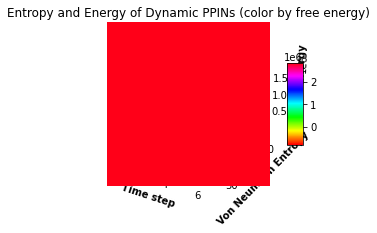

<Figure size 1080x720 with 0 Axes>

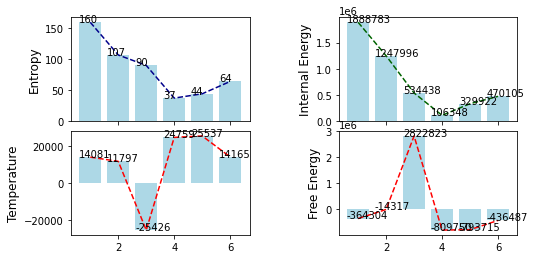

[93, 58, 85, 53, 51, 92]
[160, 107, 90, 37, 44, 64]
[939904, 666622, 672666, 508948, 510974, 867977]
[1888783, 1247996, 534438, 106348, 329922, 470105]


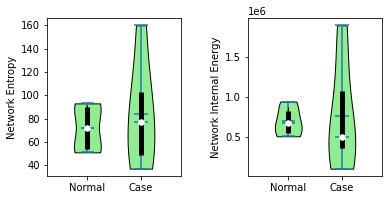

entropy_method:  1 energy_method:  2
wilcoxon: entropy distribution norm-vs-case is the same (value p-value) : 9.0 0.84375
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) : 17.0 0.9372294372294373
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
ttest: entropy distribution norm-vs-case is the same (value p-value) : -0.5702413492832346 0.5810991488262067
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.22088465537995747 0.8296269385052735
93 160 5902 10113 62 114
58 107 4505 7424 59 1086
85 90 5290 4714 -105 14249
53 37 3837 1604 137 -3477
51 44 3696 2895 112 -2076
92 64 5713 3964 62 -21


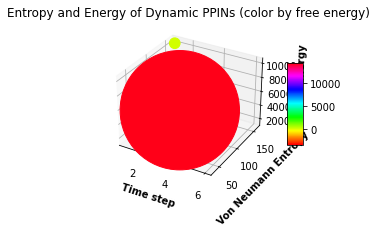

<Figure size 1080x720 with 0 Axes>

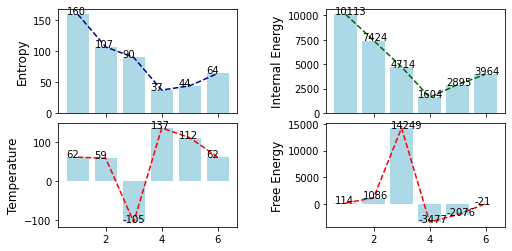

[93, 58, 85, 53, 51, 92]
[160, 107, 90, 37, 44, 64]
[5902, 4505, 5290, 3837, 3696, 5713]
[10113, 7424, 4714, 1604, 2895, 3964]


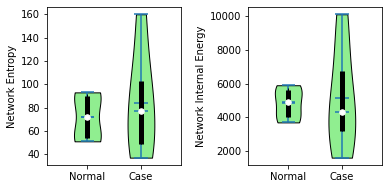

entropy_method:  2 energy_method:  1
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 22.0 0.5887445887445888
ttest: entropy distribution norm-vs-case is the same (value p-value) : nan nan
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.24093483577205257 0.8144735647272672
1 1 939904 1888783 409333695 -407444912
1 1 666622 1247996 244129557 -242881561
1 1 672666 534438 -52798043 53332481
1 1 508948 106348 -143096234 143202582
1 1 510974 329922 -63182073 63511995
1 1 867977 470105 -158002728 158472833


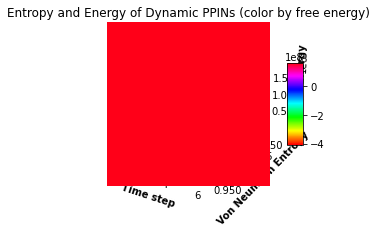

<Figure size 1080x720 with 0 Axes>

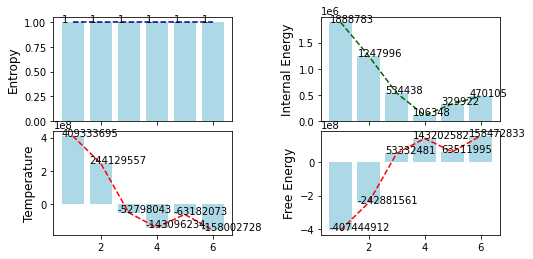

[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[939904, 666622, 672666, 508948, 510974, 867977]
[1888783, 1247996, 534438, 106348, 329922, 470105]


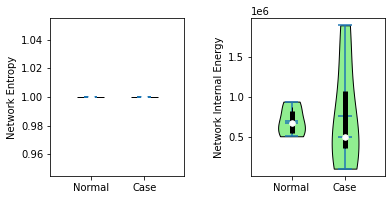

entropy_method:  2 energy_method:  2
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
ttest: entropy distribution norm-vs-case is the same (value p-value) : nan nan
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.22088465537995747 0.8296269385052735
1 1 5902 10113 1816568 -1806455
1 1 4505 7424 1225740 -1218316
1 1 5290 4714 -220010 224724
1 1 3837 1604 -793675 795279
1 1 3696 2895 -279526 282421
1 1 5713 3964 -694561 698525


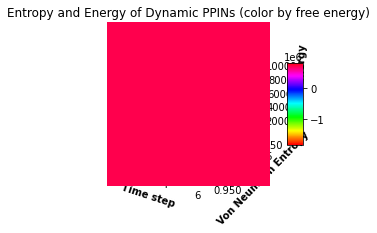

<Figure size 1080x720 with 0 Axes>

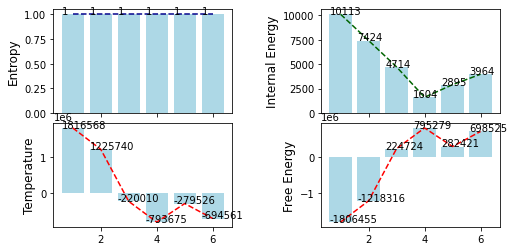

[1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1]
[5902, 4505, 5290, 3837, 3696, 5713]
[10113, 7424, 4714, 1604, 2895, 3964]


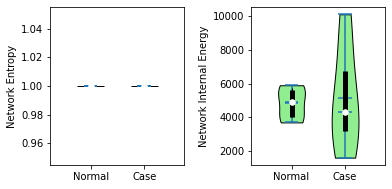

entropy_method:  3 energy_method:  1
wilcoxon: entropy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 22.0 0.5887445887445888
ttest: entropy distribution norm-vs-case is the same (value p-value) : -0.23533592073728463 0.818697299654516
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.24093483577205257 0.8144735647272672
2121 3648 939904 1888783 621 -377804
1608 2665 666622 1247996 550 -218453
1900 1692 672666 534438 663 -589041
1370 574 508948 106348 505 -183858
1316 1048 510974 329922 674 -377282
2053 1422 867977 470105 631 -427205


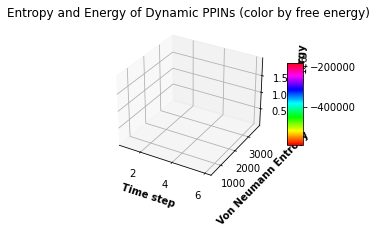

<Figure size 1080x720 with 0 Axes>

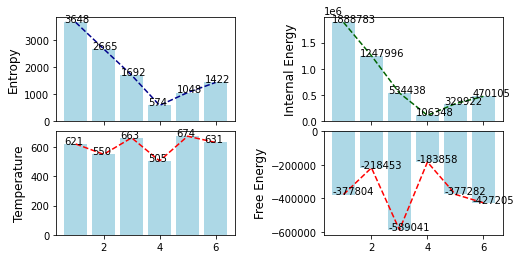

[2121, 1608, 1900, 1370, 1316, 2053]
[3648, 2665, 1692, 574, 1048, 1422]
[939904, 666622, 672666, 508948, 510974, 867977]
[1888783, 1247996, 534438, 106348, 329922, 470105]


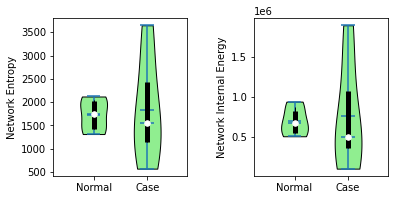

entropy_method:  3 energy_method:  2
wilcoxon: entropy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
ttest: entropy distribution norm-vs-case is the same (value p-value) : -0.23533592073728463 0.818697299654516
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.22088465537995747 0.8296269385052735
2121 3648 5902 10113 2 54
1608 2665 4505 7424 2 61
1900 1692 5290 4714 2 32
1370 574 3837 1604 2 -5
1316 1048 3696 2895 2 -233
2053 1422 5713 3964 2 19


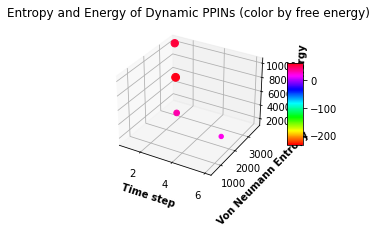

<Figure size 1080x720 with 0 Axes>

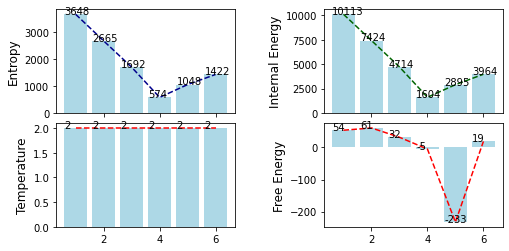

[2121, 1608, 1900, 1370, 1316, 2053]
[3648, 2665, 1692, 574, 1048, 1422]
[5902, 4505, 5290, 3837, 3696, 5713]
[10113, 7424, 4714, 1604, 2895, 3964]


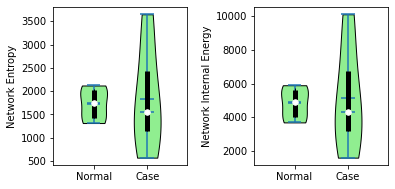

entropy_method:  5 energy_method:  1
wilcoxon: entropy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 22.0 0.5887445887445888
ttest: entropy distribution norm-vs-case is the same (value p-value) : -0.2335896385501529 0.8200159206992581
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.24093483577205257 0.8144735647272672
2134 3665 939904 1888783 619 -383326
1621 2681 666622 1247996 548 -222417
1914 1704 672666 534438 659 -588627
1382 581 508948 106348 502 -185678
1328 1058 510974 329922 671 -380734
2066 1434 867977 470105 629 -432675


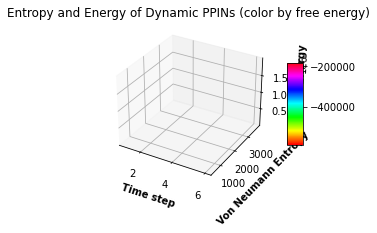

<Figure size 1080x720 with 0 Axes>

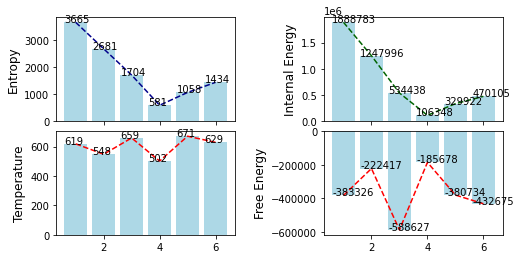

[2134, 1621, 1914, 1382, 1328, 2066]
[3665, 2681, 1704, 581, 1058, 1434]
[939904, 666622, 672666, 508948, 510974, 867977]
[1888783, 1247996, 534438, 106348, 329922, 470105]


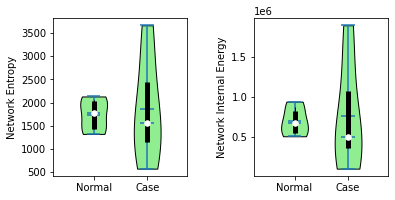

entropy_method:  5 energy_method:  2
wilcoxon: entropy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
wilcoxon: energy distribution norm-vs-case is the same (value p-value) : 10.0 1.0
mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) : 19.0 0.9372294372294373
ttest: entropy distribution norm-vs-case is the same (value p-value) : -0.2335896385501529 0.8200159206992581
ttest: energy distribution norm-vs-case is the same (value p-value) : -0.22088465537995747 0.8296269385052735
2134 3665 5902 10113 2 29
1621 2681 4505 7424 2 41
1914 1704 5290 4714 2 34
1382 581 3837 1604 2 -15
1328 1058 3696 2895 2 -249
2066 1434 5713 3964 2 -4


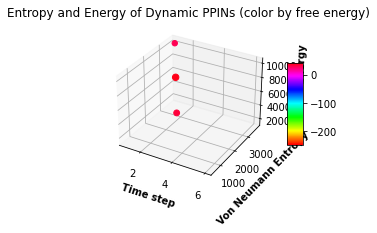

<Figure size 1080x720 with 0 Axes>

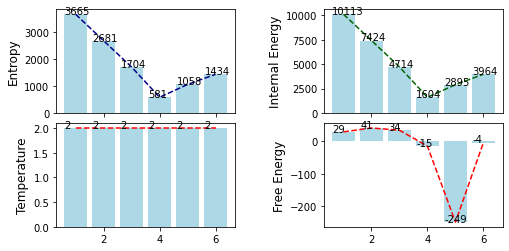

[2134, 1621, 1914, 1382, 1328, 2066]
[3665, 2681, 1704, 581, 1058, 1434]
[5902, 4505, 5290, 3837, 3696, 5713]
[10113, 7424, 4714, 1604, 2895, 3964]


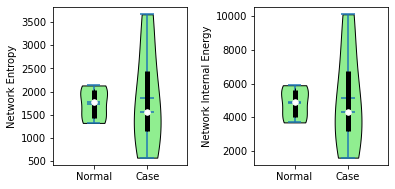

In [41]:
def validate_DPPIN(filename, entropy_method_id, energy_method_id):
    f = open(filename,"r")
    lines = f.readlines()
    f.close()
    M = [list(filter(None, x.strip().split('\t'))) for x in lines]
    entropy_normal = []
    entropy_case = []
    energy_normal = []
    energy_case = []
    temperature = []
    free_energy = []
    for i in range(1, len(M)):
        entropy = int(round(float(M[i][1 + entropy_method_id]),0))
        energy = int(round(float(M[i][5 + energy_method_id]),0))
        if (i % 2 == 1):  #normal/mock
            entropy_normal.append(entropy)
            energy_normal.append(energy)
        else:  #exp/case
            #print(entropy, float(M[i-1][1+ entropy_method_id]))
            entropy_case.append(entropy)
            energy_case.append(energy)
            if (abs(entropy-float(M[i-1][1+ entropy_method_id]))>=0.00001):
                temp = (energy-float(M[i-1][5 + energy_method_id]))/(entropy-float(M[i-1][1+ entropy_method_id]))
                temperature.append(int(temp))
                free_energy.append(int(energy - temp * entropy))
            else:
                print('row', i, ' entropy difference is close to zero')
            
    # computer wilconson t-test whether two distributions are the same around zero
    #the Mann-Whitney U-test tests two independent samples, whereas the Wilcox sign test tests two dependent samples
    if entropy_case[0] != entropy_case[1]:
        w, p = wilcoxon(entropy_normal, entropy_case)
        print('wilcoxon: entropy distribution norm-vs-case is the same (value p-value) :', w, p)
    if energy_case[0] != energy_case[1]:
        w, p = wilcoxon(energy_normal, energy_case)
        print('wilcoxon: energy distribution norm-vs-case is the same (value p-value) :', w, p)
    if entropy_case[0] != entropy_case[1]:
        w, p = mannwhitneyu(entropy_normal, entropy_case)
        print('mannwhitneyu: entropy distribution norm-vs-case is the same (value p-value) :', w, p)
    if energy_case[0] != energy_case[1]:
        w, p = mannwhitneyu(energy_normal, energy_case)
        print('mannwhitneyu: energy distribution norm-vs-case is the same (value p-value) :', w, p)
    w, p = ttest_ind(entropy_normal, entropy_case)
    print('ttest: entropy distribution norm-vs-case is the same (value p-value) :', w, p)
    w, p = ttest_ind(energy_normal, energy_case)
    print('ttest: energy distribution norm-vs-case is the same (value p-value) :', w, p)
    return entropy_normal, entropy_case, energy_normal, energy_case, temperature, free_energy

# Actios
entropy_methods = [1,2,3,5]
energy_methods = [1, 2]
filename = "".join([data_dir, '/data/', tissue, '/dppins_entropy.txt'])

for entropy_idx in range(len(entropy_methods)):
    for energy_idx in range(len(energy_methods)):
        print('entropy_method: ', entropy_methods[entropy_idx], 'energy_method: ', energy_methods[energy_idx])
        entropy_normal, entropy_case, energy_normal, energy_case, temperature, free_energy = validate_DPPIN(filename, entropy_idx, energy_idx)
        for i in range(len(entropy_normal)):
            print(entropy_normal[i], entropy_case[i], energy_normal[i], energy_case[i], temperature[i], free_energy[i])
        plot1(entropy_case, energy_case, temperature, free_energy)
        plot2(entropy_case, energy_case, temperature, free_energy)
        plot3(entropy_normal, entropy_case, energy_normal, energy_case)

#validate_DPPIN("".join([data_dir, '/data/', tissue, '/validate_DPPINsV1.txt']))


# Step 9.1 KL divergence

In [42]:
def get_node_prob(graph_adjacent_matrix, num_proteins):
    prob = np.zeros((num_proteins, ), dtype=np.float32)
    for node_id in range(num_proteins):
        count = 0
        for i in range(num_proteins):
            if (graph_adjacent_matrix[node_id][i] > 0):
                count +=1   
        if count> 0:
            prob[node_id] = count /num_proteins
    return prob

def compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins):
    kl_l_sum = 0
    kl_r_sum = 0
    for node_id in range(num_proteins):
        if exp_node_prob[node_id] > 0 and mock_node_prob[node_id] > 0:
            kl_l_sum += np.log2(mock_node_prob[node_id]/exp_node_prob[node_id])*mock_node_prob[node_id]
            kl_r_sum += np.log2(exp_node_prob[node_id]/mock_node_prob[node_id])*exp_node_prob[node_id]   
    return (kl_l_sum + kl_r_sum) /2

#Action:
print('node probablity-based KL divergence of normal against case')
time_points = 6
num_proteins = common_num_proteins
for t in range(time_points):
    mock_node_prob = get_node_prob(mock_DPPINs[t], num_proteins)
    exp_node_prob = get_node_prob(exp_DPPINs[t], num_proteins)
    kl = compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins)
    print('time point: ', str(t+1), ' KL divergence of mock at t against exp at t: ', kl)

print('Another method...')
print('act probability-based KL divergence of normal against case')
for t in range(time_points):
    mock_node_prob = mock_act_vec_list[t]
    exp_node_prob = exp_act_vec_list[t]
    kl = compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins)
    print('time point: ', str(t+1), ' KL divergence of mock at t against exp at t: ', kl)

print('Another method...')
print('node probablity-based KL divergence of normal at t against t-1')
for t in range(1, time_points):
    mock_node_prob = get_node_prob(mock_DPPINs[t], num_proteins)
    exp_node_prob = get_node_prob(mock_DPPINs[t-1], num_proteins)
    kl = compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins)
    print('time point: ', str(t+1), ' KL divergence of mock at t against mock at t-1: ', kl)

print('node probablity-based KL divergence of case at t against t-1')
for t in range(1, time_points):
    mock_node_prob = get_node_prob(exp_DPPINs[t], num_proteins)
    exp_node_prob = get_node_prob(exp_DPPINs[t-1], num_proteins)
    kl = compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins)
    print('time point: ', str(t+1), ' KL divergence of exp at t against exp at t-1: ', kl)

print('act probablity-based KL divergence of normal at t against t-1')
for t in range(1, time_points):
    mock_node_prob = mock_act_vec_list[t]
    exp_node_prob = mock_act_vec_list[t-1]
    kl = compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins)
    print('time point: ', str(t+1), ' KL divergence of mock at t against mock at t-1: ', kl)
    
print('act probablity-based KL divergence of exp at t against t-1')
for t in range(1, time_points):
    mock_node_prob = exp_act_vec_list[t]
    exp_node_prob = exp_act_vec_list[t-1]
    kl = compute_KL_divergence(mock_node_prob, exp_node_prob, num_proteins)
    print('time point: ', str(t+1), ' KL divergence of exp at t against exp at t-1: ', kl)


node probablity-based KL divergence of normal against case
time point:  1  KL divergence of mock at t against exp at t:  0.5899485782720149
time point:  2  KL divergence of mock at t against exp at t:  0.6525371621828526
time point:  3  KL divergence of mock at t against exp at t:  0.22918936336645856
time point:  4  KL divergence of mock at t against exp at t:  0.21158815402304754
time point:  5  KL divergence of mock at t against exp at t:  0.2653082693577744
time point:  6  KL divergence of mock at t against exp at t:  0.20167027489515021
Another method...
act probability-based KL divergence of normal against case
time point:  1  KL divergence of mock at t against exp at t:  10.857968032348488
time point:  2  KL divergence of mock at t against exp at t:  9.021489480273477
time point:  3  KL divergence of mock at t against exp at t:  10.930379260315352
time point:  4  KL divergence of mock at t against exp at t:  5.322057104008399
time point:  5  KL divergence of mock at t against ex

# Step 9.2 Cross validation - critical state of disease development

wilcoxon: node centrality - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) : 3.0 0.3125
wilcoxon: act prob. - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) : 1.0 0.125
mannwhitneyu: node centrality -  (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) : 6.0 0.2222222222222222
mannwhitneyu: act prob. - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) : 3.0 0.05555555555555555
ttest: node centrality - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) : -1.0717535518300139 0.3150949010866593
ttest: act prob. - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t

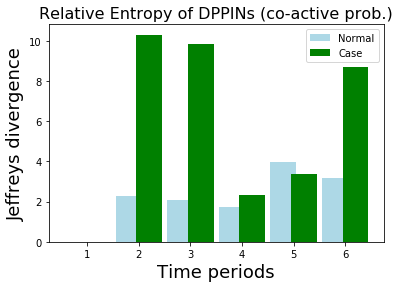

--------------------------


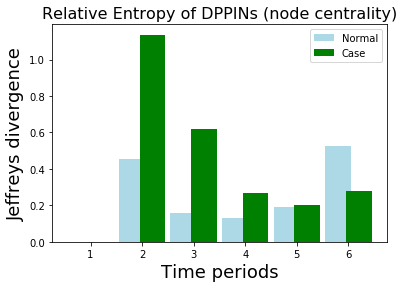

In [71]:
#data1 = [1.114164658,0.496105329,0.306998483,0.272522447,1.569461232]
#data2 = [3.105117243,0.998566809,1.047754427,0.166260683,1.13953323]

#X = [4.820634208,4.446216727,3.284768815,7.340972782,6.135289708]
#Y = [18.11531852,19.91523587,7.009294081,6.129588816,15.08587505]

#data1 = [1.069635926,0.465055815,0.297240262,0.258692991,1.535254186]
#data2 = [3.057517695,0.974596908,1.032774807,0.157178495,1.107692342]
#X = [4.820634208,4.446216727,3.284768815,7.340972782,6.135289708]
#Y = [18.11531852,19.91523587,7.009294081,6.129588816,15.08587505]

#data1 = [0.418226414,0.283911065,0.156916226,0.176948629,0.756817358]  #KL by node centrality mock(t) vs mock(t1)
#data2 = [1.638425019,0.621799218,0.41366942,0.155688842,0.71706561]    #KL by node centrality exp(t) vs exp(t1)
#X = [2.276676575,2.089467834,1.714562647,3.986841831,3.164224275]     #KL by act prob. mock(t) vs mock(t1)
#Y = [10.30816097,9.840592484,2.348293736,3.353178606,8.722530159]     #KL by act prob. exp(t) vs exp(t1)

data1 = [0.45354448,0.158782422,0.132931027,0.192834149,0.527521999]  #KL by node centrality mock(t) vs mock(t1)
data2 = [1.136058275,0.617508268,0.267660643,0.200294042,0.278750966]    #KL by node centrality exp(t) vs exp(t1)
X = [2.276676575,2.089467834,1.714562647,3.986841831,3.164224275]     #KL by act prob. mock(t) vs mock(t1)
Y = [10.30816097,9.840592484,2.348293736,3.353178606,8.722530159]     #KL by act prob. exp(t) vs exp(t1)

w, p = wilcoxon(data1, data2)
print('wilcoxon: node centrality - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) :', w, p)
w, p = wilcoxon(X, Y)
print('wilcoxon: act prob. - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) :', w, p)
w, p = mannwhitneyu(data1, data2)
print('mannwhitneyu: node centrality -  (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) :', w, p)
w, p = mannwhitneyu(X, Y)
print('mannwhitneyu: act prob. - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) :', w, p)
w, p = ttest_ind(data1, data2)
print('ttest: node centrality - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) :', w, p)
w, p = ttest_ind(X, Y)
print('ttest: act prob. - (KL divergence of mock at t against mock at t-1) vs (KL divergence of exp at t against exp at t-1) is the same (value p-value) :', w, p)

from matplotlib import pyplot as plt
X = [0, 2.276676575,2.089467834,1.714562647,3.986841831,3.164224275]     #KL by act prob. mock(t) vs mock(t-1)
Y = [0, 10.30816097,9.840592484,2.348293736,3.353178606,8.722530159]     #KL by act prob. exp(t) vs exp(t-1)

team = ['1', '2', '3', '4', '5', '6']
x_axis = np.arange(len(team))

fig, ax = plt.subplots()
plt.bar(x_axis-0.2, X,label="Normal", color='lightblue',width=.5)
#plt.plot(x_axis-0.2, X, color='darkblue', linestyle = 'dashed')
plt.bar(x_axis+0.2, Y,label="Case", color='g',width=.5)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
#plt.plot(x_axis+0.2, Y, color='red', linestyle = 'dashed')
plt.legend()
plt.xlabel('Time periods', fontsize=18)
plt.ylabel('Jeffreys divergence', fontsize=18)
plt.title('Relative Entropy of DPPINs (co-active prob.)', fontsize=16)
plt.show()

print('--------------------------')
X = [0, 0.45354448,0.158782422,0.132931027,0.192834149,0.527521999]  #KL by node centrality mock(t) vs mock(t1)
Y = [0, 1.136058275,0.617508268,0.267660643,0.200294042,0.278750966]    #KL by node centrality exp(t) vs exp(t1)

team = ['1', '2', '3', '4', '5', '6']
x_axis = np.arange(len(team))

fig, ax = plt.subplots()
plt.bar(x_axis-0.2, X,label="Normal", color='lightblue',width=.5)
#plt.plot(x_axis-0.2, X, color='darkblue', linestyle = 'dashed')
plt.bar(x_axis+0.2, Y,label="Case", color='g',width=.5)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
#plt.plot(x_axis+0.2, Y, color='red', linestyle = 'dashed')
plt.legend()
plt.xlabel('Time periods', fontsize=18)
plt.ylabel('Jeffreys divergence', fontsize=18)
plt.title('Relative Entropy of DPPINs (node centrality)', fontsize=16)
plt.show()

In [ ]:
file:///C:/Users/Qiong/chunting/tbox/topics/Computational_Systems_Biology/Good%20Identifying%20critical%20state%20of%20complex.pdf
        In ideal situation with small
noise, when a complex system is near the critical point,
among all observed variables there exists a dominant
group defined as the DNB biomolecules, which satisfy
the following three conditions based on the observed
data [10]:
 The correlation (PCCin) between any pair of
members in the DNB group rapidly increases;
 The correlation (PCCout) between one member of
the DNB group and any other non-DNB member
rapidly decreases;
 The standard deviation (SDin) or coefficient of
variation for any member in the DNB group
drastically increases.
Refer to prediction and early diagnosis of complex diseases by edge-network

In [44]:
# select edges significant at all time points (PCC > 0.99 std < 0.1 MI >0.5)
def get_significant_genes_over_all_time_points(matrix, time_points, num_proteins, id2protein, isless, threshold):
    selected_gene = list()
    for i in range(num_proteins):
        gene_i = id2protein[i]
        for j in range(num_proteins):
            gene_j = id2protein[j]
            is_selected = True
            for t in range(time_points):
                #print(i, j, isless, threshold, matrix[t][i,j])
                if isless:
                    if matrix[t][i,j] >= threshold:
                        is_selected = False
                else:
                    if matrix[t][i,j] <= threshold:
                        is_selected = False  
            if is_selected:
                #print(i, j, isless, threshold, matrix[t][i,j], 'selected')
                selected_gene.append(i)
                selected_gene.append(j)
    return selected_gene

# Actions:
# select edges significant at all time points (PCC > 0.8 std < 0.1 MI >0.5)
pcc_threshold = 0.99
pcc_isless = False
std_threshold = 0.1
std_isless = True
mi_threshold = 0.5
mi_isless = False
pcc_significant_genes = get_significant_genes_over_all_time_points(exp_coe_matrix, time_points, common_num_proteins, id2protein, pcc_isless, pcc_threshold)

std_significant_genes = get_significant_genes_over_all_time_points(mock_std_matrix, time_points, common_num_proteins, id2protein, std_isless, std_threshold)

mi_significant_genes = get_significant_genes_over_all_time_points(mock_mi_matrix, time_points, common_num_proteins, id2protein, mi_isless, mi_threshold)

common_significant_genes = list(set(list(set(pcc_significant_genes))))  #+list(set(std_significant_genes))+list(set(mi_significant_genes)))) 

print(len(common_significant_genes))

# Alternate methods:
# using act_prob_matrix
# using 4-order  co-expression

583


In [45]:
#check whether at certain time point, correlation between group increases and correlation across groups decreases, std between group increase
def avg_pcc_within_group(coe_matrix, adj_matrix, num_proteins, common_significant_genes):
    sum_pcc = 0
    count = 0
    for gene_i in common_significant_genes:
        for gene_j in common_significant_genes:
            adj = adj_matrix[gene_i, gene_j]
            pcc = abs(coe_matrix[gene_i, gene_j])
            if (gene_i > gene_j) and (pcc > 0) and (adj>0):
                sum_pcc += pcc
                count += 1
    return sum_pcc/ (count + 0.0001)

def avg_std_within_group(std_matrix, adj_matrix, num_proteins, common_significant_genes):
    sum_std = 0
    count = 0
    for gene_i in common_significant_genes:
        for gene_j in common_significant_genes:
            adj = adj_matrix[gene_i, gene_j]
            std = std_matrix[gene_i, gene_j]
            if (gene_i > gene_j) and (std > 0) and (adj>0):
                sum_std += std
                count += 1
    return sum_std/ (count + 0.0001)

def avg_pcc_across_group(coe_matrix, adj_matrix, num_proteins, common_significant_genes):
    sum_pcc = 0
    count = 0
    for gene_i in common_significant_genes:
        for gene_j in range(num_proteins):
            if not (gene_j in common_significant_genes):
                adj = adj_matrix[gene_i, gene_j]
                pcc = abs(coe_matrix[gene_i, gene_j])
                if (gene_i > gene_j) and (pcc > 0) and (adj>0):
                    sum_pcc += abs(coe_matrix[gene_i, gene_j])
                    count += 1
    return sum_pcc/ (count + 0.0001)

#Actions:
mock_avg_pcc_in_group_list = []
mock_avg_pcc_tw_group_list = []
mock_avg_std_in_group_list = []
mock_avg_pcc_in_group_list = []
mock_ci_list = []
exp_avg_pcc_in_group_list = []
exp_avg_pcc_tw_group_list = []
exp_avg_std_in_group_list = []
exp_avg_pcc_in_group_list = []
exp_ci_list = []
for t in range(time_points):
    mock_avg_pcc_in_group = avg_pcc_within_group(mock_coe_matrix[t]+mock_mi_matrix[t],mock_DPPINs[t], common_num_proteins, common_significant_genes)
    mock_avg_pcc_tw_group = avg_pcc_across_group(mock_coe_matrix[t]+mock_mi_matrix[t],mock_DPPINs[t], common_num_proteins, common_significant_genes)
#    mock_avg_pcc_in_group = avg_pcc_within_group(mock_DPPINs[t], common_num_proteins, common_significant_genes)
#    mock_avg_pcc_tw_group = avg_pcc_across_group(mock_DPPINs[t], common_num_proteins, common_significant_genes)

    mock_avg_std_in_group = avg_std_within_group(mock_std_matrix[t], mock_DPPINs[t], common_num_proteins, common_significant_genes)
    mock_ci = mock_avg_std_in_group * mock_avg_pcc_in_group/ (mock_avg_pcc_tw_group +0.00001)
    
    exp_avg_pcc_in_group = avg_pcc_within_group(exp_coe_matrix[t]+exp_mi_matrix[t], exp_DPPINs[t], common_num_proteins, common_significant_genes)
    exp_avg_pcc_tw_group = avg_pcc_across_group(exp_coe_matrix[t]+exp_mi_matrix[t], exp_DPPINs[t], common_num_proteins, common_significant_genes)
    exp_avg_std_in_group = avg_std_within_group(exp_std_matrix[t], exp_DPPINs[t], common_num_proteins, common_significant_genes)
    exp_ci = exp_avg_std_in_group * exp_avg_pcc_in_group/ (exp_avg_pcc_tw_group +0.00001)  
    
    print('t', t, 'mock', mock_ci, mock_avg_pcc_in_group, mock_avg_pcc_tw_group, mock_avg_std_in_group, 
          'exp', exp_ci, exp_avg_pcc_in_group, exp_avg_pcc_tw_group, exp_avg_std_in_group)
    
    mock_avg_pcc_in_group_list.append(mock_avg_pcc_in_group)
    mock_avg_pcc_tw_group_list.append(mock_avg_pcc_tw_group)
    mock_avg_std_in_group_list.append(mock_avg_std_in_group)
    mock_ci_list.append(mock_ci)
    exp_avg_pcc_in_group_list.append(exp_avg_pcc_in_group)
    exp_avg_pcc_tw_group_list.append(exp_avg_pcc_tw_group)
    exp_avg_std_in_group_list.append(exp_avg_std_in_group)
    exp_ci_list.append(exp_ci)
print('done')

t 0 mock 1.7344978804672226 0.9999998620689846 0.9986583743464519 1.7321884175160749 exp 1.4802826102609146 0.9999999646393223 0.9999999653619686 1.4802974141572613
t 1 mock 1.685918031018959 0.8059935881821839 0.794591717691244 1.6620893552710234 exp 1.6138117260536056 0.8884196557497063 0.8323874872394684 1.5120476195576955
t 2 mock 1.7721669823798565 0.8364949195964638 0.8249521112653049 1.747734004175452 exp 1.6899839416050193 0.9110968854966666 0.882773949431789 1.6374665770403833
t 3 mock 1.7333106501164954 0.8458496826520271 0.8369242247729746 1.7150411414681317 exp 1.6529097117681135 0.8848509175544487 0.8499118858167148 1.5876619568790484
t 4 mock 1.4425183892590359 0.8731038389587398 0.8693744300273532 1.4363732830972096 exp 1.7937904212894609 0.8959118906999788 0.8749168354695707 1.7517742459788217
t 5 mock 1.5373520724748582 0.9999998468606667 0.999999880810503 1.5373674981907963 exp 1.6399607031581012 1.000453150255887 1.0005696109234796 1.6401679997469458
done


In [46]:
w, p = wilcoxon(mock_ci_list, exp_ci_list)
print('wilcoxon: disease development index of mock against case is the same (value p-value) :', w, p)
w, p = mannwhitneyu(mock_ci_list, exp_ci_list)
print('mannwhitneyu: disease development index of mock against case is the same (value p-value) :', w, p)
w, p = ttest_ind(mock_ci_list, exp_ci_list)
print('ttest: disease development index of mock against case is the same (value p-value) :', w, p)

wilcoxon: disease development index of mock against case is the same (value p-value) : 10.0 1.0
mannwhitneyu: disease development index of mock against case is the same (value p-value) : 20.0 0.8181818181818182
ttest: disease development index of mock against case is the same (value p-value) : 0.08594990888572406 0.9332027989641056


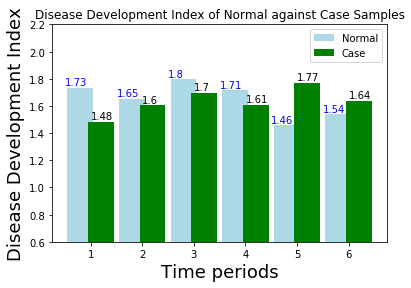

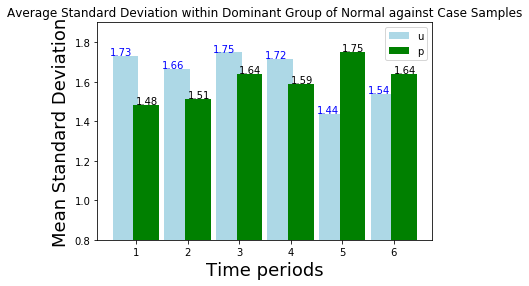

In [110]:
from matplotlib import pyplot as plt
# function to add value labels
def addlabels(plt,x_axis,X, Y, heigt):
    for i in range(len(x_axis)):
        plt.text(x_axis[i] -0.5,X[i]+heigt/35,round(X[i],2), ha='left', color='blue')
        plt.text(x_axis[i],Y[i]+heigt/35,round(Y[i],2), ha='left', color='black')
        
X = mock_ci_list
Y = exp_ci_list
t = [1,2,3,4,5,6]
x_axis = np.arange(len(t))

fig, ax = plt.subplots()
plt.bar(x_axis -0.2, X,label="Normal", color='lightblue',width=.5)
#plt.plot(x_axis -0.2, X, color='darkblue', linestyle = 'dashed')
plt.bar(x_axis +0.2, Y,label="Case", color='g',width=.5)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])
addlabels(ax, x_axis, X, Y, 2.3-1.6)

#plt.plot(x_axis +0.2, Y, color='red', linestyle = 'dashed')
plt.legend()
plt.ylim((0.6,2.2))
plt.xlabel('Time periods', fontsize=18)
plt.ylabel('Disease Development Index', fontsize=18)
plt.title('Disease Development Index of Normal against Case Samples')
plt.show()

X = mock_avg_std_in_group_list
Y = exp_avg_std_in_group_list

fig, ax = plt.subplots()
plt.bar(x_axis -0.2, X,label="Normal", color='lightblue',width=.5)
#plt.plot(x_axis -0.2, X, color='darkblue', linestyle = 'dashed')
plt.bar(x_axis +0.2, Y,label="Case", color='g',width=.5)
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])
addlabels(ax, x_axis, X, Y, 1.9-1.77)

#plt.plot(x_axis +0.2, Y, color='red', linestyle = 'dashed')
plt.legend('upper left')
plt.ylim((0.8,1.9))
plt.xlabel('Time periods', fontsize=18)
plt.ylabel('Mean Standard Deviation', fontsize=18)
plt.title('Average Standard Deviation within Dominant Group of Normal against Case Samples')
plt.show()

# node vitality  composite index: mock_node_ci, exp_node_ci

In [47]:
#check whether at certain time point, correlation between group increases and correlation across groups decreases, std between group increase
def get_neighbor(adj_matrix, node_i, num_proteins):
    node_adj = []
    for node_j in range(num_proteins):
        if (node_j != node_i) and (adj_matrix[node_i,node_j] > 0):
            node_adj.append(node_j)
    return node_adj

def compute_node_ci(adj_matrix, coe_matrix, std_matrix, num_proteins):
    node_ci_list = []
    for node_i in range(num_proteins):
        node_adj = get_neighbor(adj_matrix, node_i, num_proteins)
        std = 0
        pcc_d = 0
        pcc_o = 0
        std_count = 0
        d_count = 0
        o_count = 0
        for node_j in node_adj:
            if std_matrix[node_i, node_j]>0:
                std += std_matrix[node_i, node_j]
                std_count += 1
            if coe_matrix[node_i, node_j]>0:
                pcc_d += coe_matrix[node_i, node_j]
                d_count += 1
        for node_j in range(num_proteins):
            if (node_j != node_i) and not (node_j in node_adj) and (coe_matrix[node_i, node_j]>0):
                pcc_o += coe_matrix[node_i, node_j]
                o_count += 1
        if d_count == 0 or pcc_o == 0:
            node_ci = 0
        else:
            node_ci = (pcc_d/d_count)*(std/std_count)/(pcc_o/o_count)
        node_ci_list.append(node_ci)
    return node_ci_list

#Actions:
mock_node_ci = defaultdict(list)
exp_node_ci = defaultdict(list)
for t in range(time_points):
    print('time point: ', t)
    print('mock')
    mock_node_ci_at_t = compute_node_ci(mock_DPPINs[t], mock_coe_matrix[t]+mock_mi_matrix[t], mock_std_matrix[t], common_num_proteins)
    mock_node_ci[t] = mock_node_ci_at_t
    print('exp')    
    exp_node_ci_at_t = compute_node_ci(exp_DPPINs[t], exp_coe_matrix[t]+exp_mi_matrix[t], exp_std_matrix[t], common_num_proteins)
    exp_node_ci[t] = exp_node_ci_at_t
print('done')

time point:  0
mock
exp
time point:  1
mock
exp
time point:  2
mock
exp
time point:  3
mock
exp
time point:  4
mock
exp
time point:  5
mock
exp
done


# node vitality  method 2 KL divergence relative_entropy

Thermodynamics is usually developed starting from entropy and the maximum entropy principle. We investigate here to what extent one can replace entropy with relative entropy which has several advantages, for example in the context of local quantum field theory. We find that the principle of maximum entropy can be replaced by a principle of minimum expected relative entropy. Various ensembles and their thermodynamic potentials can be defined through relative entropy. We also show that thermal fluctuations are in fact governed by a relative entropy. Furthermore we reformulate the third law of thermodynamics using relative entropy only.

Thermodynamics from relative entropy

Entropy then becomes the self-information of a random variable. Mutual
information is a special case of a more general quantity called relative
entropy, which is a measure of the distance between two probability
distributions. All these quantities are closely related and share a
number of si

The entropy of a random variable is a measure of the uncertainty of the
random variable; it is a measure of the amount of information required
on the average to describe the random variable. In this section, we
introduce two related concepts: relative entropy and mutual information.
The relative entropy is a measure of the distance between two
distributions. In statistics, it arises as an expected logarithm of the
likelihood ratio. The relative entropy D(p 11 a> is a measure of the
inefficiency of assuming that the distribution is Q when the true distribution is p. For example, if we knew the true distribution of the
random variable, then we could construct a code with average description length H(p). If, instead, we used the code for a distribution 4, we
would need H(p) + D( p 11 a> bits on the average to describe the random
variable. 

#Refer to Detecting the critical states during disease development based on temporal network flow entropy

In [48]:

def get_node_prob(graph_adjacent_matrix, num_proteins):
    prob = np.zeros((num_proteins, ), dtype=np.float32)
    for node_id in range(num_proteins):
        count = 0
        for i in range(num_proteins):
            if (node_id != i) and (graph_adjacent_matrix[node_id, i] > 0):
                count +=1   
        if count> 0:
            prob[node_id] = count /num_proteins
    return prob

def compute_node_relative_entropy(act_prob_matrix1, act_prob_matrix2, num_proteins):
    node_relative_entropy_list = []

    node_prob_matrix1 = get_node_prob(act_prob_matrix1, num_proteins)
    node_prob_matrix2 = get_node_prob(act_prob_matrix2, num_proteins)
    kl_l = 0
    kl_r = 0
    for node_id in range(num_proteins):
        if node_prob_matrix1[node_id] > 0 and node_prob_matrix2[node_id] > 0:
            kl_l= np.log2(node_prob_matrix1[node_id]/node_prob_matrix2[node_id])*node_prob_matrix1[node_id]
            kl_r= np.log2(node_prob_matrix2[node_id]/node_prob_matrix1[node_id])*node_prob_matrix2[node_id]  
            #print(node_id, node_prob_matrix1[node_id], node_prob_matrix2[node_id], kl_l, kl_r, (kl_l + kl_r) /2)
        node_relative_entropy_list.append((kl_l + kl_r) /2)
    return node_relative_entropy_list

#Actions:
exp_vs_mock_node_relative_entropy = defaultdict(list)
adjacent_exp_node_relative_entropy = defaultdict(list)

for t in range(time_points):
    print('time point: ', t)
    print('mock vs exp')
#    exp_vs_mock_node_relative_entropy_list = compute_node_relative_entropy(mock_act_prob_matrix[t], exp_act_prob_matrix[t], common_num_proteins)
    exp_vs_mock_node_relative_entropy_list = compute_node_relative_entropy(mock_DPPINs[t], exp_DPPINs[t], common_num_proteins)
    exp_vs_mock_node_relative_entropy[t] = exp_vs_mock_node_relative_entropy_list
    
    print('exp(t-1) vs exp(t)')
    if t != 0:
#        adjacent_exp_node_relative_entropy_list = compute_node_relative_entropy(exp_act_prob_matrix[t-1], exp_act_prob_matrix[t], common_num_proteins)
        adjacent_exp_node_relative_entropy_list = compute_node_relative_entropy(exp_DPPINs[t-1], exp_DPPINs[t], common_num_proteins)
        adjacent_exp_node_relative_entropy[t] = adjacent_exp_node_relative_entropy_list
print('done')

time point:  0
mock vs exp
exp(t-1) vs exp(t)
time point:  1
mock vs exp
exp(t-1) vs exp(t)
time point:  2
mock vs exp
exp(t-1) vs exp(t)
time point:  3
mock vs exp
exp(t-1) vs exp(t)
time point:  4
mock vs exp
exp(t-1) vs exp(t)
time point:  5
mock vs exp
exp(t-1) vs exp(t)
done


# Step 10 Verify vital nodes

In [49]:
#https://github.com/druggablegenome/IDGTargets
#http://juniper.health.unm.edu/tcrd/
#https://newdrugtargets.org/?disease=2887
#family,sym,detailed_family,name,tdl,uniprot,type,dtoid,novelty_score,importance_score

def retrieve_node_tcrd_info(filename, num_proteins,protein2id, id2protein):
    node_tcrd = defaultdict(dict)
    with open(filename, 'r') as f:
        lines = f.readlines()
    f.close()
    for gene_idx in range(num_proteins):
        node_tcrd[gene_idx] = {'tdl':'','uniprot':'', 'gene_type':'','dtoid':'', 'novelty':0,'importance':0}                

    idx = 0
    for line in lines:
        if idx > 0:
            items = line.strip().split(',')
            gene = items[1]
            tdl = items[4]
            uniprot = items[5]
            gene_type = items[6]
            dtoid = items[7]
            #print(items[8])
            novelty_score = round(float(items[8]), 2)
            importance_score = round(float(items[9]), 2)
            if gene in protein2id:
                gene_idx = protein2id[gene]
                node_tcrd[gene_idx] = {'tdl':tdl,'uniprot':uniprot, 'gene_type':gene_type,'dtoid':dtoid, 'novelty':novelty_score,'importance':importance_score}
        idx += 1

    return node_tcrd

#Actions:
filename = "".join([data_dir, '/data/lung/', 'avian_influenza_v1_newdrugtargets.csv'])

node_tcrd = retrieve_node_tcrd_info(filename, common_num_proteins,protein2id, id2protein)
print('done')

done


In [50]:
# scoring vital nodes:
# criterial: relative entropy of exp agains normal would be larger
#           relative entropy of exp at adjacent time points would be larger
#           in case: std sudden increasing, dependency (PCC + MI) increases within its local net, dependency decreases
#           in normal: std sudden increasing, dependency (PCC + MI) increases within its local net, dependency decreases
# mock_node_ci, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy
def sigmoid(val_list):
    sigmoid_list = [1/(1+np.exp(-val)) for val in val_list]
    return sigmoid_list

def normalizeData(val_list):
    return (val_list - np.min(val_list)) / (np.max(val_list) - np.min(val_list))

def isActiveNode( exp_DPPINs, gene_idx):
    is_active = False
    #print(exp_DPPINs[gene_idx])
    for val in exp_DPPINs[gene_idx]:
        if val > 0:
            is_active = True
    return is_active

def vital_nodes(id2protein,  exp_DPPINs, time_point, mock_node_ci, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy, alpha=0,beta=0):
    num_proteins = len(mock_node_ci)
    #print(exp_node_ci)
    exp_node_ci_sigmoid = sigmoid(exp_node_ci)
    #print(exp_node_ci_sigmoid)
    exp_vs_normal_relative_entropy_sigmoid = sigmoid(normalizeData(exp_vs_mock_node_relative_entropy))
    if time_point > 0:
        adjacent_exp_node_relative_entropy_sigmoid = sigmoid(normalizeData(adjacent_exp_node_relative_entropy))
    indexing_score = []
    for i in range(num_proteins):
        if (isActiveNode(exp_DPPINs, i)):
            gene_id = id2protein[i]
            if time_point ==0:
                node_indexing_score = (1-alpha*2) * exp_node_ci_sigmoid[i]+ alpha * 2 * exp_vs_normal_relative_entropy_sigmoid[i]
            else:
                node_indexing_score = (1-alpha-beta) * exp_node_ci_sigmoid[i]+ alpha * exp_vs_normal_relative_entropy_sigmoid[i] + beta * adjacent_exp_node_relative_entropy_sigmoid[i]
            #print(gene_id, exp_node_ci_sigmoid[i], exp_vs_normal_relative_entropy_sigmoid[i], (1-alpha*2) * exp_node_ci_sigmoid[i], node_indexing_score)
            indexing_score.append(node_indexing_score)
        else:
            indexing_score.append(0)
    return indexing_score

# Action
vital_nodes_index_score = []
for time_point in range(time_points):
    print('time point:', time_point)
    indexing_score = vital_nodes(id2protein, exp_DPPINs[time_point], time_point, mock_node_ci[time_point], exp_node_ci[time_point], exp_vs_mock_node_relative_entropy[time_point], adjacent_exp_node_relative_entropy[time_point], 0.25,0.25)
    vital_nodes_index_score.append(indexing_score)

time point: 0
time point: 1
time point: 2
time point: 3
time point: 4
time point: 5


Ensemble feature selection is the concept of using multiple runs of feature selection and aggregating their results
into a single decision.
The idea is to use the diversity
between the runs to choose features or genes that show up as
strong across the runs. Ensemble feature selection techniques
reduce the variability that can arise due to relying on a single
run of feature selection.
However,
there is another approach toward aggregation: aggregating
the scores from the chosen metric instead of the rankings
based on those scores
Gene selection is an essential step in much bioinformatics research in order to handle the thousands or tens
of thousands of gene expression levels generated by gene
microarrays. It is especially important that this gene selection
is robust and will produce consistent results even in the face
of changes to the dataset. Ensemble gene selection can help
improve robustness, by combining gene rankings from multiple
gene selection techniques into a single gene subset. Typically
this is performed by performing multiple runs of feature (gene)
selection, finding each gene’s rank within the different runs,
and aggregating these ranks into a final ranked list. However,
another option exists: instead of performing the ranking on
each list and then aggregating, the raw scores produced by the
gene ranking algorithms (which would normally be compared
to generate a ranking) are aggregated directly, and these
aggregate scores are used to create a final ranking.

In [51]:
#mock_node_ci, exp_node_ci
#mock_node_entropy1,mock_node_entropy3, mock_node_entropy5
#exp_node_entropy1,exp_node_entropy3, exp_node_entropy5
#exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy
#vital_nodes_index_score
# write all node information
#def nodeinfo2vec(filename, num_proteins, time_points, id2protein, mock_act_vec_list, mock_gene_expression_value, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_act_vec_list, exp_gene_expression_value, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy):
def nodeinfo2vec(filename, num_proteins, time_points, id2protein, node_tcrd, mock_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_act_vec_list, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy, vital_nodes_index_score):
    with open(filename, 'w') as f:
        f.write('\t'.join(['gene','tbl','uniprot','gene_type','dtoid','novelty','importance','t1_mock_act_prob', 't1_mock_entropy1', 't1_mock_entropy3', 't1_mock_entropy5', 't1_mock_ci', 't1_exp_act_prob', 't1_exp_entropy1', 't1_exp_entropy3', 't1_exp_entropy5', 't1_exp_ci', 't1_mock_vs_exp_kl', 't1_adj_exp_kl', 't1_index_score',  
                           't2_mock_act_prob', 't2_mock_entropy1', 't2_mock_entropy3', 't2_mock_entropy5', 't2_mock_ci', 't2_exp_act_prob', 't2_exp_entropy1', 't2_exp_entropy3', 't2_exp_entropy5', 't2_exp_ci', 't2_mock_vs_exp_kl', 't2_adj_exp_kl', 't2_index_score', 
                           't3_mock_act_prob', 't3_mock_entropy1', 't3_mock_entropy3', 't3_mock_entropy5', 't3_mock_ci', 't3_exp_act_prob', 't3_exp_entropy1', 't3_exp_entropy3', 't3_exp_entropy5', 't3_exp_ci', 't3_mock_vs_exp_kl', 't3_adj_exp_kl', 't3_index_score', 
                           't4_mock_act_prob', 't4_mock_entropy1', 't4_mock_entropy3', 't4_mock_entropy5', 't4_mock_ci', 't4_exp_act_prob', 't4_exp_entropy1', 't4_exp_entropy3', 't4_exp_entropy5', 't4_exp_ci', 't4_mock_vs_exp_kl', 't4_adj_exp_kl', 't4_index_score', 
                           't5_mock_act_prob', 't5_mock_entropy1', 't5_mock_entropy3', 't5_mock_entropy5', 't5_mock_ci', 't5_exp_act_prob', 't5_exp_entropy1', 't5_exp_entropy3', 't5_exp_entropy5', 't5_exp_ci', 't5_mock_vs_exp_kl', 't5_adj_exp_kl', 't5_index_score', 
                           't6_mock_act_prob', 't6_mock_entropy1', 't6_mock_entropy3', 't6_mock_entropy5', 't6_mock_ci', 't6_exp_act_prob', 't6_exp_entropy1', 't6_exp_entropy3', 't6_exp_entropy5', 't6_exp_ci', 't6_mock_vs_exp_kl', 't6_adj_exp_kl', 't6_index_score','\n']))

        for idx in range(num_proteins):
            gene = id2protein[idx]
            f.write(gene)
            f.write('\t')
            tdl = node_tcrd[idx]['tdl']
            uniprot = node_tcrd[idx]['uniprot']
            gene_type = node_tcrd[idx]['gene_type']
            dtoid = node_tcrd[idx]['dtoid']
            novelty = node_tcrd[idx]['novelty']
            importance = node_tcrd[idx]['importance']
            f.write('\t'.join([tdl,uniprot,gene_type,dtoid,str(novelty),str(importance)]))
            for time_point in range(time_points): 

                mock_act_prob = mock_act_vec_list[time_point][idx]
                #mock_exp_value = [str(value) for value in mock_gene_expression_value[time_point][idx]]
                mock_entropy1 = mock_node_entropy1[time_point][idx]
                mock_entropy3 = mock_node_entropy3[time_point][idx]
                mock_entropy5 = mock_node_entropy5[time_point][idx]
                mock_ci = mock_node_ci[time_point][idx]
                exp_act_prob = exp_act_vec_list[time_point][idx]
                #exp_exp_value = [str(value) for value in exp_gene_expression_value[time_point][idx]]
                exp_entropy1 = exp_node_entropy1[time_point][idx]
                exp_entropy3 = exp_node_entropy3[time_point][idx]
                exp_entropy5 = exp_node_entropy5[time_point][idx]
                exp_ci = exp_node_ci[time_point][idx]
                node_index_score = vital_nodes_index_score[time_point][idx]
                node_relative_entropy = 0
                adj_node_relative_entropy = 0
                node_relative_entropy = exp_vs_mock_node_relative_entropy[time_point][idx]
                if time_point > 0:
                    adj_node_relative_entropy = adjacent_exp_node_relative_entropy[time_point][idx]
                f.write('\t')
            
                #f.write('\t'.join([str(time_point), str(mock_act_prob), '\t'.join(mock_exp_value), str(mock_entropy1), str(mock_entropy3), str(mock_entropy5), str(exp_act_prob), '\t'.join(exp_exp_value), str(exp_entropy1), str(exp_entropy3), str(exp_entropy5)]))
                f.write('\t'.join([str(mock_act_prob), str(mock_entropy1), str(mock_entropy3), str(mock_entropy5), str(mock_ci), str(exp_act_prob), str(exp_entropy1), str(exp_entropy3), str(exp_entropy5), str(exp_ci), str(node_relative_entropy), str(adj_node_relative_entropy), str(node_index_score) ]))
            f.write('\n')
    f.close()
    
# Action
filename = "".join([data_dir, '/data/lung/', 'node_act_info.txt'])
#nodeinfo2vec(filename, common_num_proteins, time_points, id2protein, mock_act_vec_list, mock_gene_expression_value, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_act_vec_list, exp_gene_expression_value, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy)
nodeinfo2vec(filename, common_num_proteins, time_points, id2protein, node_tcrd, mock_act_vec_list, mock_node_entropy1, mock_node_entropy3, mock_node_entropy5, mock_node_ci, exp_act_vec_list, exp_node_entropy1, exp_node_entropy3, exp_node_entropy5, exp_node_ci, exp_vs_mock_node_relative_entropy, adjacent_exp_node_relative_entropy, vital_nodes_index_score)

print('done')
    

done


In [53]:
# validate the vital nodes by pathways and complexes
def get_vital_nodes(vital_nodes_index_score, time_points, percentile, vital_genes_time_map):
    for time_point in range(time_points):
        indexing_scores_sorted = sorted(vital_nodes_index_score[time_point])
        indexing_scores = np.array(indexing_scores_sorted)
        threshold = np.percentile(indexing_scores, percentile)
        num_proteins = len(indexing_scores_sorted)
        vital_genes = []
        vital_gene_idxes = []
        for gene_idx in range(num_proteins):
            gene_id = id2protein[gene_idx]
            if vital_nodes_index_score[time_point][gene_idx] >=  threshold:
                vital_genes.append(gene_id)
                vital_gene_idxes.append(gene_idx)
                vital_genes_time_map[gene_id].append(time_point+1)
    vital_gene_idxes = list(set(vital_gene_idxes))
    vital_genes = list(set(vital_genes))
    return vital_gene_idxes, vital_genes

def validate_vital_nodes(vital_nodes_index_score, DPPIN, time_point, id2protein,percentile, vital_gene_idxes, vital_genes, allpairs_num_of_complexes_count,allpairs_num_of_complexes_ids, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, filehandling1, filehandling2, vital_genes_time_map, vital_genes_interactions_multiple_layer):
    indexing_scores_sorted = sorted(vital_nodes_index_score)
    indexing_scores = np.array(indexing_scores_sorted)
    threshold = np.percentile(indexing_scores, percentile)
    num_proteins = len(vital_nodes_index_score)
    tmp_vital_genes = []
    tmp_vital_gene_idxes = []
    for gene_idx in range(num_proteins):
        gene_id = id2protein[gene_idx]
        if vital_nodes_index_score[gene_idx] >=  threshold:
            tmp_vital_genes.append(gene_id)
            tmp_vital_gene_idxes.append(gene_idx)
    tmp_vital_gene_idxes = list(set(tmp_vital_gene_idxes))
    tmp_vital_genes = list(set(tmp_vital_genes))
    for i in range(len(tmp_vital_genes)):
        filehandling1.write('\t'.join([str(time_point), str(tmp_vital_gene_idxes[i]), tmp_vital_genes[i], '\n']))
    
    tmp_vital_edges = defaultdict(list)
    for gene_i_idx in tmp_vital_gene_idxes:
        for gene_j_idx in tmp_vital_gene_idxes:
            if gene_i_idx < gene_j_idx:
                if (DPPIN[gene_i_idx, gene_j_idx] > 0):
                    gene_i = id2protein[gene_i_idx]
                    gene_j = id2protein[gene_j_idx]
                    gene_i_vital_time = vital_genes_time_map[gene_i ]
                    gene_j_vital_time = vital_genes_time_map[gene_j ]
                    common_time_count = len(set(gene_i_vital_time).intersection(set(gene_j_vital_time)))
                    
                    filehandling2.write('\t'.join([str(time_point), gene_i, gene_j]))
                    filehandling2.write('\t')                          
                    if (gene_i, gene_j) in allpairs_num_of_complexes_count:
                        #print(gene_i, gene_j, allpairs_num_of_complexes_count[gene_i, gene_j])
                        allpairs_num_of_complexes_ids_str = [str(val) for val in allpairs_num_of_complexes_ids[gene_i, gene_j]]
                        filehandling2.write('\t'.join([str(allpairs_num_of_complexes_count[gene_i, gene_j]), ';'.join(allpairs_num_of_complexes_ids_str)]))
                        tmp_vital_edges[gene_i, gene_j].append(allpairs_num_of_complexes_count[gene_i, gene_j])
                    else:
                        filehandling2.write('\t'.join(['0', 'nan']))
                        tmp_vital_edges[gene_i, gene_j].append(0)
                    filehandling2.write('\t')     
                    if (gene_i, gene_j) in allpairs_num_of_pathways_count:
                        #print(gene_i, gene_j, allpairs_num_of_pathways_count[gene_i, gene_j])
                        filehandling2.write('\t'.join([str(allpairs_num_of_pathways_count[gene_i, gene_j]), ';'.join(allpairs_num_of_pathways_names[gene_i, gene_j])]))
                        tmp_vital_edges[gene_i, gene_j].append(allpairs_num_of_pathways_count[gene_i, gene_j])
                    else:
                        filehandling2.write('\t'.join(['0', 'nan']))   
                        tmp_vital_edges[gene_i, gene_j].append(0)
                    filehandling2.write('\t')
                    for gene_i_time in gene_i_vital_time:
                        for gene_j_time in gene_j_vital_time:
                            if (gene_i, gene_j) in allpairs_num_of_pathways_count and (gene_i, gene_j) in allpairs_num_of_complexes_count:
                                edge_layer = [gene_i, ''.join(['t', str(gene_i_time)]), gene_j, ''.join(['t', str(gene_j_time)]), str(allpairs_num_of_pathways_count[gene_i, gene_j]+allpairs_num_of_complexes_count[gene_i, gene_j])]
                                vital_genes_interactions_multiple_layer.append(edge_layer)
                            else:
                                vital_genes_interactions_multiple_layer.append([gene_i, ''.join(['t', str(gene_i_time)]), gene_j, ''.join(['t', str(gene_j_time)]), '0'])                                                
                    filehandling2.write('\t'.join([';'.join([str(t) for t in gene_i_vital_time]), ';'.join([str(t) for t in gene_j_vital_time]), str(common_time_count)])) 
                    filehandling2.write('\n') 
                    
    return tmp_vital_gene_idxes, tmp_vital_genes, tmp_vital_edges



#Action ??
percentile = 95
vital_gene_idxes_list = [] 
vital_genes_list = []
vital_genes_interactions = []
vital_genes_time_map = defaultdict(list)
vital_genes_interactions_multiple_layer = []

filename1="".join([data_dir, '/data/', tissue, '/DPPINs_vital_nodes.txt'])
filename2="".join([data_dir, '/data/', tissue, '/DPPINs_vital_nodes_evidence.txt'])
with open(filename1, 'w') as filehandling1:
    filehandling1.write('\t'.join(['time_point', 'gene_idx', 'gene_symbol','\n']))
    vital_gene_idxes, vital_genes = get_vital_nodes(vital_nodes_index_score, time_points, percentile, vital_genes_time_map)
    with open(filename2, 'w') as filehandling2:
        filehandling2.write('\t'.join(['time_point', 'gene1', 'gene2', 'cocomplex_count', 'cocomplex__ids', 'copathway_count','copathway_names','gene_i_time','gene_j_time','common_time_count''\n']))
        for time_point in range(time_points):
            tmp_vital_gene_idxes, tmp_vital_genes, tmp_vital_edges = validate_vital_nodes(vital_nodes_index_score[time_point], exp_DPPINs[time_point], time_point, id2protein, percentile, vital_gene_idxes, vital_genes, allpairs_num_of_complexes_count,allpairs_num_of_complexes_ids, allpairs_num_of_pathways_count, allpairs_num_of_pathways_names, filehandling1, filehandling2, vital_genes_time_map, vital_genes_interactions_multiple_layer)
            vital_gene_idxes_list.append(tmp_vital_gene_idxes)
            vital_genes_list.append(tmp_vital_genes)
            vital_genes_interactions.append(tmp_vital_edges)
    filehandling2.close()
filehandling1.close()

filename3="".join([data_dir, '/data/', tissue, '/DPPINs_vital_nodes_multiple_layers.txt'])
with open(filename3, 'w') as filehandling3:
    for edge_layer in vital_genes_interactions_multiple_layer:
        filehandling3.write('\t'.join(edge_layer))
        filehandling3.write('\n')
filehandling1.close()
print('done')

done


In [ ]:
for (gene_i, gene_j) in allpairs_num_of_pathways_count:
    if allpairs_num_of_pathways_count[gene_i, gene_j]> 0:
        print(gene_i, gene_j, allpairs_num_of_pathways_count[gene_i, gene_j], allpairs_num_of_pathways_names[gene_i, gene_j])


In [ ]:
#check which pathways are invovled in vital node networks
#input: vital_genes_interactions, allpairs_num_of_pathways_names
pathway2vitalinteraction = defaultdict(list)
vitalinteraction2pathway = defaultdict(list)
for t in range(time_points):
    print('time_point: ', t)
    for (gene_i, gene_j) in vital_genes_interactions[t]:
        if gene_i!=gene_j and ((gene_i, gene_j) in allpairs_num_of_pathways_count or (gene_j, gene_i) in allpairs_num_of_pathways_count):
            if (gene_i < gene_j):
                if (gene_i, gene_j) in allpairs_num_of_pathways_count and allpairs_num_of_pathways_count[gene_i, gene_j]>0:
                    vitalinteraction2pathway[gene_i, gene_j].append(allpairs_num_of_pathways_names[gene_i, gene_j])
                    for pathway_id in allpairs_num_of_pathways_names[gene_i, gene_j]:
                        pathway2vitalinteraction[pathway_id].append((gene_i, gene_j))
                else:
                    vitalinteraction2pathway[gene_i, gene_j].append(allpairs_num_of_pathways_names[gene_j, gene_i])
                    for pathway_id in allpairs_num_of_pathways_names[gene_j, gene_i]:
                        pathway2vitalinteraction[pathway_id].append((gene_j, gene_i))
            else:
                if (gene_i > gene_j):
                    if (gene_i, gene_j) in allpairs_num_of_pathways_count and allpairs_num_of_pathways_count[gene_i, gene_j]>0:
                        vitalinteraction2pathway[gene_j, gene_i].append(allpairs_num_of_pathways_names[gene_i, gene_j])
                        for pathway_id in allpairs_num_of_pathways_names[gene_i, gene_j]:
                            pathway2vitalinteraction[pathway_id].append((gene_j, gene_i))
                    else:
                        vitalinteraction2pathway[gene_j, gene_i].append(allpairs_num_of_pathways_names[gene_j, gene_i])
                        for pathway_id in allpairs_num_of_pathways_names[gene_j, gene_i]:
                            pathway2vitalinteraction[pathway_id].append((gene_j, gene_i))             
                
for (gene_i, gene_j) in vitalinteraction2pathway:
    tmp = vitalinteraction2pathway[gene_i, gene_j][0]
    #print(gene_i, gene_j, tmp)
    if (gene_j, gene_i) in vitalinteraction2pathway:
        vitalinteraction2pathway[gene_i, gene_j] = list(set(tmp + vitalinteraction2pathway[gene_j, gene_i]))
    else:
        vitalinteraction2pathway[gene_i, gene_j] = list(set(tmp))
    
for pathway_id in pathway2vitalinteraction:
    #print(pathway_id)
    pathway2vitalinteraction[pathway_id] = list(set(pathway2vitalinteraction[pathway_id]))
    
filename_v2p="".join([data_dir, '/data/', tissue, '/vital_interactions_2_pathway.txt'])
filename_p2v="".join([data_dir, '/data/', tissue, '/pathway_2_vital_interactions.txt'])
with open(filename_v2p, 'w') as filehandling_v2p:
    with open(filename_p2v, 'w') as filehandling_p2v:
        for (gene_i, gene_j) in vitalinteraction2pathway:
            for pathway in vitalinteraction2pathway[gene_i, gene_j]:
                filehandling_v2p.write('\t'.join([gene_i, gene_j, pathway]))
                filehandling_v2p.write('\n')
            
        for pathway_id in pathway2vitalinteraction:
            for (gene_i, gene_j) in pathway2vitalinteraction[pathway_id]:
                print(pathway_id, gene_i, gene_j)
                filehandling_p2v.write('\t'.join([pathway_id, gene_i, gene_j]))
                filehandling_p2v.write('\n')        
    filehandling_p2v.close()
filehandling_v2p.close()
print('done')

In [107]:
#check which pathways are invovled in vital node networks
#input: vital_genes_interactions, allpairs_num_of_pathways_names
pathway2vitalinteraction = defaultdict(list)
vitalinteraction2pathway = defaultdict(list)
for t in range(time_points):
    print('time_point: ', t)
    for (gene_i, gene_j) in vital_genes_interactions[t]:
        if gene_i!=gene_j and ((gene_i, gene_j) in allpairs_num_of_pathways_count or (gene_j, gene_i) in allpairs_num_of_pathways_count):
            if (gene_i < gene_j):
                if (gene_i, gene_j) in allpairs_num_of_pathways_count and allpairs_num_of_pathways_count[gene_i, gene_j]>0:
                    vitalinteraction2pathway[gene_i, gene_j].append(allpairs_num_of_pathways_names[gene_i, gene_j])
                    for pathway_id in allpairs_num_of_pathways_names[gene_i, gene_j]:
                        pathway2vitalinteraction[pathway_id].append((gene_i, gene_j))
                else:
                    vitalinteraction2pathway[gene_i, gene_j].append(allpairs_num_of_pathways_names[gene_j, gene_i])
                    for pathway_id in allpairs_num_of_pathways_names[gene_j, gene_i]:
                        pathway2vitalinteraction[pathway_id].append((gene_j, gene_i))
            else:
                if (gene_i > gene_j):
                    if (gene_i, gene_j) in allpairs_num_of_pathways_count and allpairs_num_of_pathways_count[gene_i, gene_j]>0:
                        vitalinteraction2pathway[gene_j, gene_i].append(allpairs_num_of_pathways_names[gene_i, gene_j])
                        for pathway_id in allpairs_num_of_pathways_names[gene_i, gene_j]:
                            pathway2vitalinteraction[pathway_id].append((gene_j, gene_i))
                    else:
                        vitalinteraction2pathway[gene_j, gene_i].append(allpairs_num_of_pathways_names[gene_j, gene_i])
                        for pathway_id in allpairs_num_of_pathways_names[gene_j, gene_i]:
                            pathway2vitalinteraction[pathway_id].append((gene_j, gene_i))             
                
for (gene_i, gene_j) in vitalinteraction2pathway:
    tmp = vitalinteraction2pathway[gene_i, gene_j][0]
    #print(gene_i, gene_j, tmp)
    if (gene_j, gene_i) in vitalinteraction2pathway:
        vitalinteraction2pathway[gene_i, gene_j] = list(set(tmp + vitalinteraction2pathway[gene_j, gene_i]))
    else:
        vitalinteraction2pathway[gene_i, gene_j] = list(set(tmp))
    
for pathway_id in pathway2vitalinteraction:
    #print(pathway_id)
    pathway2vitalinteraction[pathway_id] = list(set(pathway2vitalinteraction[pathway_id]))
    
filename_v2p="".join([data_dir, '/data/', tissue, '/vital_interactions_2_pathways.txt'])
filename_p2v="".join([data_dir, '/data/', tissue, '/pathway_2_vital_interactions_list.txt'])
with open(filename_v2p, 'w') as filehandling_v2p:
    filehandling_v2p.write('\t'.join(['gene_i', 'gene_j', 'count_of_pathways', 'pathways','\n']))
    with open(filename_p2v, 'w') as filehandling_p2v:
        filehandling_p2v.write('\t'.join(['pathway_id', 'count_of_vital_nodes', 'vital_nodes', 'count_of_vital_interactions' 'vital_interactions','\n']))
        for (gene_i, gene_j) in vitalinteraction2pathway:
            str_pathways = ';'.join(vitalinteraction2pathway[gene_i, gene_j])
            filehandling_v2p.write('\t'.join([gene_i, gene_j, str(len(vitalinteraction2pathway[gene_i, gene_j])), str_pathways]))
            filehandling_v2p.write('\n')
            
        for pathway_id in pathway2vitalinteraction:
            vital_nodes = []
            str_gene_pair_list = []
            for (gene_i, gene_j) in pathway2vitalinteraction[pathway_id]:
                str_gene_pair_list.append(''.join(['(',gene_i,',', gene_j,')']))
                vital_nodes.append(gene_i)
                vital_nodes.append(gene_j)
            str_gene_pairs = ';'.join(str_gene_pair_list)
            vital_nodes = list(set(vital_nodes))
            vital_nodes_count = len(vital_nodes)
            filehandling_p2v.write('\t'.join([pathway_id, str(vital_nodes_count), ';'.join(vital_nodes), str(len(pathway2vitalinteraction[pathway_id])), str_gene_pairs]))
            filehandling_p2v.write('\n')        
    filehandling_p2v.close()
filehandling_v2p.close()
print('done')

time_point:  0
time_point:  1
time_point:  2
time_point:  3
time_point:  4
time_point:  5
done


In [129]:
#check which complexes are invovled in vital node networks
#input: vital_genes_interactions, allpairs_num_of_pathways_names
complex2vitalinteraction = defaultdict(list)
vitalinteraction2complex = defaultdict(list)
for t in range(time_points):
    print('time_point: ', t)
    for (gene_i, gene_j) in vital_genes_interactions[t]:
        if gene_i!=gene_j and ((gene_i, gene_j) in allpairs_num_of_complexes_count or (gene_j, gene_i) in allpairs_num_of_complexes_count):
            if (gene_i < gene_j):
                if (gene_i, gene_j) in allpairs_num_of_complexes_count and allpairs_num_of_complexes_count[gene_i, gene_j]>0:
                    vitalinteraction2complex[gene_i, gene_j].append(allpairs_num_of_complexes_ids[gene_i, gene_j])
                    for complex_id in allpairs_num_of_complexes_ids[gene_i, gene_j]:
                        complex2vitalinteraction[complex_id].append((gene_i, gene_j))
                else:
                    vitalinteraction2complex[gene_i, gene_j].append(allpairs_num_of_complexes_ids[gene_j, gene_i])
                    for complex_id in allpairs_num_of_complexes_ids[gene_j, gene_i]:
                        complex2vitalinteraction[complex_id].append((gene_j, gene_i))
            else:
                if (gene_i > gene_j):
                    if (gene_i, gene_j) in allpairs_num_of_complexes_count and allpairs_num_of_complexes_count[gene_i, gene_j]>0:
                        vitalinteraction2complex[gene_j, gene_i].append(allpairs_num_of_complexes_ids[gene_i, gene_j])
                        for complex_id in allpairs_num_of_complexes_ids[gene_i, gene_j]:
                            complex2vitalinteraction[complex_id].append((gene_j, gene_i))
                    else:
                        vitalinteraction2complex[gene_j, gene_i].append(allpairs_num_of_complexes_ids[gene_j, gene_i])
                        for complex_id in allpairs_num_of_complexes_ids[gene_j, gene_i]:
                            complex2vitalinteraction[complex_id].append((gene_j, gene_i))             
                
for (gene_i, gene_j) in vitalinteraction2complex:
    tmp = vitalinteraction2complex[gene_i, gene_j][0]
    #print(gene_i, gene_j, tmp)
    if (gene_j, gene_i) in vitalinteraction2complex:
        vitalinteraction2complex[gene_i, gene_j] = list(set(tmp + vitalinteraction2complex[gene_j, gene_i]))
    else:
        vitalinteraction2complex[gene_i, gene_j] = list(set(tmp))
    
for complex_id in complex2vitalinteraction:
    #print(pathway_id)
    complex2vitalinteraction[complex_id] = list(set(complex2vitalinteraction[complex_id]))
    
filename_v2p="".join([data_dir, '/data/', tissue, '/vital_interactions_2_complexes.txt'])
filename_p2v="".join([data_dir, '/data/', tissue, '/complex_2_vital_interactions_list.txt'])
with open(filename_v2p, 'w') as filehandling_v2p:
    filehandling_v2p.write('\t'.join(['gene_i', 'gene_j', 'count_of_complexss', 'complexes','\n']))
    with open(filename_p2v, 'w') as filehandling_p2v:
        filehandling_p2v.write('\t'.join(['complex_id', 'count_of_vital_nodes', 'vital_nodes', 'count_of_vital_interactions' 'vital_interactions','\n']))
        for (gene_i, gene_j) in vitalinteraction2complex:
            print(vitalinteraction2complex[gene_i, gene_j])
            str_complexs = ';'.join([str(item) for item in vitalinteraction2complex[gene_i, gene_j]])
            filehandling_v2p.write('\t'.join([gene_i, gene_j, str(len(vitalinteraction2complex[gene_i, gene_j])), str_complexs]))
            filehandling_v2p.write('\n')
            
        for complex_id in complex2vitalinteraction:
            vital_nodes = []
            str_gene_pair_list = []
            for (gene_i, gene_j) in complex2vitalinteraction[complex_id]:
                str_gene_pair_list.append(''.join(['(',gene_i,',', gene_j,')']))
                vital_nodes.append(gene_i)
                vital_nodes.append(gene_j)
            str_gene_pairs = ';'.join(str_gene_pair_list)
            vital_nodes = list(set(vital_nodes))
            vital_nodes_count = len(vital_nodes)
            filehandling_p2v.write('\t'.join([str(complex_id), str(vital_nodes_count), ';'.join(vital_nodes), str(len(complex2vitalinteraction[complex_id])), str_gene_pairs]))
            filehandling_p2v.write('\n')        
    filehandling_p2v.close()
filehandling_v2p.close()
print('done')

time_point:  0
time_point:  1
time_point:  2
time_point:  3
time_point:  4
time_point:  5
[725]
[5177]
[5615]
[126, 6247]
[126, 6247]
[126, 6247]
[6129]
done


In [116]:
allpairs_num_of_complexes_ids

defaultdict(list,
            {('ING5', 'BRPF1'): [1118],
             ('PSMC6', 'PSMD9'): [13, 78],
             ('PSMC6', 'PSMD6'): [13, 78],
             ('PSMC6', 'PSMC5'): [73, 13, 78],
             ('CUL3', 'KLHL3'): [1811, 1835, 1836],
             ('CUL3', 'KLHL12'): [2705, 2206],
             ('CUL3', 'KBTBD7'): [3393],
             ('POLE', 'RPA1'): [459, 460, 516],
             ('FANCL', 'RPA1'): [108, 112, 1040],
             ('BRMS1L', 'RBBP4'): [1112],
             ('BRMS1L', 'ARID4B'): [1112],
             ('PPIH', 'HNRNPU'): [3349],
             ('PPIH', 'DDX17'): [3349],
             ('PPIH', 'TXNL4A'): [3331],
             ('PPIH', 'PRPF18'): [3225],
             ('PPIH', 'MFAP1'): [3331],
             ('PPIH', 'SMARCD1'): [3349],
             ('PPIH', 'SYNCRIP'): [3349],
             ('PPIH', 'CPSF6'): [3349],
             ('HDAC4', 'MAPK1'): [19],
             ('EAF1', 'MLLT3'): [1704],
             ('ATXN7L1', 'ATXN7L2'): [2090],
             ('ATXN7L1', 'TADA3'): 

In [103]:
list(set(vitalinteraction2pathway['POM121','RPP30'][0]))

['3', '0', ':', 'G', 'E', '1', 'K']

In [117]:
#almost useless
for t in range(time_points):
    print(t, len(vital_gene_idxes_list[t]), len(vital_genes_interactions[t]))

all_genes = []
for t in range(time_points):
    for i in vital_genes_list[t]:
        all_genes.append(i)
print(len(set(all_genes)))

count = defaultdict(int)
count[1] = len(set(all_genes))
for t1 in range(time_points):
    for t2 in range(t1+1, time_points):
        intersect_nodes = (set(vital_genes_list[t1])).intersection(set(vital_genes_list[t2]))
        count[2] += len(intersect_nodes)
        print(t1, t2, len(intersect_nodes))
        
for t1 in range(time_points):
    for t2 in range(t1+1, time_points):
        for t3 in range(t2+1, time_points):
            intersect_nodes1 = (set(vital_genes_list[t1])).intersection(set(vital_genes_list[t2]))
            intersect_nodes = intersect_nodes1.intersection(set(vital_genes_list[t3]))
            count[3] += len(intersect_nodes)
            print(t1, t2, t3, len(intersect_nodes))
            
for t1 in range(time_points):
    for t2 in range(t1+1, time_points):
        for t3 in range(t2+1, time_points):
            for t4 in range(t3+1, time_points):
                intersect_nodes1 = (set(vital_genes_list[t1])).intersection(set(vital_genes_list[t2]))
                intersect_nodes2 = intersect_nodes1.intersection(set(vital_genes_list[t3]))
                intersect_nodes3 = intersect_nodes2.intersection(set(vital_genes_list[t4]))
                count[4] += len(intersect_nodes3)
                print(t1, t2, t3, t4, len(intersect_nodes3))

for t1 in range(time_points):
    for t2 in range(t1+1, time_points):
        for t3 in range(t2+1, time_points):
            for t4 in range(t3+1, time_points):
                for t5 in range(t4+1, time_points):
                    intersect_nodes1 = (set(vital_genes_list[t1])).intersection(set(vital_genes_list[t2]))
                    intersect_nodes2 = intersect_nodes1.intersection(set(vital_genes_list[t3]))
                    intersect_nodes3 = intersect_nodes2.intersection(set(vital_genes_list[t4]))
                    intersect_nodes4 = intersect_nodes3.intersection(set(vital_genes_list[t5]))
                    count[5] += len(intersect_nodes4)
                    print(t1, t2, t3, t4, t5, len(intersect_nodes4), intersect_nodes4)
                    
for t1 in range(time_points):
    for t2 in range(t1+1, time_points):
        for t3 in range(t2+1, time_points):
            for t4 in range(t3+1, time_points):
                for t5 in range(t4+1, time_points):
                    for t6 in range(t5+1, time_points):
                        intersect_nodes1 = (set(vital_genes_list[t1])).intersection(set(vital_genes_list[t2]))
                        intersect_nodes2 = intersect_nodes1.intersection(set(vital_genes_list[t3]))
                        intersect_nodes3 = intersect_nodes2.intersection(set(vital_genes_list[t4]))
                        intersect_nodes4 = intersect_nodes3.intersection(set(vital_genes_list[t5]))
                        intersect_nodes5 = intersect_nodes4.intersection(set(vital_genes_list[t6]))
                        count[6] += len(intersect_nodes5)
                        print(t1, t2, t3, t4, t5, t6, len(intersect_nodes5))

print(count)

0 59 285
1 59 75
2 59 115
3 59 126
4 59 66
5 59 66
247
0 1 12
0 2 11
0 3 5
0 4 0
0 5 1
1 2 17
1 3 7
1 4 2
1 5 6
2 3 5
2 4 6
2 5 9
3 4 14
3 5 10
4 5 25
0 1 2 5
0 1 3 0
0 1 4 0
0 1 5 1
0 2 3 0
0 2 4 0
0 2 5 0
0 3 4 0
0 3 5 0
0 4 5 0
1 2 3 2
1 2 4 1
1 2 5 4
1 3 4 1
1 3 5 1
1 4 5 0
2 3 4 2
2 3 5 1
2 4 5 2
3 4 5 5
0 1 2 3 0
0 1 2 4 0
0 1 2 5 0
0 1 3 4 0
0 1 3 5 0
0 1 4 5 0
0 2 3 4 0
0 2 3 5 0
0 2 4 5 0
0 3 4 5 0
1 2 3 4 1
1 2 3 5 1
1 2 4 5 0
1 3 4 5 0
2 3 4 5 0
0 1 2 3 4 0 set()
0 1 2 3 5 0 set()
0 1 2 4 5 0 set()
0 1 3 4 5 0 set()
0 2 3 4 5 0 set()
1 2 3 4 5 0 set()
0 1 2 3 4 5 0
defaultdict(<class 'int'>, {1: 247, 2: 130, 3: 25, 4: 2, 5: 0, 6: 0})


In [121]:
len(set(vital_genes_list[4]).intersection(set(vital_genes_list[5])))

25

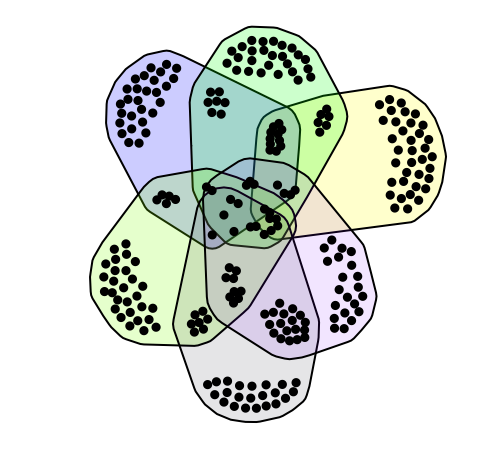

In [115]:
# vital nodes drifting (visualization in hypergraph) vital_nodes_index_score[0]
import matplotlib.pyplot as plt
import networkx as nx
import hypernetx as hnx

hyper_data = defaultdict(set)
for t in range(time_points):
    label = ''.join(['T',str(t+1)])
    hyper_data[label] = set(vital_genes_list[t])

H = hnx.Hypergraph(hyper_data)
kwargs = {'layout_kwargs': {'seed': 15}, 'with_node_counts': True}

cmap = plt.cm.viridis
alpha = .5
sizes = np.array([len(e) for e in H.edges()])
#norm = plt.Normalize(sizes.min(), sizes.max())
norm = plt.Normalize(0, 127)

hnx.drawing.draw(H,
                 label_alpha=0,
                 node_labels_kwargs={
                     'fontsize': 0
                 },
                 edge_labels_kwargs={
                    'fontsize': 0     #change here for time point label
                 },
                 edges_kwargs={
                     'facecolors': [(1,1,0, 0.2),(0.0, 0.0, 1.0, 0.2),(0.0, 1.0, 0.0, 0.2),(0.5, 1.0, 0.0, 0.2),(0.0, 0.0, 0.1, 0.1),(0.5, 0.0, 1.0, 0.1)],
                     #['c','b','g','y','m','bisque'],
                     #[(1,1,0,0),(0,1,0,.5),(0,1,0,0),(0,0,1,.5),(1,0,0,0.5),(1,1,1,0)],
                     #cmap(norm(sizes))*(1, 1, 1, alpha),
                     'edgecolors': 'black',
                     'linewidths': 2
                 },
                 **kwargs)

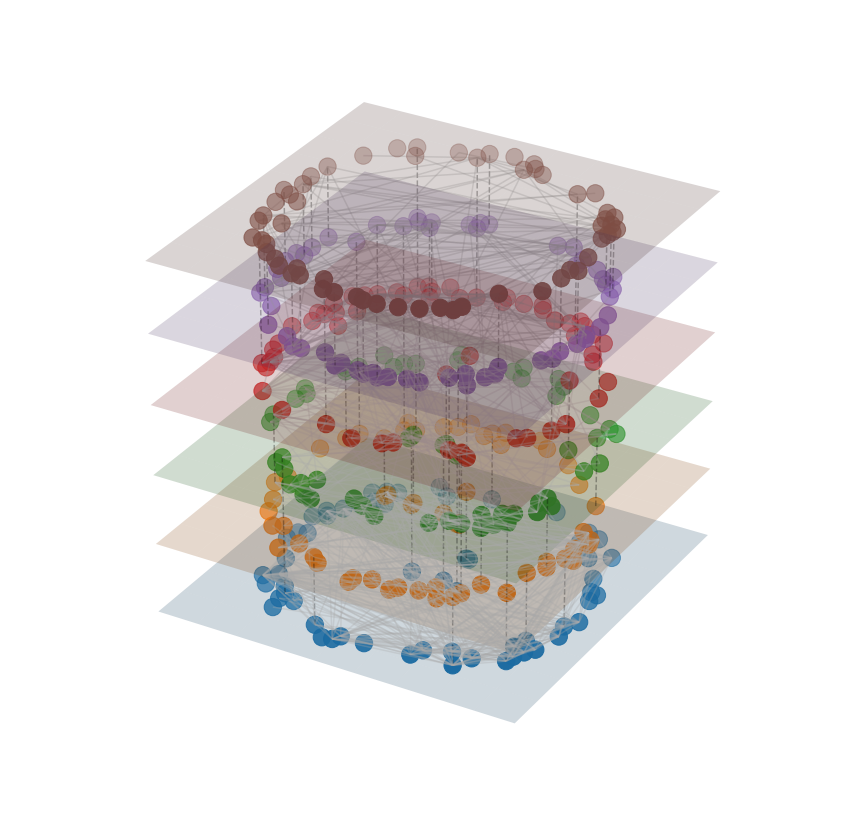

In [136]:
#!/usr/bin/env python
"""
Plot multi-graphs in 3D.
"""
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection


class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='darkgray', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=300, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)
            
# Action
#if __name__ == '__main__':

# define graphs
multi_layered_graphs = []
for t in range(time_points):
    g = nx.Graph()
    multi_layered_graphs.append(g)

for t in range(time_points):
    multi_layered_graphs[t].add_nodes_from(vital_genes_list[t])
    for (gene_i_id, gene_j_id) in vital_genes_interactions[t].keys():
        co_complexes = vital_genes_interactions[t][gene_i_id, gene_j_id][0]
        co_pathways = vital_genes_interactions[t][gene_i_id, gene_j_id][1]
        edge_weight = co_complexes + co_pathways
        multi_layered_graphs[t].add_edge(gene_i_id, gene_j_id, weight=edge_weight)

#n = 5
#g = nx.erdos_renyi_graph(4*n, p=0.1)
#h = nx.erdos_renyi_graph(3*n, p=0.2)
#i = nx.erdos_renyi_graph(2*n, p=0.4)
#node_labels = {nn : str(nn) for nn in range(4*n)}

# initialise figure and plot
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection='3d')
#LayeredNetworkGraph([g,h,i], node_labels=node_labels, ax=ax, layout=nx.spring_layout)
LayeredNetworkGraph(multi_layered_graphs, ax=ax, layout=nx.spring_layout)
ax.set_axis_off()
plt.show()

244
737


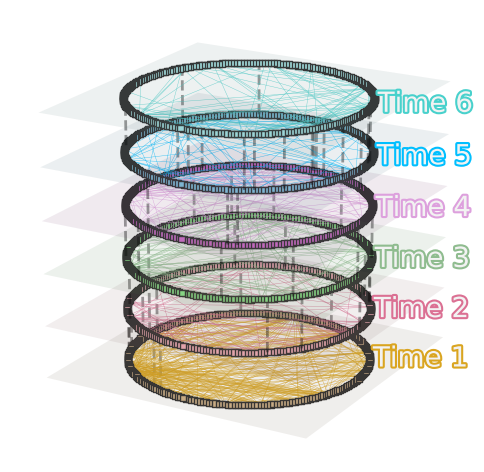

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
import matplotlib.patheffects as path_effects
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline

# let's start with the important stuff. pick your colors.
#cols = ['steelblue', 'darksalmon', 'mediumseagreen', 'mediumpurple', 'darkkhaki', 'mediumturquoise']
#cols_line = ['steelblue', 'darksalmon', 'mediumseagreen', 'mediumpurple', 'darkkhaki', 'mediumturquoise']
cols_line = ['goldenrod','palevioletred','darkseagreen','plum','deepskyblue','mediumturquoise']
cols = ['tan','lightpink','lightgreen','orchid','skyblue','paleturquoise']
# define graphs
g1 = nx.Graph()  #nx.DiGraph()  #
g2 = nx.Graph()
g3 = nx.Graph()
g4 = nx.Graph()
g5 = nx.Graph()
g6 = nx.Graph()


all_genes = []
for t in range(time_points):
    for i in vital_genes_list[t]:
        all_genes.append(i)
print(len(set(all_genes)))
all_genes = list(set(all_genes))
all_edges = []
for t in range(time_points):
    for (gene_i_id, gene_j_id) in vital_genes_interactions[t].keys():
        all_edges.append((gene_i_id, gene_j_id))
print(len(set(all_edges)))
all_edges = list(set(all_edges))
base_graph = nx.Graph()
base_graph.add_nodes_from(all_genes)
for (gene_i_id, gene_j_id) in all_edges:
    base_graph.add_edge(gene_i_id, gene_j_id)

pos = nx.circular_layout(base_graph)  #nx.spring_layout(base_graph) # assuming common node location nx.circular_layout(base_graph) #
multi_layered_graphs = [g1,g2,g3,g4,g5,g6]

for t in range(time_points):
    #multi_layered_graphs[t].add_nodes_from(vital_genes_list[t])
    for (gene_i_id, gene_j_id) in vital_genes_interactions[t].keys():
        co_complexes = vital_genes_interactions[t][gene_i_id, gene_j_id][0]
        co_pathways = vital_genes_interactions[t][gene_i_id, gene_j_id][1]
        edge_weight = co_complexes + co_pathways
        #print(gene_i_id, gene_j_id, edge_weight)
        multi_layered_graphs[t].add_edge(gene_i_id, gene_j_id)  #, weight=1)  #edge_weight)

w = 6
h = 6
fig, ax = plt.subplots(1, 1, figsize=(w,h), dpi=100, subplot_kw={'projection':'3d'})

for gi, G in enumerate(multi_layered_graphs):
    # node positions
    xs = list(list(zip(*list(pos.values())))[0])
    ys = list(list(zip(*list(pos.values())))[1])
    zs = [gi]*len(xs) # set a common z-position of the nodes 

    # node colors
    cs = [cols[gi]]*len(xs)
    
    # if you want to have between-layer connections
    if gi > 0:
        thru_nodes = np.random.choice(list(G.nodes()),10,replace=False)
        lines3d_between = [(list(pos[i])+[gi-1],list(pos[i])+[gi]) for i in thru_nodes]
        between_lines = Line3DCollection(lines3d_between, zorder=gi, color='k',
                                         alpha=0.4, linestyle='--', linewidth=2)   #color='.5'
        ax.add_collection3d(between_lines)

    # add within-layer edges 
    lines3d = [(list(pos[i])+[gi],list(pos[j])+[gi]) for i,j in G.edges()]
    line_collection = Line3DCollection(lines3d, zorder=gi, color=cols_line[gi], linestyle='-', alpha=0.8, linewidth=0.3)
    ax.add_collection3d(line_collection)
    
    # now add nodes
    ax.scatter(xs, ys, zs, c=cs, edgecolors='.2', marker='s', alpha=1, zorder=gi+1)

 #   # if you want labels...
 #   for li, lab in enumerate(list(G.nodes())):
 #      ax.text(xs[li], ys[li], zs[li], lab, color='.2', zorder=gi+200, fontsize=6,
 #               ha='center', va='center')
        
    # add a plane to designate the layer
    xdiff = max(xs)-min(xs)
    ydiff = max(ys)-min(ys)
    ymin = min(ys)-ydiff*0.1
    ymax = max(ys)+ydiff*0.1
    xmin = min(xs)-xdiff*0.1 * (w/h)
    xmax = max(xs)+xdiff*0.1 * (w/h)
    xx, yy = np.meshgrid([xmin, xmax],[ymin, ymax])
    zz = np.zeros(xx.shape)+gi
    ax.plot_surface(xx, yy, zz, color=cols[gi], alpha=0.1, zorder=gi)

    # add label
    layertext = ax.text(0.0, 1.15, gi*0.95+0.5, "Time %i"%(gi+1),
                        color='.95', fontsize=20, zorder=1e5, ha='left', va='center',
                        path_effects=[path_effects.Stroke(linewidth=3, foreground=cols_line[gi]),
                                      path_effects.Normal()])
# set them all at the same x,y,zlims
ax.set_ylim(min(ys)-ydiff*0.1,max(ys)+ydiff*0.1)
ax.set_xlim(min(xs)-xdiff*0.1,max(xs)+xdiff*0.1)
ax.set_zlim(-0.1, len(multi_layered_graphs) - 1 + 0.1)

# select viewing angle
angle = 30
height_angle = 20
ax.view_init(height_angle, angle)

# how much do you want to zoom into the fig
ax.dist = 8.5

ax.set_axis_off()

# plt.savefig('multilayer_network.png',dpi=425,bbox_inches='tight')
plt.show()

-------------------- 
 Network splitting in progress 
 --------------------


100%|██████████| 100/100 [00:00<00:00, 208.86it/s]


BarnesHut Approximation  took  0.07  seconds
Repulsion forces  took  0.37  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


100%|██████████| 100/100 [00:00<00:00, 195.82it/s]


BarnesHut Approximation  took  0.07  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


100%|██████████| 100/100 [00:00<00:00, 182.30it/s]


BarnesHut Approximation  took  0.08  seconds
Repulsion forces  took  0.42  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


100%|██████████| 100/100 [00:00<00:00, 329.85it/s]


BarnesHut Approximation  took  0.05  seconds
Repulsion forces  took  0.23  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


100%|██████████| 100/100 [00:00<00:00, 244.85it/s]


BarnesHut Approximation  took  0.06  seconds
Repulsion forces  took  0.30  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


100%|██████████| 100/100 [00:00<00:00, 183.64it/s]


BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.39  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds
Finished with layout..


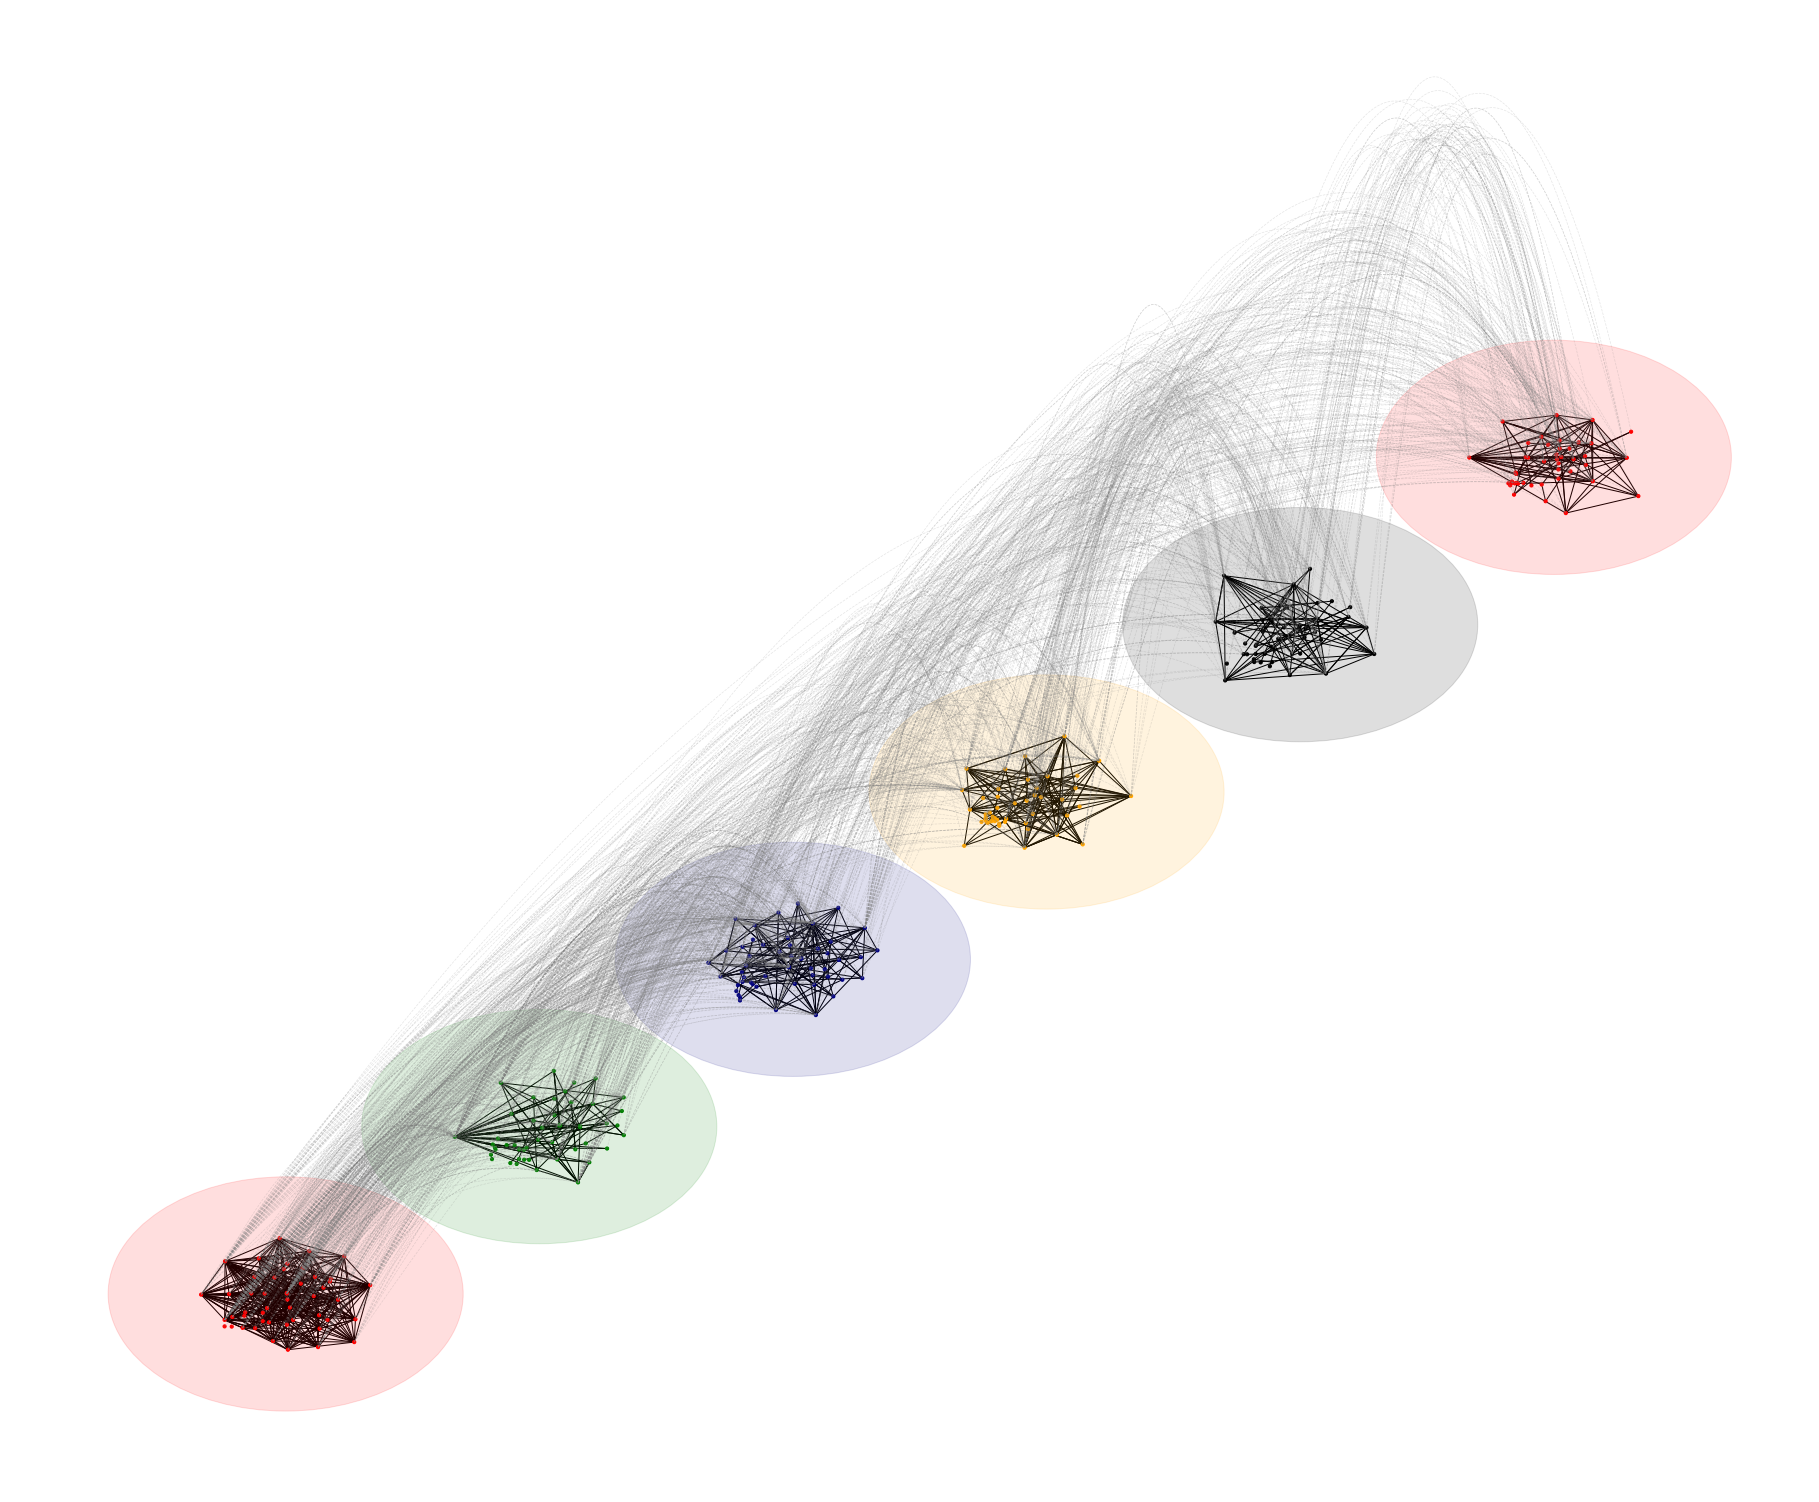

In [93]:
from py3plex.core import multinet
from py3plex.visualization.multilayer import draw_multiedges, draw_multilayer_default, plt
from py3plex.visualization.colors import colors_default

filename3="".join([data_dir, '/data/', tissue, '/DPPINs_vital_nodes_multiple_layers.txt'])
#multilayer/multiplex
#read file and get edge-layer list   - not finished
#filename3="".join([data_dir, '/data/', tissue, '/DPPINs_vital_nodes_multiple_layers.txt'])
#vital_genes_interactions_multiple_layer = []
#with open(filename3, 'r') as filehandling3:
#    for edge_layer in vital_genes_interactions_multiple_layer:
#        filehandling3.write('\t'.join(edge_layer))
#filehandling1.close()
#example_list_edge = [["node3","t2","node2","t6",1],["node3","t2","node2","t6",1]]
#A = multinet.multi_layer_network()  #network_type="multilayer").load_network(filename3,directed=False, input_type="multilayer_edges")
#A.add_edges(vital_genes_interactions_multiple_layer,input_type="list")

w=32
h=27
fig, ax = plt.subplots(1, 1, figsize=(w,h))

A = multinet.multi_layer_network().load_network(filename3, directed=False, input_type="multiedgelist")
network_labels, graphs, multilinks = A.get_layers() 
#A.set_layers()
list(A.get_nodes())[0][1]
#color_mappings = {idx: col for idx, col in enumerate(colors_default)}
#network_colors_hairball, graph = A.get_layers(style="hairball")
cols_line = ['goldenrod','palevioletred','darkseagreen','plum','deepskyblue','mediumturquoise']
node_network_colors = [
    cols_line[int(layer[-1])-1]
    for (gene_id, layer) in list(A.get_nodes())
]
graphs_in_correct_order = [graphs[0],graphs[1], graphs[2],graphs[3],graphs[5],graphs[4]]
network_labels_in_correct_order = ['Time Period 1', 'Time Period 2','Time Period 3','Time Period 4','Time Period 5','Time Period 6']
# monotone coloring
#draw_multilayer_default(graphs_in_correct_order,
#                        display=False,
#                        background_shape="oval",
#                        labels=network_labels_in_correct_order,
#                        networks_color='black',
#                        rectanglex=2,
#                        rectangley=2,
#                        background_color="default")

draw_multilayer_default(graphs_in_correct_order,display=False,background_shape="circle") #
      #,labels=network_labels_in_correct_order)
enum = 1
for edge_type, edges in multilinks.items():
    draw_multiedges(graphs_in_correct_order,
                    edges,
                    alphachannel=0.2,
                    linepoints="--",
                    linecolor="gray",  #lightgray",
                    curve_height=1.5,
                    linmod="upper",
                    linewidth=0.7)
    enum += 1

#A.basic_stats()

## going full py3plex (default 100 iterations, layout_parameters can carry additional parameters)
#A.visualize_network(style="diagonal")
plt.show()

filename4="".join([data_dir, '/data/', tissue, '/Dynamic_DPPINs_edges_drifting.png'])
#plt.savefig(filename4, format="PNG")


In [ ]:
multilinks

In [75]:
graphs

(<networkx.classes.multigraph.MultiGraph at 0x170097e87b8>,
 <networkx.classes.multigraph.MultiGraph at 0x1702354df98>)

In [66]:
list(A.get_nodes())[0][1]

't1'

In [179]:
multi_layered_graphs[0].nodes()

NodeView(('FH', 'CCT2', 'NME3', 'LDLR', 'LBR', 'CBLB', 'FGF12', 'DLD', 'SQLE', 'ATP6V1H', 'PSMC6', 'TCF7L2', 'PYGB', 'FZD7', 'ELOVL7', 'GNG7', 'ALDH18A1', 'ALOX5AP', 'HSD17B1', 'ALOX5', 'AMOTL2', 'ACTB', 'PXN', 'CXCL5', 'NPFFR2', 'UCHL5', 'ENTPD3', 'PDE9A', 'POM121', 'TFRC', 'SLC38A1', 'AQP3', 'VAV3', 'SLC16A3', 'FANCL', 'CD33', 'CLDN11', 'SFRP4', 'IGFBP5', 'DERL1', 'BAG6', 'PICALM', 'COPB1'))

H.dual()
count = defaultdict(int)
for e in H.dual().edges():
    #print(e, len(e.elements.keys()))
    conditions = len(e.elements.keys())
    count[conditions] += 1
    
print(count)

In [ ]:
....

# Step 11 Verify DPPNs

In [90]:
def calculate_num_of_edges(graph_adjacent_matrix):
    num_nodes = np.shape(graph_adjacent_matrix)[0] #num_of_nodes   #np.shape(graph_adjacent_matrix)[0]
    count = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if (i != j and graph_adjacent_matrix[i,j] > 0):
                count +=1
    return int(count /2)

def perform_DPPINs_node_seq_sim(PPIN_network, mock_DPPINs, group_name1, exp_DPPINs, group_name2, id2protein, time_points, num_of_nodes, node_ids):
    for t in range(1): #time_points):
        output_temporal_seqw_bipartite_at_t = open(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + group_name1 + '_' + group_name2 + '_' + str(t) +  '_seqsim.txt', 'w')
        print(t)
        mock_DPPIN = mock_DPPINs[t]
        mock_num_proteins = np.shape(mock_DPPIN)[0]
        mock_num_edges = calculate_num_of_edges(mock_DPPIN)
        
        exp_DPPIN = exp_DPPINs[t]
        exp_num_proteins = np.shape(exp_DPPIN)[0]
        exp_num_edges = calculate_num_of_edges(exp_DPPIN)
        
        mock_proteins = set()
        exp_proteins = set()

        for j in range(mock_num_proteins):
            for k in range(mock_num_proteins):
                if mock_DPPIN[j, k] > 0:
                    mock_proteins.add(id2protein[j])
                    mock_proteins.add(id2protein[k])

        for j in range(exp_num_proteins):
            for k in range(exp_num_proteins):        
                if exp_DPPIN[j, k] > 0:
                    exp_proteins.add(id2protein[j])
                    exp_proteins.add(id2protein[k])   

        #print(len(mock_proteins))
        seq_align_set = set()
        for gene1 in mock_proteins:
            for gene2 in exp_proteins:
                seq_align = pairwise2.align.globalxx(gene1, gene2)
                if (seq_align[0][2]>0):
                    #if (len(mock_proteins) <= len(exp_proteins)):
                    if (mock_num_edges <= exp_num_edges):
                        seq_align_set.add((gene1, gene2, seq_align[0][2]))
                    else:
                        seq_align_set.add((gene2, gene1, seq_align[0][2]))  
        
        for (gene1, gene2, value) in seq_align_set:
            output_temporal_seqw_bipartite_at_t.write(gene1 + ' ' + gene2 + ' ' + str(value) + '\n')
      
        output_temporal_seqw_bipartite_at_t.close()
    
# Action
#perform_DPPINs_node_seq_sim(PPIN_network, mock_DPPINs, 'mock', exp_DPPINs, 'exp', id2protein, time_points, common_num_proteins, common_protein_set)
print('done')


done


In [91]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partitions, **kwargs):

#    for p_name in partitions:
#        partition = partitions[p_name]
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    modularity2 = community.modularity(louvain_partition, g, weight='weight')
    pos = community_layout(g, partition)

    nx.draw(g, pos, node_color=list(partition.values())); plt.show()
    return

#

In [92]:
def getAllPairs(DPPIN):
    num_nodes = np.shape(DPPIN)[0]
    allpairs_associations = dict()
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if DPPIN[i,j] > 0:
                allpairs_associations[i,j] = DPPIN[i,j]
    return allpairs_associations

def getAllPath(DPPIN):
    num_nodes = np.shape(DPPIN)[0]
    g = Graph(num_nodes)
    g.constructGraph(DPPIN)
    print('getAllPath--- finish the constructGraph')
    allpaths, num_of_paths, allpairs_num_of_paths = g.getAllPaths() 
    return allpaths, num_of_paths, allpairs_num_of_paths

def count_common_complexes(complexes, gene_i, gene_j, complexes_genes, complexes_genes_syn):
    count = 0
    common_complex_names = []
    for i in range(len(complexes_genes)):
        group = complexes_genes[i] + complexes_genes_syn[i]
        if gene_i in group and gene_i in group:
            count += 1
            common_complex_names.append(complexes['ComplexName'][i])
    return count, list(set(common_complex_names))

def getCommonComplex(allpairs_num_of_paths, id2protein):
    complexes = pd.read_excel("".join([data_dir, '/data/', 'humanComplexes.xlsx']), sheet_name = 'humanComplexes')
    complexes_genes_strings = complexes['subunits(Gene name)']
    complexes_genes_syn_strings = complexes['subunits(Gene name syn)']
    complexes_genes = [list(filter(None, genes.strip().split(';')))  for genes in complexes_genes_strings]
    complexes_genes_syn = [list(filter(None, genes.strip().split(';')))  for genes in complexes_genes_syn_strings]
    total_complexes = len(complexes_genes_strings)
    
    allpairs_num_of_complexes = dict()
    allpairs_num_of_complexes_names = defaultdict(list)
    for i,j in allpairs_num_of_paths:
        gene_i = id2protein[i]
        gene_j = id2protein[j]
        count, common_complex_names = count_common_complexes(complexes, gene_i, gene_j, complexes_genes, complexes_genes_syn)
        allpairs_num_of_complexes[i,j] = count   #/total_complexes
        allpairs_num_of_complexes_names[i,j] = common_complex_names
    return allpairs_num_of_complexes, allpairs_num_of_complexes_names, total_complexes

def count_common_pathways(gene_pathways_dict, gene_i, gene_j):
    pathway_i = list(set(gene_pathways_dict[gene_i]))
    pathway_j = list(set(gene_pathways_dict[gene_j]))
    common_pathway_names = [value for value in pathway_i if value in pathway_j]
    return len(common_pathway_names), common_pathway_names

def getCommonPathways(allpairs_num_of_paths, id2protein):
    gene_pathways = pd.read_excel("".join([data_dir, '/data/', 'CTD_genes_pathways.xlsx']), sheet_name = 'CTD_genes_pathways')
    gene_pathways_dict = defaultdict(list)
    for i in range(len(gene_pathways['GeneSymbol'])):
        gene_pathways_dict[gene_pathways['GeneSymbol'][i]].append(gene_pathways['PathwayID'][i])
    total_pathways = len(set(gene_pathways['PathwayID']))
    
    allpairs_num_of_pathways_percentage = dict()
    allpairs_num_of_pathways_names = defaultdict(list)
    for i,j in allpairs_num_of_paths:
        gene_i = id2protein[i]
        gene_j = id2protein[j]
        
        count, common_pathways_names = count_common_pathways(gene_pathways_dict, gene_i, gene_j)
        allpairs_num_of_pathways_percentage[i,j] = count   #/total_pathways
        allpairs_num_of_pathways_names[i,j] = common_pathways_names
    return allpairs_num_of_pathways_percentage, allpairs_num_of_pathways_names, total_pathways

def perform_path_analysis(DPPIN, id2protein, group_name, time_point):
    print('...getAllPairs')
    allpairs_associations = getAllPairs(DPPIN)
    print(allpairs_associations)
    print('...getAllPath')
    allpaths, num_of_paths, allpairs_num_of_paths = getAllPath(DPPIN)
    print('#(total paths)', sum(num_of_paths))
    #print(num_of_paths)
    #print(allpairs_num_of_paths)
    print('...getAllPath percentage')
    allpairs_num_of_paths_prob = dict()
    for i,j in allpairs_num_of_paths:
        allpairs_num_of_paths_prob[i,j] = allpairs_num_of_paths[i,j] / sum(num_of_paths)
        
    print('...getCommonComplex')    
    allpairs_num_of_complexes, allpairs_num_of_complexes_names, total_complexes = getCommonComplex(allpairs_num_of_paths, id2protein)
    
    print('...getCommonPathways')  
    allpairs_num_of_pathways, allpairs_num_of_pathways_names, total_pathways = getCommonPathways(allpairs_num_of_paths, id2protein)
    
    filename="".join([data_dir, '/data/', tissue, '/DPPINs_', group_name,'_t', str(time_point), '_pairs.txt'])
    print('...writing...', filename) 
    with open(filename, 'w') as f:
        f.write(' '.join(['sum(num_of_paths):', str(sum(num_of_paths)), 'total_complexes', str(total_complexes), 'total_pathways', str(total_pathways)]))
        for i,j in allpairs_associations:
            if (i,j) not in allpairs_num_of_paths:
                allpairs_num_of_paths[i,j] = 0
                allpairs_num_of_complexes[i,j] = 0
                allpairs_num_of_pathways[i,j] = 0
                
            #print(allpairs_associations[i,j])
            #print(allpairs_num_of_paths_prob[i,j])
            #print(allpairs_num_of_complexes[i,j])
            #print(allpairs_num_of_complexes[i,j])
            #print(str(allpairs_num_of_pathways[i,j]))
            #print(','.join(allpairs_num_of_pathways_names[i,j]))
            
            f.write(' '.join([id2protein[i], id2protein[j], str(allpairs_associations[i,j]), 
                              str(allpairs_num_of_paths[i,j]),str(allpairs_num_of_complexes[i,j]), ','.join(allpairs_num_of_complexes_names[i,j]), str(allpairs_num_of_pathways[i,j]), ','.join(allpairs_num_of_pathways_names[i,j]), '\n']))
    f.close()
    return allpairs_associations, allpairs_num_of_paths_prob, allpairs_num_of_complexes, allpairs_num_of_pathways
    
# get all paths of dynamic PPINs, check common complexes and common pathways
mock_allpairs_associations = []
mock_allpairs_num_of_paths_prob = []
mock_allpairs_num_of_complexes = []
mock_allpairs_num_of_pathways = []
exp_allpairs_associations = []
exp_allpairs_num_of_paths_prob = []
exp_allpairs_num_of_complexes = []
exp_allpairs_num_of_pathways = []
for time_point in range(time_points):
    print('mock', time_point)
    mock_DPPIN = mock_DPPINs[time_point]
    allpairs_associations, allpairs_num_of_paths_prob, allpairs_num_of_complexes, allpairs_num_of_pathways = perform_path_analysis(mock_DPPIN, id2protein, 'mock',time_point)
    mock_allpairs_associations.append(allpairs_associations)
    mock_allpairs_num_of_paths_prob.append(allpairs_num_of_paths_prob)
    mock_allpairs_num_of_complexes.append(allpairs_num_of_complexes)
    mock_allpairs_num_of_pathways.append(allpairs_num_of_pathways)
    
    print('exp', time_point)
    exp_DPPIN = exp_DPPINs[time_point]
    allpairs_associations, allpairs_num_of_paths_prob, allpairs_num_of_complexes, allpairs_num_of_pathways = perform_path_analysis(exp_DPPIN, id2protein, 'exp',time_point)
    exp_allpairs_associations.append(allpairs_associations)
    exp_allpairs_num_of_paths_prob.append(allpairs_num_of_paths_prob)
    exp_allpairs_num_of_complexes.append(allpairs_num_of_complexes)
    exp_allpairs_num_of_pathways.append(allpairs_num_of_pathways)

mock 0
...getAllPairs
{(3, 92): 0.9801, (5, 7): 0.9405, (5, 28): 0.9405, (5, 32): 0.646, (5, 48): 0.9405, (5, 65): 0.9405, (5, 69): 0.9405, (5, 77): 0.9404998878836632, (5, 108): 0.9405, (5, 116): 0.9404999439418316, (5, 136): 0.9405, (5, 144): 0.9405, (5, 149): 0.9405, (5, 156): 0.9405, (5, 160): 0.9405, (5, 162): 0.9025, (5, 190): 0.9025, (5, 191): 0.9405, (5, 199): 0.9405, (5, 209): 0.9025, (5, 213): 0.9405, (5, 232): 0.9405, (5, 244): 0.9405, (5, 255): 0.9404999439418316, (5, 261): 0.9405, (5, 289): 0.9025, (5, 294): 0.9405, (5, 310): 0.9405, (5, 320): 0.9405, (5, 328): 0.9405, (5, 338): 0.9405, (5, 360): 0.9405, (5, 361): 0.9405, (5, 364): 0.9405, (5, 374): 0.9405, (5, 379): 0.9405, (5, 384): 0.9405, (5, 391): 0.9404999439418316, (5, 392): 0.9405, (5, 393): 0.9405, (5, 413): 0.9025, (5, 433): 0.9405, (5, 439): 0.9405, (5, 442): 0.9405, (5, 446): 0.9405, (5, 448): 0.9405, (5, 463): 0.9405, (5, 465): 0.9405, (5, 466): 0.9405, (5, 468): 0.9405, (5, 503): 0.9405, (5, 508): 0.9405, (5,

TypeError: constructGraph() missing 2 required positional arguments: 'num_of_nodes' and 'node_ids'

In [ ]:
with open("".join([data_dir, '/data/', tissue, '/validate_DPPINs.txt']), 'w') as f:
    for time_point in range(time_points):
        mock_DPPIN = mock_DPPINs[time_point]
        filename = '_'.join(['mock_t', str(time_point)])
        perform_network_validation(mock_DPPIN, filename, f)
        exp_DPPIN = exp_DPPINs[time_point]
        filename = '_'.join(['exp_t', str(time_point)])
        perform_network_validation(exp_DPPIN, filename, f)            
f.close()
#validate_DPPIN("".join([data_dir, '/data/', tissue, '/validate_DPPINs']))

In [20]:
import heapq

def calculate_distances(graph, starting_vertex):
    distances = {vertex: float('infinity') for vertex in graph}
    distances[starting_vertex] = 0

    pq = [(0, starting_vertex)]
    while len(pq) > 0:
        current_distance, current_vertex = heapq.heappop(pq)

        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue

        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight

            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(pq, (distance, neighbor))

    return distances


newgraph = {
    'U': {'V': 2, 'W': 5, 'X': 3},
    'V': {'U': 5, 'X': 1, 'W': 3},
    'W': {'V': 3, 'U': 5, 'X': 3, 'Y': 7, 'Z': 5},
    'X': {'U': 1, 'V': 2, 'W': 3, 'Y': 1},
    'Y': {'X': 2, 'W': 3, 'Z': 6},
    'Z': {'W': 5, 'Y': 6},
}
print(calculate_distances(newgraph, 'X'))

{'U': 1, 'V': 2, 'W': 3, 'X': 0, 'Y': 1, 'Z': 7}


In [ ]:
validate_DPPIN("".join([data_dir, '/data/', tissue, '/validate_DPPINs.txt']))

In [ ]:
# dynamic network alignment

In [64]:
from __future__ import print_function
import PSB2009_3opt_2 as psb09   #noseq2
import matching as match

import importlib

importlib.reload(psb09)
importlib.reload(match)

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
from community import community_louvain

# Given any two graphs, where graph vertices include gene symbols, compute the sequence similarity of nodes from smaller 
# graph to larger graph based on the number of edges
def perform_DPPIN_node_seq_sim(graph1, graph2, seqSimfile):
    graph1_num_of_edges = graph1.number_of_edges()
    graph2_num_of_edges = graph2.number_of_edges()
    
    output_seqw_bipartite = open(seqSimfile, 'w')
    seq_align_set = set()
    for gene1 in graph1.nodes():
        for gene2 in graph2.nodes():
            seq_align = pairwise2.align.globalxx(gene1, gene2)
            if (seq_align[0][2]>0):
                #if (len(mock_proteins) <= len(exp_proteins)):
                if (graph1_num_of_edges <= graph2_num_of_edges):
                    seq_align_set.add((gene1, gene2, seq_align[0][2]))
                else:
                    seq_align_set.add((gene2, gene1, seq_align[0][2]))  
        
    for (gene1, gene2, value) in seq_align_set:
        output_seqw_bipartite.write(gene1 + ' ' + gene2 + ' ' + str(value) + '\n')

    output_seqw_bipartite.close() 
    
def make_node_positions(graph,partition_attr,partition_order=None,epsilon=.5):
    #print('partition_order:', partition_order)
    if not partition_order:
        # get a list of all the partition names if not specified
        partition_order = list(set(dict(graph.nodes(data=partition_attr)).values()))
    
    # make position dict for each partition
    orig_partition_pos_dicts = {partition:nx.spring_layout(graph.subgraph([node for node,part in graph.nodes(data=partition_attr)
                                                                                      if part == partition]))
                                for partition in partition_order}
    
    # update the x coordinate in the position dicts so partitions
    # don't overlap and are in the specified order left-to-right
    final_pos_dict = orig_partition_pos_dicts[partition_order[0]]
    max_previous =10
    current_min = 0
    for i,partition in enumerate(partition_order[1:]):
        print(i, partition)
        if len(final_pos_dict.values())>0: 
            # get the largest x coordinate from the previous partition's nodes
            max_previous = max([x for x,y in final_pos_dict.values()])
            # get smallest x coordinate from this partition's nodes
        if len(orig_partition_pos_dicts[partition].values()) > 0:
            current_min = min([x for x,y in orig_partition_pos_dicts[partition].values()])
            # update the x coordinates for this partition to be at least epsilon units
            # to the right of the right-most node in the previous partition
        final_pos_dict.update({node:(pos[0]+max_previous+abs(current_min)+epsilon,pos[1])
                                               for node,pos in orig_partition_pos_dicts[partition].items()})
    return(final_pos_dict)

def alignment(G1, G2, filename4pair, f):
    if G1.number_of_nodes == 0 or G2.number_of_nodes == 0:
        return
    
    plt.figure(figsize=(4, 4))
    options = {"edgecolors": "tab:gray", "node_size": 500, "alpha": 0.9}
    
    seqSimfile = PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + filename4pair +  '_seqsim.txt'
    perform_DPPIN_node_seq_sim(G1, G2, seqSimfile)
    GS = psb09.graphScores(seqSimfile)   #"pairwise_sequence_similarity_of_network1_and_2.evals")
    #print(G1.nodes)
    #print(G2.nodes)
    #print(GS.edges())
    M0 = match.max_weight_matching(GS) #run hungorian algorithm to produce initial alignment  
    (S, M) = psb09.processOnce(G1, G2, GS, M0, 0.6, 200) #run PISwap
    AlignG = nx.Graph()
    #output the alignment result
    F = open(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + filename4pair + '_match_output.txt','w')
    for node in M:
        print(node+" "+M[node], file = F)
        AlignG.add_edge(node, M[node])
    F.close()
    
    # Write plots to files
    #%% Function to make position dicts by partition
    set1 = set()
    set2 = set()
    for node in G1.nodes():
        set1.add(node)
    for node in G2.nodes():
        set2.add(node)
    nxCommon = set1.intersection(set2)
    common2G1 = []
    nxG1 = nx.Graph()
    for node in G1.nodes():
        if node not in nxCommon:
            nxG1.add_node(node)
    for (u, v) in G1.edges():
        if not (u in nxCommon or v in nxCommon):
            nxG1.add_edge(u, v)
        else:
            common2G1.append((u,v))
    common2G2 = []
    nxG2 = nx.Graph()
    for node in G2.nodes():
        if node not in nxCommon:
            nxG2.add_node(node)
    for (u, v) in G2.edges():
        if not (u in nxCommon or v in nxCommon):
            nxG2.add_edge(u, v)
        else:
            common2G2.append((u,v))
    nxCommonG = nx.Graph()
    for item in nxCommon:
        nxCommonG.add_node(item)

    # edges to connect the components
    extra_edges = [(u, v) for (u,v) in AlignG.edges()]
    list_extra_edge_strs = [','.join([u,v]) for (u,v) in AlignG.edges()]
    
    # combine graphs and specify the original graphs
    orig_graphs = {'nxG1':{'graph':nxG1,'color':'red'},
                   'common':{'graph':nxCommonG,'color':'blue'},
                   'nxG2':{'graph':nxG2,'color':'green'}}

    f.write(' '.join(['G1 nodes:', ' '.join(list(set1)),'\n']))
    f.write(' '.join(['G2 nodes:', ' '.join(list(set2)),'\n']))
    f.write(' '.join(['AlignG edges:', '\n'.join(list_extra_edge_strs),'\n']))
    
    nxOutputG = nx.MultiGraph()
    #pos = community_layout(nxOutputG, allPartition)
    for g_name,g_val_dict in orig_graphs.items():
        # add the nodes from that graph and specify the partition and node colors
        nxOutputG.add_nodes_from(g_val_dict['graph'].nodes,partition=g_name,color=g_val_dict['color'])
        if len(g_val_dict['graph'].edges) > 0:
            # if the graph has edges then add the edges
            nxOutputG.add_edges_from(g_val_dict['graph'].edges,partition=g_name,color=g_val_dict['color'])

    # add the extra edges to combine the graphs
    nxOutputG.add_edges_from(extra_edges,color='black')
    nxOutputG.add_edges_from(common2G1,color='red')
    nxOutputG.add_edges_from(common2G2,color='green')

    ##%% Draw graph #####
    my_pos = make_node_positions(nxOutputG,partition_attr='partition',partition_order=['nxG1','common', 'nxG2'])
    nx.draw_networkx_nodes(nxOutputG,my_pos,node_color=[c for n,c in nxOutputG.nodes(data='color')], **options)
    nx.draw_networkx_labels(nxOutputG,my_pos)
    nx.draw_networkx_edges(nxOutputG,my_pos,edge_color=[c for u,v,c in nxOutputG.edges(data='color')], **options)

    #plot_instance = netgraph.InteractiveGraph(nxOutputG, node_positions=my_pos)
    ######## drag nodes around #########
    # To access the new node positions:
    #node_positions = plot_instance.node_positions

    plt.tight_layout()
    plt.axis("off")
    
    plt.savefig(PPIN_network.split('/')[0] + '/' + PPIN_network.split('/')[1] + '/Dynamic_PPIN_' + filename4pair + '_match_output.png', format="PNG")
    plt.show(block=False)
    return S

def get_complex_nodes(graph, partition, complexid):
    nodes = []
    for item in partition:
        if partition[item] == complexid:
            nodes.append(item)
    return nodes

In [ ]:
tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
PPIN_network_list = ['data/lung/Static_PPIN.txt']
significant_genes = 'data/GSE28166_significant_genes.txt'

with open("".join([data_dir, '/data/', tissue, '/mock-exp_PPINs_alignment.txt']), 'w') as f:
# Align mock dynamic PPI with exp. dynamic PPI
    for PPIN_network in PPIN_network_list:
        group_name1 = 'mock'
        group_name2 = 'exp'
        time_interval = 6
        for t in range(time_interval):
            print('==> ' + str(t) + ' ----------------------------------------')
            graph1_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name1,'_',str(t),'_sim.txt'])
            graph2_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name2,'_',str(t),'_sim.txt'])
            filename4pair = "".join([group_name1,'_',group_name2,'_',str(t)])

            G1 = psb09.getGraph(graph1_name) #input network1
            G2 = psb09.getGraph(graph2_name)#input network2

            print('==> Align ' + graph1_name + '---' + graph2_name)
            alignment(G1, G2, filename4pair, f)
f.close()

In [ ]:
tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
PPIN_network_list = ['data/lung/Static_PPIN.txt']
significant_genes = 'data/GSE28166_significant_genes.txt'

with open("".join([data_dir, '/data/', tissue, '/exp_PPINs_alignment.txt']), 'w') as f:
# Align mock dynamic PPI with exp. dynamic PPI
    for PPIN_network in PPIN_network_list:
        group_name1 = 'mock'
        group_name2 = 'exp'
        time_interval = 6
        for t in range(time_interval-1):
            print('==> ' + str(t) + ' ----------------------------------------')
            graph1_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name1,'_',str(t),'_sim.txt'])
            graph2_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name1,'_',str(t+1),'_sim.txt'])
            filename4pair = "".join([group_name1,'_',group_name2,'_',str(t)])

            G1 = psb09.getGraph(graph1_name) #input network1
            G2 = psb09.getGraph(graph2_name)#input network2

            print('==> Align ' + graph1_name + '---' + graph2_name)
            alignment(G1, G2, filename4pair, f)
f.close()

In [ ]:
# complex alignments

In [ ]:
tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
PPIN_network_list = ['data/lung/Static_PPIN.txt']
significant_genes = 'data/GSE28166_significant_genes.txt'

group_name1 = 'mock'
group_name2 = 'exp'
with open("".join([data_dir, '/data/', tissue, '/', group_name1, '_', group_name2, '_complex_alignment.txt']), 'w') as f:
    # Align mock dynamic PPI with exp. dynamic PPI
    for PPIN_network in PPIN_network_list:
        time_interval = 6
        
        for t in range(time_interval):
            print('==> ' + str(t) + ' ----------------------------------------')
            graph1_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name1,'_',str(t),'_sim.txt'])
            graph2_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name2,'_',str(t),'_sim.txt'])

            G1 = psb09.getGraph(graph1_name) #input network1
            G2 = psb09.getGraph(graph2_name)#input network2
            # partition
            partitionG1 = community_louvain.best_partition(G1)
            partitionG2 = community_louvain.best_partition(G2)

            for complexG1 in list(set(partitionG1.values())):
                partitionG1_nodes = get_complex_nodes(G1, partitionG1, complexG1)
                for complexG2 in list(set(partitionG2.values())):
                    partitionG2_nodes = get_complex_nodes(G2, partitionG2, complexG2)
                    G1_complex = G1.subgraph(partitionG1_nodes)
                    G2_complex = G1.subgraph(partitionG2_nodes)
                    filename4pair = "".join([group_name1,'_c', str(complexG1), '_',group_name2,'_c', str(complexG2),'_',str(t)])

                    #print('==> Align ' + "".join([group_name1,'_c', str(complexG1), '_',group_name2,'_c', str(complexG2),'_',str(t)]))
                    complex_align_score = alignment(G1_complex, G2_complex, filename4pair, f)
                    f.write(' '.join([''.join(['t', str(t), group_name1,'_c', str(complexG1)]), ''.join([group_name2, '_c', str(complexG2)]), str(complex_align_score), '\n']))
f.close()

In [ ]:
tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
PPIN_network_list = ['data/lung/Static_PPIN.txt']
significant_genes = 'data/GSE28166_significant_genes.txt'

group_name1 = 'exp'
group_name2 = 'exp'
with open("".join([data_dir, '/data/', tissue, '/', group_name1, '_', group_name2, '_complex_alignment.txt']), 'w') as f:
    # Align mock dynamic PPI with exp. dynamic PPI
    for PPIN_network in PPIN_network_list:
        time_interval = 6
        
        for t in range(time_interval-1):
            print('==> ' + str(t) + ' ----------------------------------------')
            graph1_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name1,'_',str(t),'_sim.txt'])
            graph2_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name2,'_',str(t+1),'_sim.txt'])

            G1 = psb09.getGraph(graph1_name) #input network1
            G2 = psb09.getGraph(graph2_name)#input network2
            # partition
            partitionG1 = community_louvain.best_partition(G1)
            partitionG2 = community_louvain.best_partition(G2)

            for complexG1 in list(set(partitionG1.values())):
                partitionG1_nodes = get_complex_nodes(G1, partitionG1, complexG1)
                for complexG2 in list(set(partitionG2.values())):
                    partitionG2_nodes = get_complex_nodes(G2, partitionG2, complexG2)
                    G1_complex = G1.subgraph(partitionG1_nodes)
                    G2_complex = G1.subgraph(partitionG2_nodes)
                    filename4pair = "".join([group_name1,'_c', str(complexG1), '_',group_name2,'_c', str(complexG2),'_',str(t)])

                    #print('==> Align ' + "".join([group_name1,'_c', str(complexG1), '_',group_name2,'_c', str(complexG2),'_',str(t)]))
                    complex_align_score = alignment(G1_complex, G2_complex, filename4pair, f)
                    f.write(' '.join([''.join(['t', str(t), group_name1,'_c', str(complexG1)]), ''.join([group_name2, '_c', str(complexG2)]), str(complex_align_score), '\n']))
f.close()

In [ ]:
tissue = 'lung'
gene_expression = 'data/GSE28166.txt'
PPIN_network_list = ['data/lung/Static_PPIN.txt']
significant_genes = 'data/GSE28166_significant_genes.txt'

group_name1 = 'mock'
group_name2 = 'mock'
with open("".join([data_dir, '/data/', tissue, '/', group_name1, '_', group_name2, '_complex_alignment.txt']), 'w') as f:
    # Align mock dynamic PPI with exp. dynamic PPI
    for PPIN_network in PPIN_network_list:
        time_interval = 6
        
        for t in range(time_interval-1):
            print('==> ' + str(t) + ' ----------------------------------------')
            graph1_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name1,'_',str(t),'_sim.txt'])
            graph2_name = "".join([PPIN_network.split('/')[0],'/',PPIN_network.split('/')[1],'/Dynamic_PPIN_',group_name2,'_',str(t+1),'_sim.txt'])

            G1 = psb09.getGraph(graph1_name) #input network1
            G2 = psb09.getGraph(graph2_name)#input network2
            # partition
            partitionG1 = community_louvain.best_partition(G1)
            partitionG2 = community_louvain.best_partition(G2)

            for complexG1 in list(set(partitionG1.values())):
                partitionG1_nodes = get_complex_nodes(G1, partitionG1, complexG1)
                for complexG2 in list(set(partitionG2.values())):
                    partitionG2_nodes = get_complex_nodes(G2, partitionG2, complexG2)
                    G1_complex = G1.subgraph(partitionG1_nodes)
                    G2_complex = G1.subgraph(partitionG2_nodes)
                    filename4pair = "".join([group_name1,'_c', str(complexG1), '_',group_name2,'_c', str(complexG2),'_',str(t)])

                    #print('==> Align ' + "".join([group_name1,'_c', str(complexG1), '_',group_name2,'_c', str(complexG2),'_',str(t)]))
                    complex_align_score = alignment(G1_complex, G2_complex, filename4pair, f)
                    f.write(' '.join([''.join(['t', str(t), group_name1,'_c', str(complexG1)]), ''.join([group_name2, '_c', str(complexG2)]), str(complex_align_score), '\n']))
f.close()

In [ ]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
G = nx.karate_club_graph()
print(G.edges())
# compute the best partition
partition = community_louvain.best_partition(G)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()
